In [1]:
import sys; sys.path.insert(0, "../../")
import os
from  functools import partial

import jax
from jax import random
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import flax.linen as nn

import numpy as np
import matplotlib.pyplot as plt

from experiments.configs.mnist_hard_ovr_classification import get_config
from src.data import get_image_dataset, NumpyLoader
from src.utils.notebook_metrics import *
from src.utils.training import setup_training

2022-11-29 18:14:02.190087: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 18:14:02.950449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-29 18:14:02.950545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-29 18:14:02.950603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [3]:
config = get_config()

In [4]:
train_dataset, test_dataset, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)
test_loader = NumpyLoader(test_dataset, config.batch_size, num_workers=8)

In [5]:
X_train, y_train = list(zip(*train_loader.dataset))

In [6]:
len(X_train)

54000

In [7]:
X_test, y_test = list(zip(*test_loader.dataset))

In [8]:
len(X_test)

10000

In [9]:
rng = random.PRNGKey(0)
setup_rng, rng = random.split(rng)
init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

prod_model, _ = setup_training(config, setup_rng, init_x, init_y)

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

In [10]:
MODEL_NAME = "prod_model_0_0.5_soft_ovr"

state = restore_checkpoint(f'dynNN_redux/{MODEL_NAME}', 1)
    
pred_fun = partial(
        prod_model.apply,
        {"params": state['params'], **state['model_state']},
        train=False,
        method=prod_model.ens_logits
    )


In [11]:
logits = jax.vmap(
    pred_fun, axis_name="batch"
)(jnp.array(X_test))



nlls_ = jax.vmap(ovr_nll)(logits, jnp.array(y_test))


infs = jnp.isinf(nlls_)
print(f"dropping {infs.sum()} infs for prod of 5 (TEST)")

zero_preds_ = jax.vmap(ovr_prod_probs)(logits).sum(axis=1) == 0.
print(f"dropping {zero_preds_.sum()} (zero probability) for prod of 5 (TEST)")

dropping 446 infs for prod of 5 (TEST)
dropping 396 (zero probability) for prod of 5 (TEST)


In [12]:
logits_train = jax.vmap(
    pred_fun, axis_name="batch"
)(jnp.array(X_train))

nlls_train = jax.vmap(ovr_nll)(logits_train, jnp.array(y_train))

infs_train = jnp.isinf(nlls_train)
print(f"dropping {infs_train.sum() / len(infs_train)} infs for prod of 5 (TRAIN)")

zero_preds_train = jax.vmap(ovr_prod_probs)(logits_train).sum(axis=1) == 0.
print(f"dropping {zero_preds_train.sum() / len(infs_train)} (zero probability) for prod of 5 (TRAIN)")

dropping 0.0017592592630535364 infs for prod of 5 (TRAIN)
dropping 0.0017592592630535364 (zero probability) for prod of 5 (TRAIN)


## 1) test OOD samples

In [14]:
def get_experts_preds(preds):
    return {i: int(x) for i, x in enumerate(preds.sum(axis=0)) if x >0}

========================= 0 ===============================
test id: 8
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


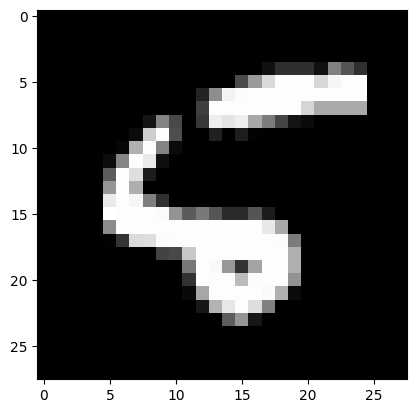

========================= 1 ===============================
test id: 115
individual experts pred: {4: 4, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


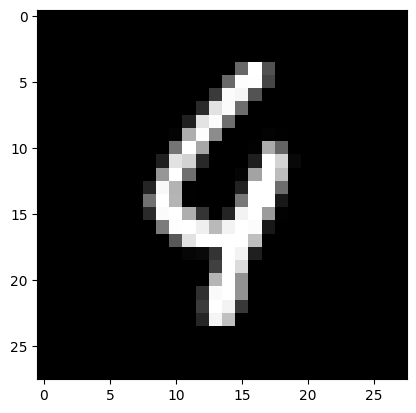

========================= 2 ===============================
test id: 149
individual experts pred: {2: 1, 4: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


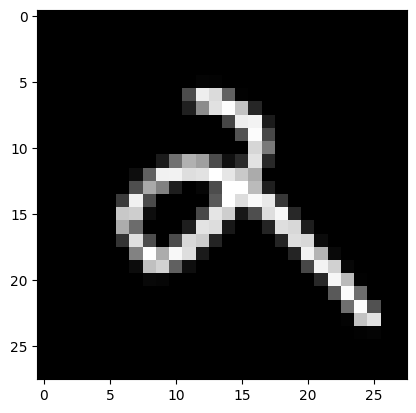

========================= 3 ===============================
test id: 241
individual experts pred: {8: 2, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


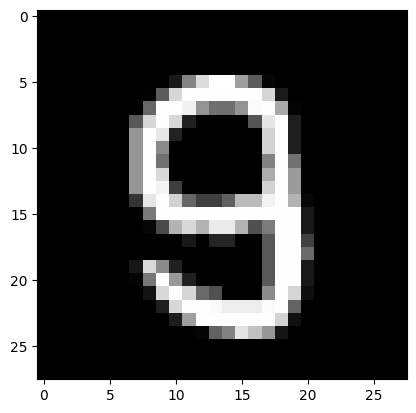

========================= 4 ===============================
test id: 259
individual experts pred: {0: 2, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


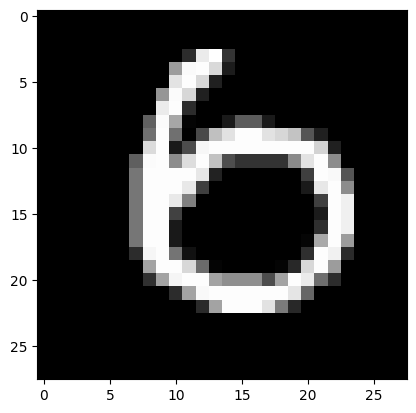

========================= 5 ===============================
test id: 290
individual experts pred: {4: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


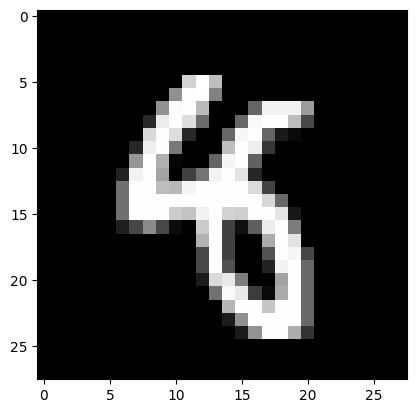

========================= 6 ===============================
test id: 300
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


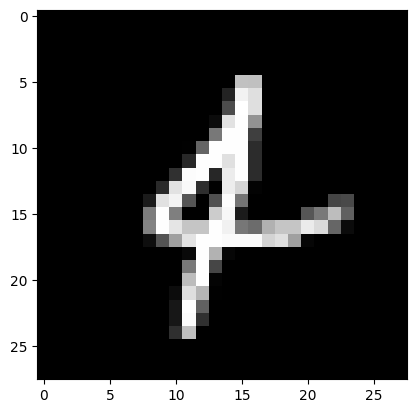

========================= 7 ===============================
test id: 320
individual experts pred: {8: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


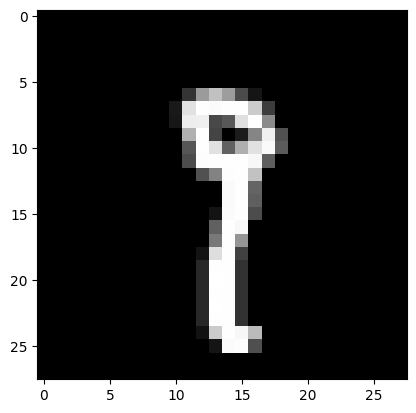

========================= 8 ===============================
test id: 321
individual experts pred: {2: 3, 7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


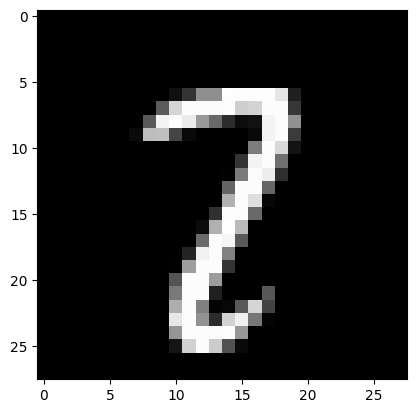

========================= 9 ===============================
test id: 381
individual experts pred: {3: 4, 7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


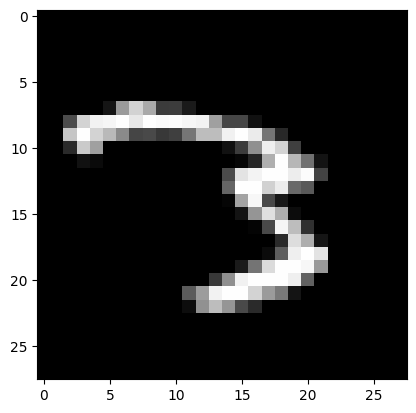

========================= 10 ===============================
test id: 447
individual experts pred: {4: 2, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


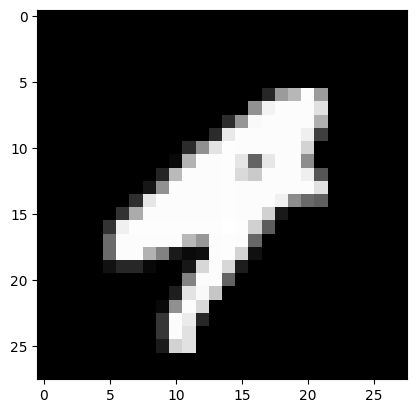

========================= 11 ===============================
test id: 448
individual experts pred: {3: 1, 8: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


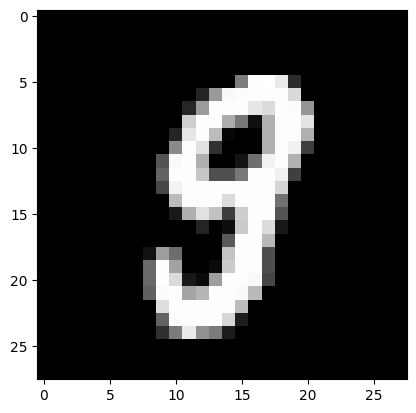

========================= 12 ===============================
test id: 449
individual experts pred: {3: 4, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


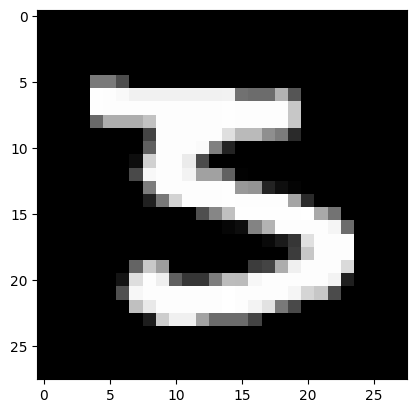

========================= 13 ===============================
test id: 495
individual experts pred: {2: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


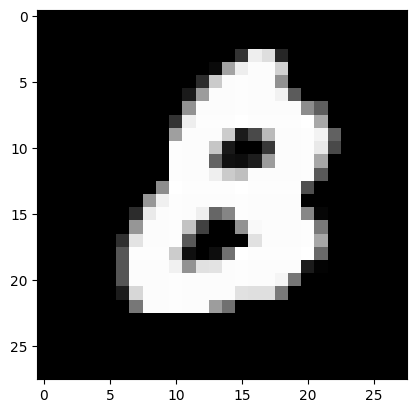

========================= 14 ===============================
test id: 522
individual experts pred: {3: 1, 7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


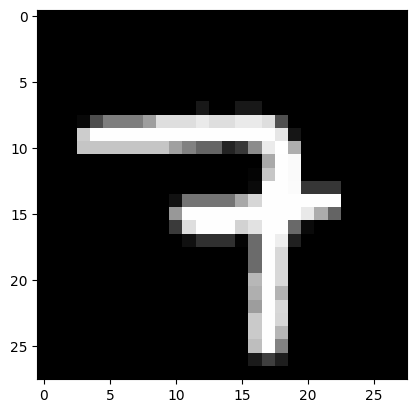

========================= 15 ===============================
test id: 551
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


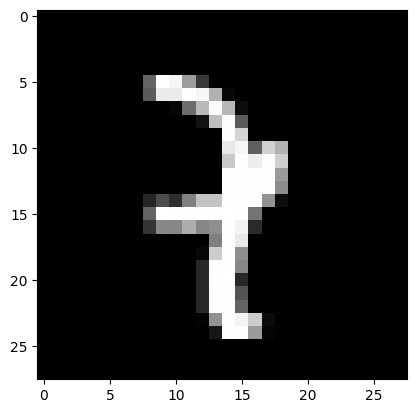

========================= 16 ===============================
test id: 582
individual experts pred: {2: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


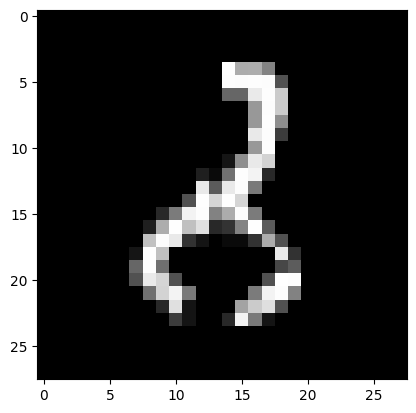

========================= 17 ===============================
test id: 583
individual experts pred: {2: 2, 7: 4, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


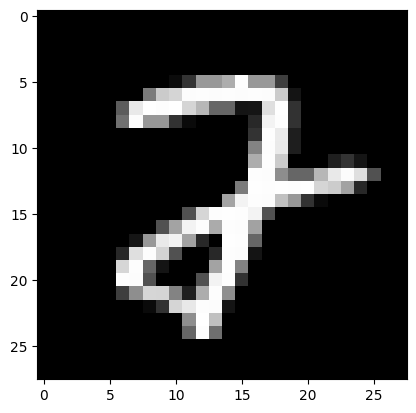

========================= 18 ===============================
test id: 610
individual experts pred: {2: 1, 4: 4, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


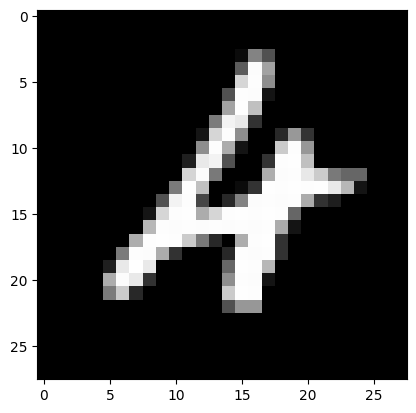

========================= 19 ===============================
test id: 629
individual experts pred: {2: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


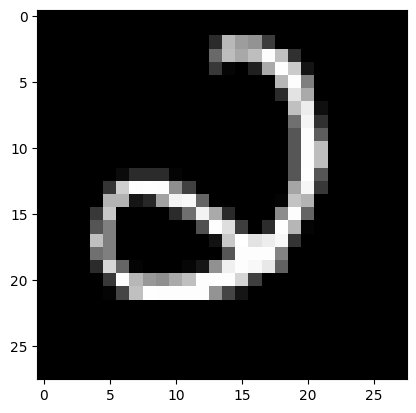

========================= 20 ===============================
test id: 659
individual experts pred: {1: 1, 2: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


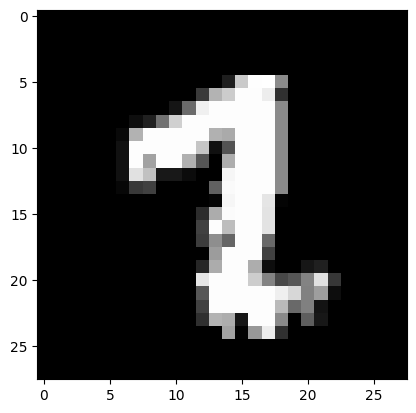

========================= 21 ===============================
test id: 674
individual experts pred: {3: 1, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


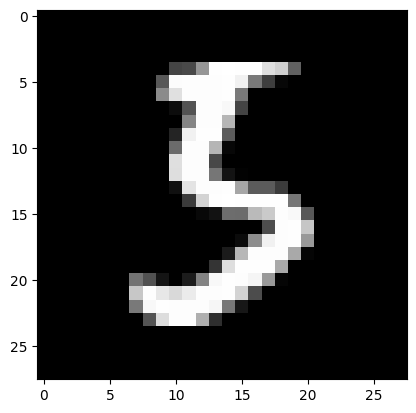

========================= 22 ===============================
test id: 684
individual experts pred: {3: 2, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


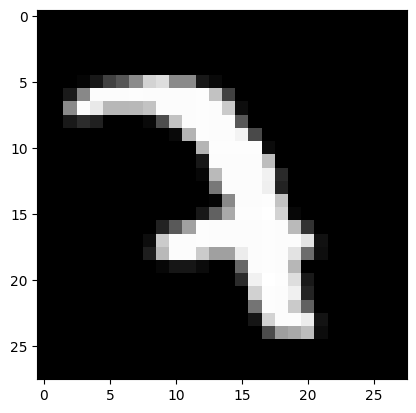

========================= 23 ===============================
test id: 691
individual experts pred: {4: 4, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


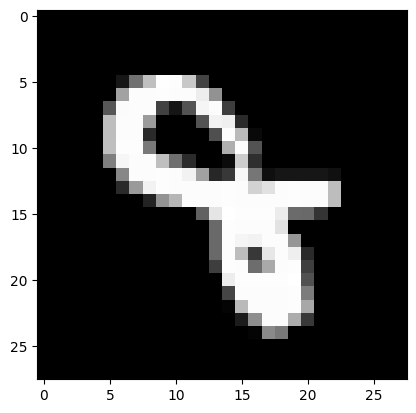

========================= 24 ===============================
test id: 717
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


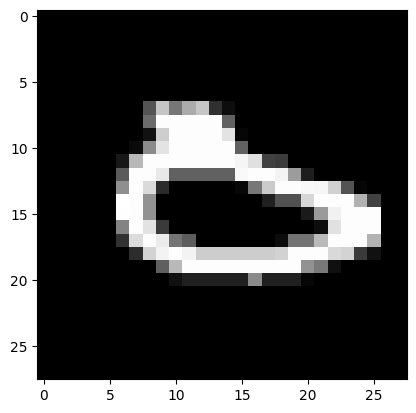

========================= 25 ===============================
test id: 720
individual experts pred: {5: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


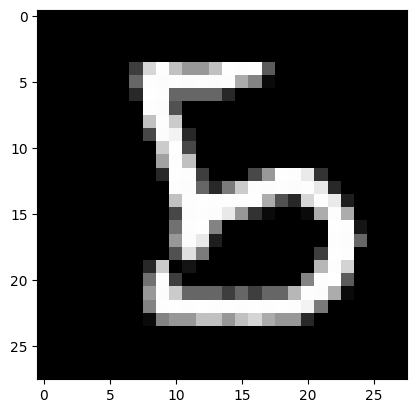

========================= 26 ===============================
test id: 726
individual experts pred: {7: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


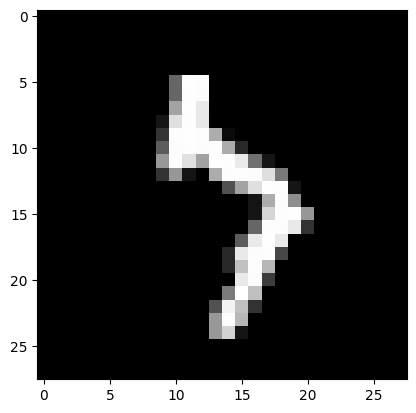

========================= 27 ===============================
test id: 740
individual experts pred: {4: 3, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


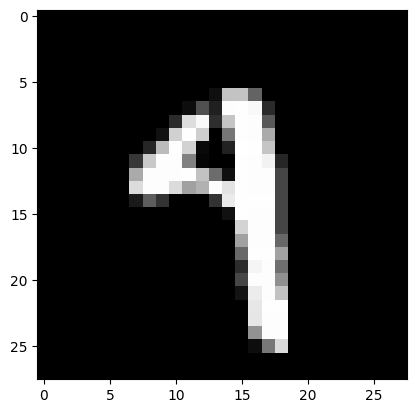

========================= 28 ===============================
test id: 800
individual experts pred: {8: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


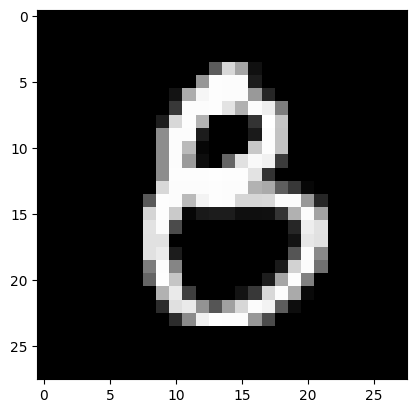

========================= 29 ===============================
test id: 813
individual experts pred: {8: 2, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


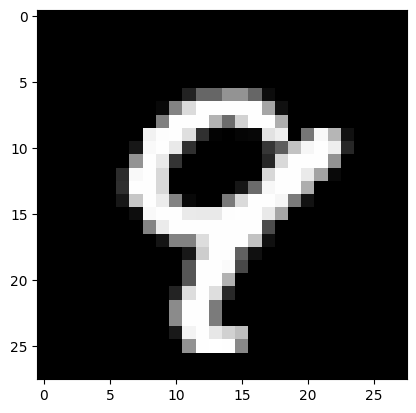

========================= 30 ===============================
test id: 866
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


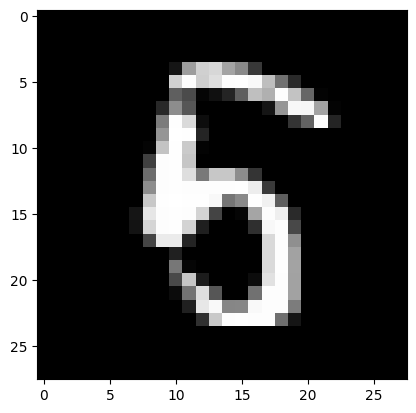

========================= 31 ===============================
test id: 877
individual experts pred: {8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


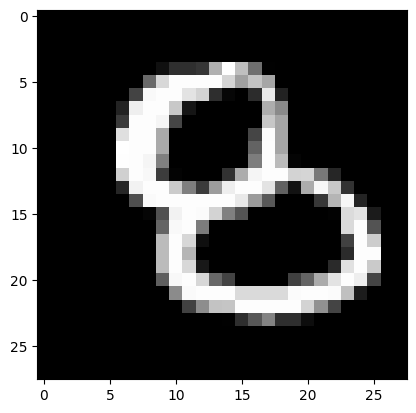

========================= 32 ===============================
test id: 882
individual experts pred: {9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


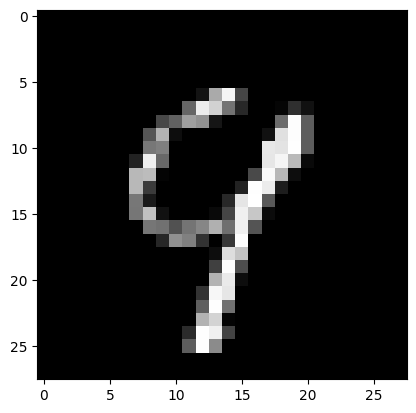

========================= 33 ===============================
test id: 883
individual experts pred: {3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


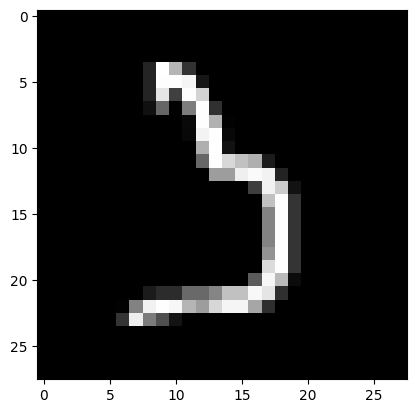

========================= 34 ===============================
test id: 900
individual experts pred: {1: 4, 3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


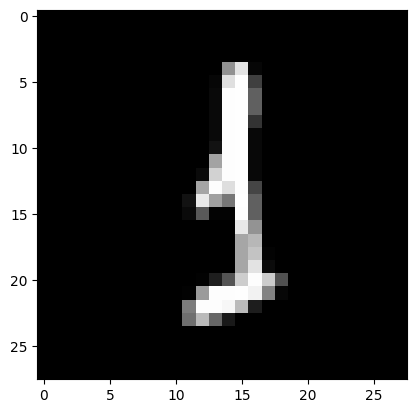

========================= 35 ===============================
test id: 924
individual experts pred: {2: 1, 7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


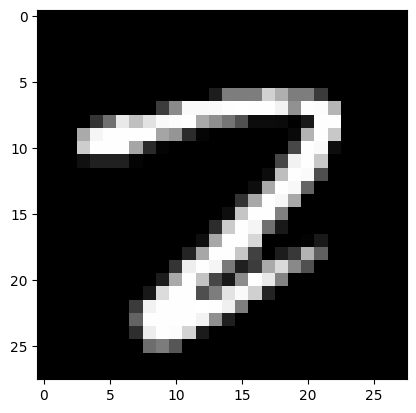

========================= 36 ===============================
test id: 947
individual experts pred: {8: 3, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


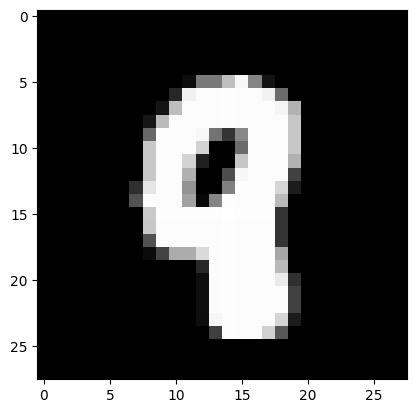

========================= 37 ===============================
test id: 951
individual experts pred: {4: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


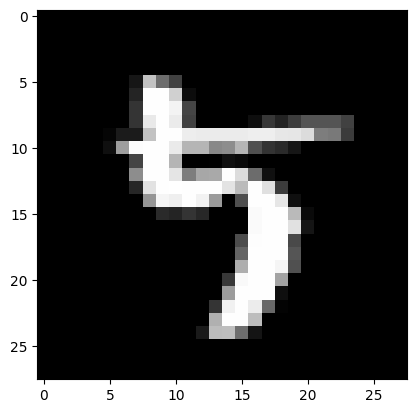

========================= 38 ===============================
test id: 956
individual experts pred: {2: 1, 3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


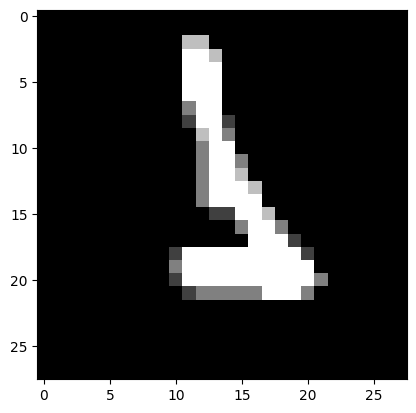

========================= 39 ===============================
test id: 959
individual experts pred: {4: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


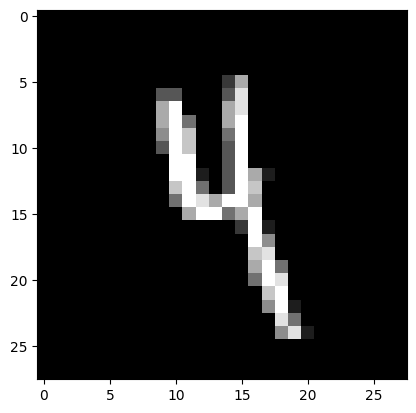

========================= 40 ===============================
test id: 965
individual experts pred: {0: 1, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


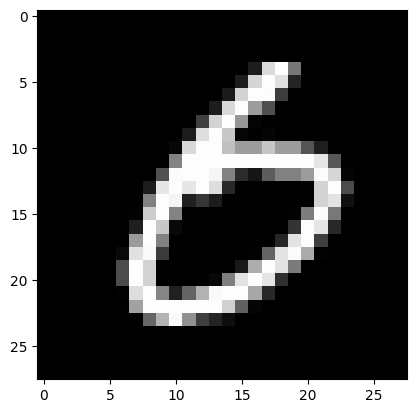

========================= 41 ===============================
test id: 990
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


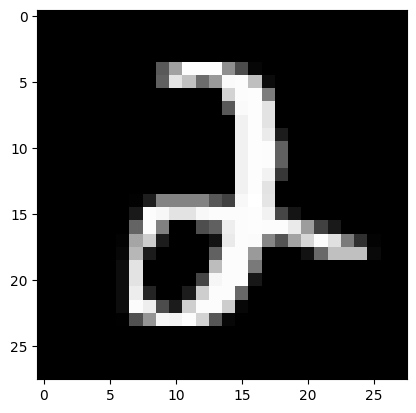

========================= 42 ===============================
test id: 1032
individual experts pred: {5: 1, 6: 1, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


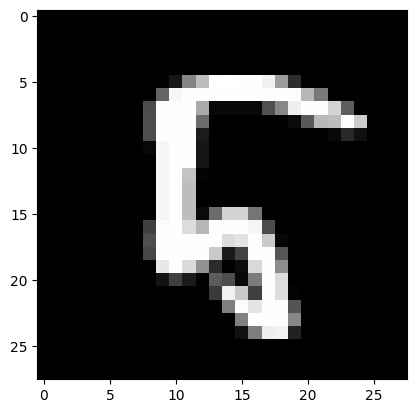

========================= 43 ===============================
test id: 1039
individual experts pred: {7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


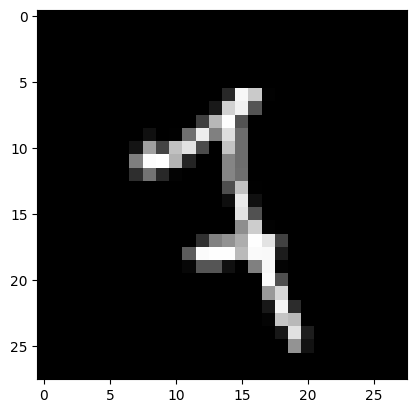

========================= 44 ===============================
test id: 1062
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


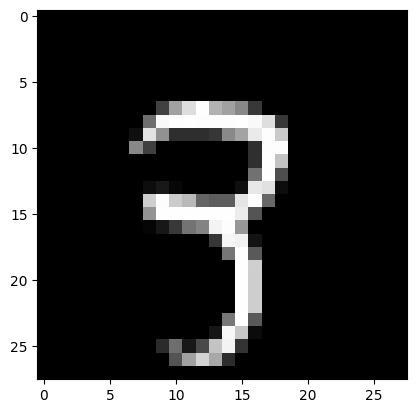

========================= 45 ===============================
test id: 1107
individual experts pred: {3: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


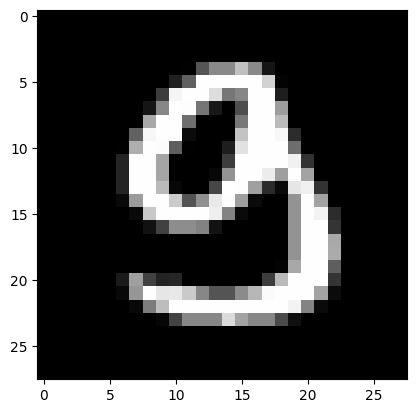

========================= 46 ===============================
test id: 1128
individual experts pred: {3: 2, 7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


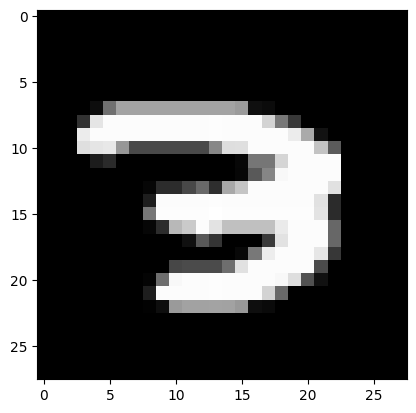

========================= 47 ===============================
test id: 1156
individual experts pred: {7: 3, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


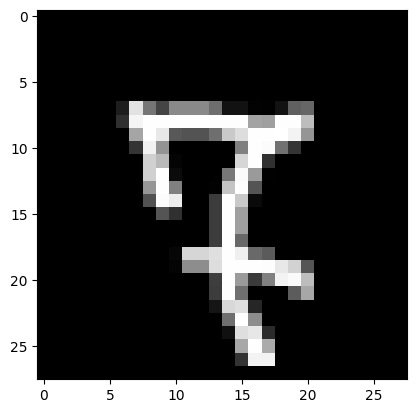

========================= 48 ===============================
test id: 1166
individual experts pred: {3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


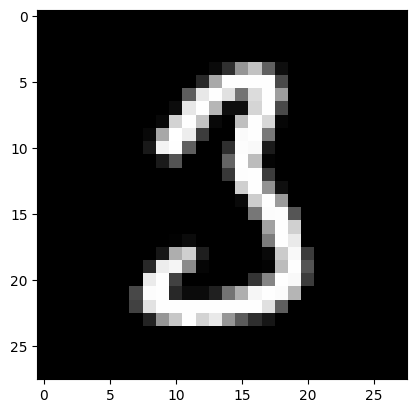

========================= 49 ===============================
test id: 1178
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


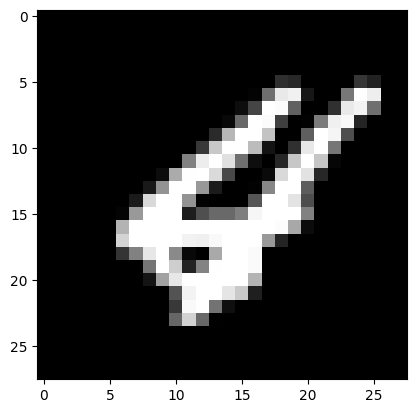

========================= 50 ===============================
test id: 1181
individual experts pred: {1: 4, 6: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


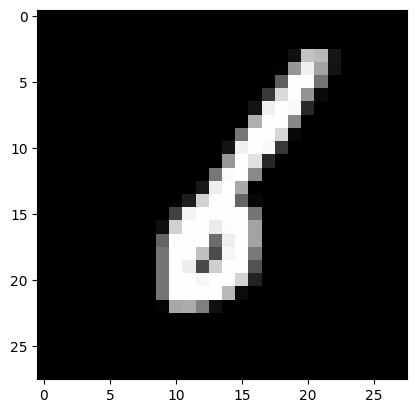

========================= 51 ===============================
test id: 1191
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


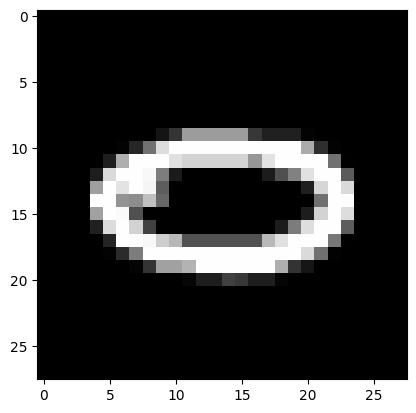

========================= 52 ===============================
test id: 1192
individual experts pred: {4: 2, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


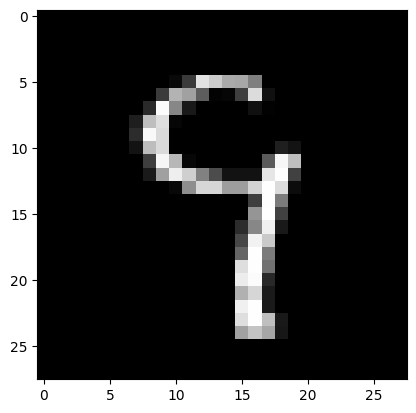

========================= 53 ===============================
test id: 1194
individual experts pred: {7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


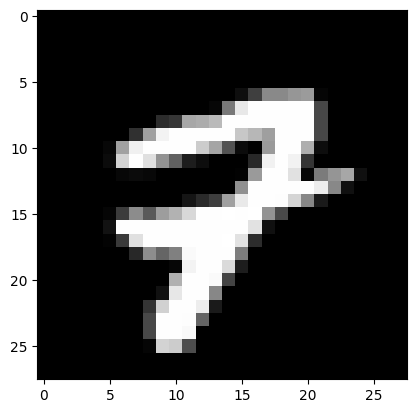

========================= 54 ===============================
test id: 1224
individual experts pred: {2: 4, 4: 1, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


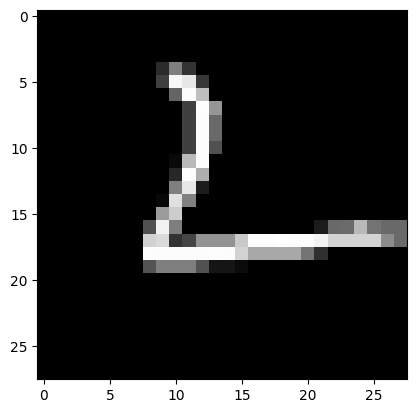

========================= 55 ===============================
test id: 1232
individual experts pred: {4: 3, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


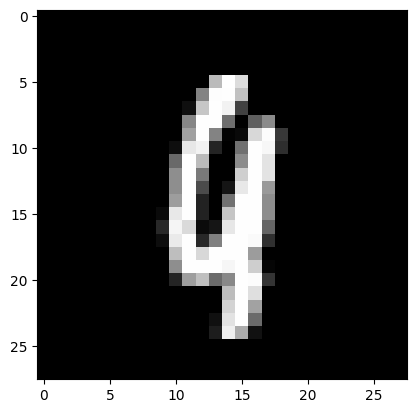

========================= 56 ===============================
test id: 1247
individual experts pred: {3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


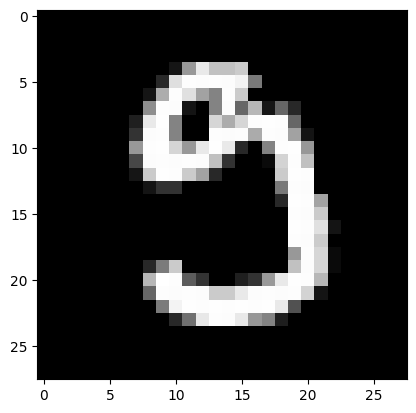

========================= 57 ===============================
test id: 1251
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


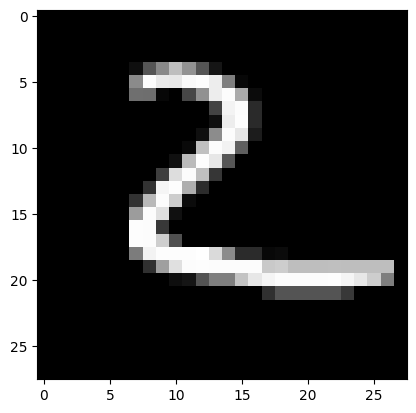

========================= 58 ===============================
test id: 1252
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


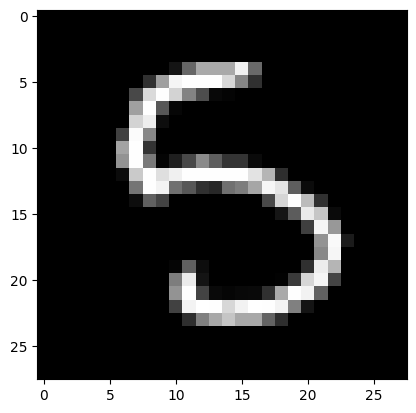

========================= 59 ===============================
test id: 1260
individual experts pred: {1: 2, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


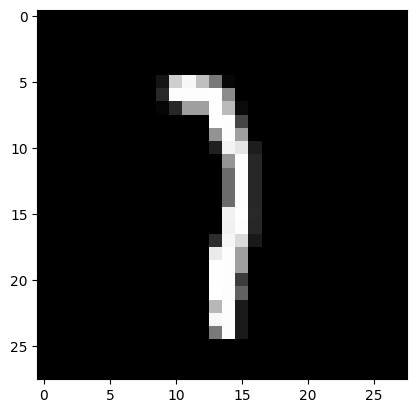

========================= 60 ===============================
test id: 1272
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


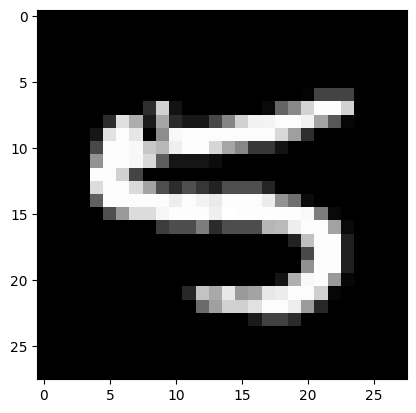

========================= 61 ===============================
test id: 1299
individual experts pred: {5: 3, 7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


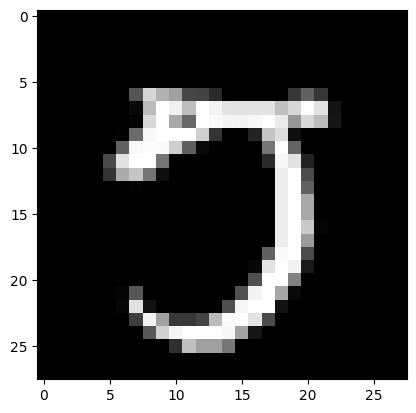

========================= 62 ===============================
test id: 1326
individual experts pred: {7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


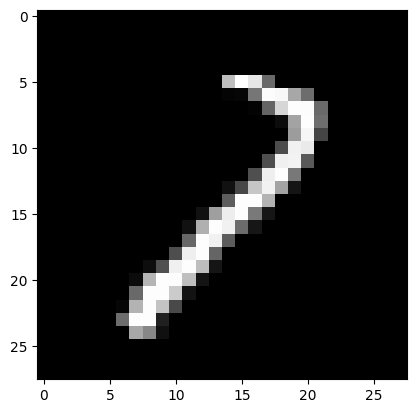

========================= 63 ===============================
test id: 1328
individual experts pred: {8: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


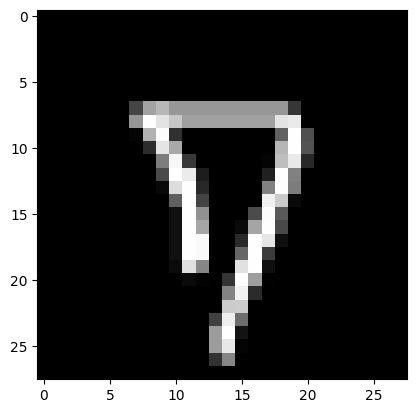

========================= 64 ===============================
test id: 1378
individual experts pred: {5: 3, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


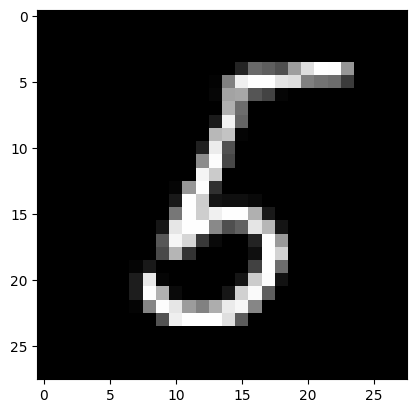

========================= 65 ===============================
test id: 1393
individual experts pred: {3: 3, 5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


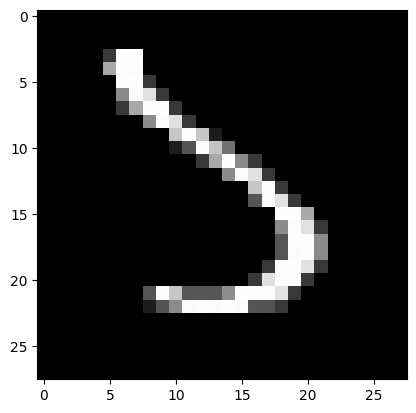

========================= 66 ===============================
test id: 1413
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


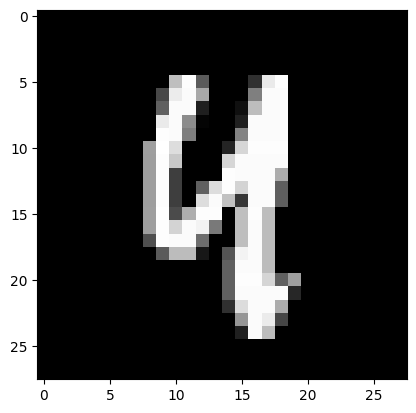

========================= 67 ===============================
test id: 1414
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


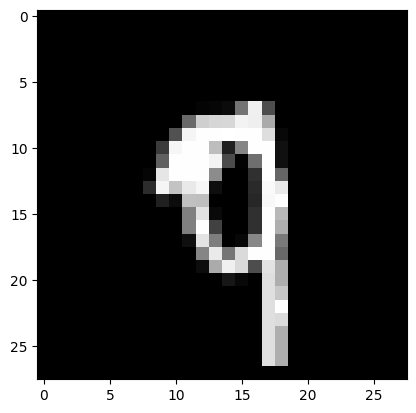

========================= 68 ===============================
test id: 1444
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


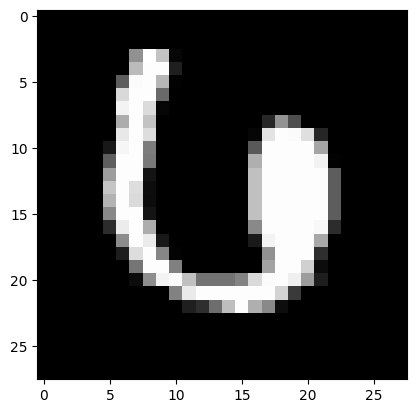

========================= 69 ===============================
test id: 1466
individual experts pred: {3: 2, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


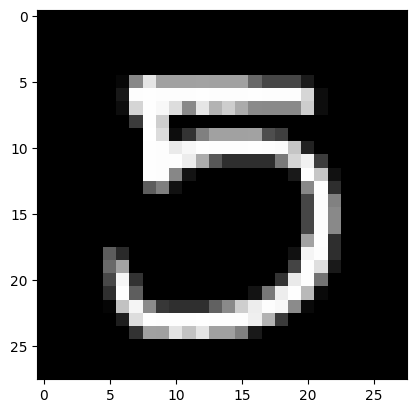

========================= 70 ===============================
test id: 1467
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


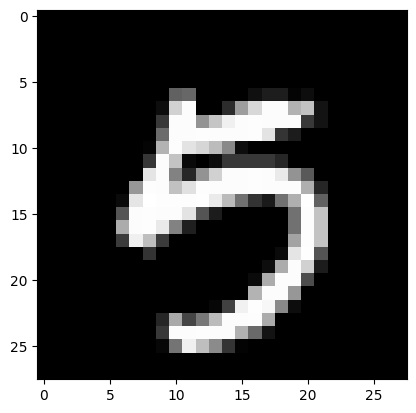

========================= 71 ===============================
test id: 1494
individual experts pred: {7: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


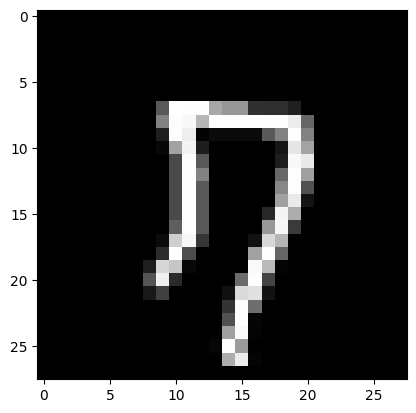

========================= 72 ===============================
test id: 1500
individual experts pred: {1: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


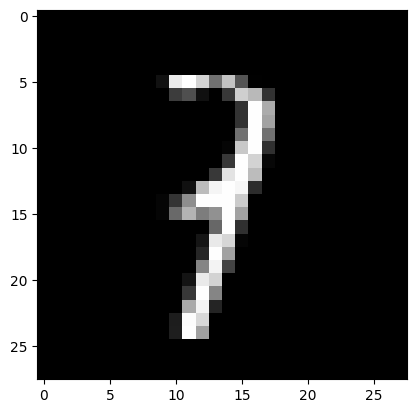

========================= 73 ===============================
test id: 1522
individual experts pred: {7: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


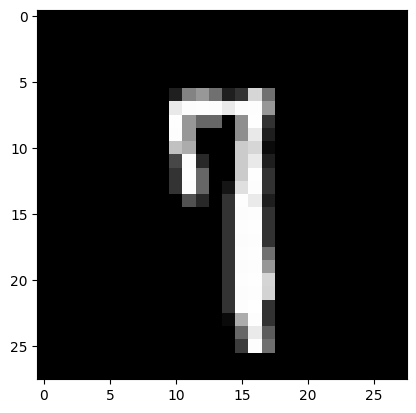

========================= 74 ===============================
test id: 1527
individual experts pred: {1: 3, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


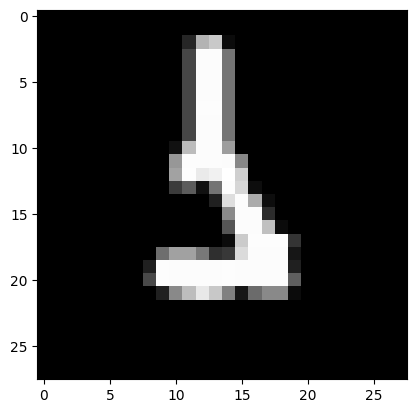

========================= 75 ===============================
test id: 1553
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


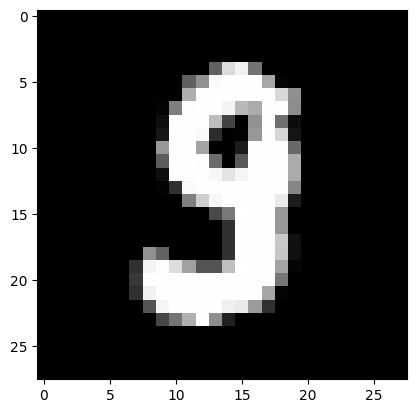

========================= 76 ===============================
test id: 1554
individual experts pred: {8: 4, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


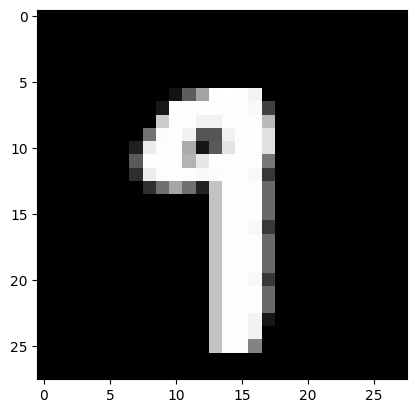

========================= 77 ===============================
test id: 1609
individual experts pred: {3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


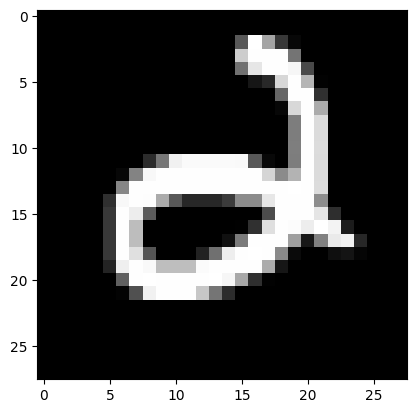

========================= 78 ===============================
test id: 1611
individual experts pred: {3: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


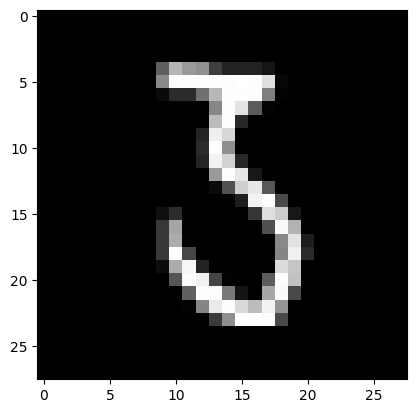

========================= 79 ===============================
test id: 1626
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


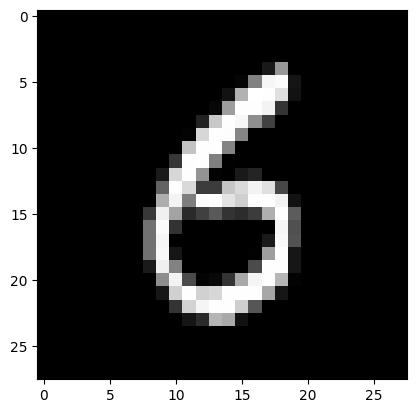

========================= 80 ===============================
test id: 1641
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


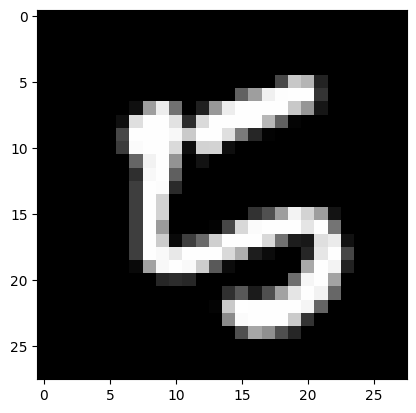

========================= 81 ===============================
test id: 1678
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


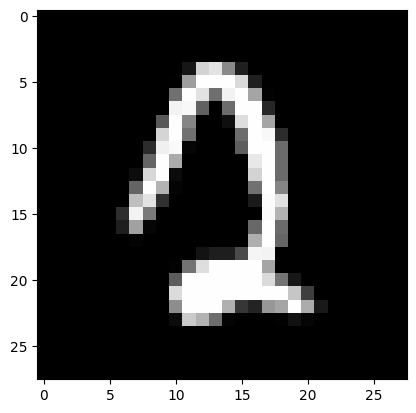

========================= 82 ===============================
test id: 1709
individual experts pred: {3: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


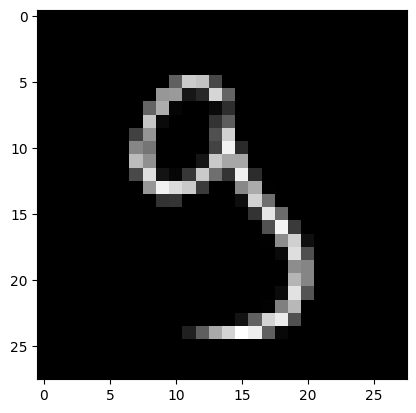

========================= 83 ===============================
test id: 1717
individual experts pred: {0: 3, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


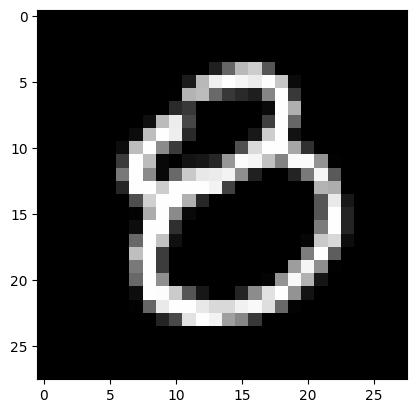

========================= 84 ===============================
test id: 1721
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


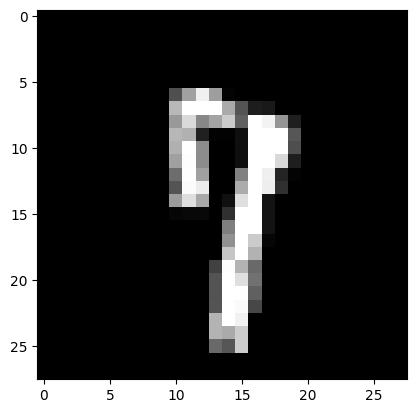

========================= 85 ===============================
test id: 1737
individual experts pred: {5: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


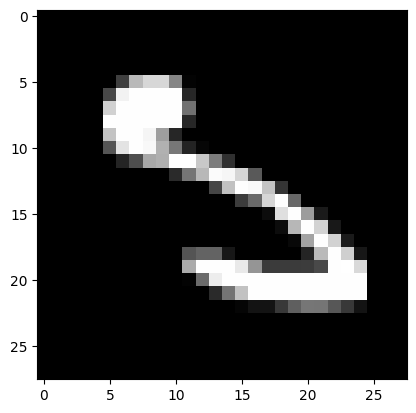

========================= 86 ===============================
test id: 1751
individual experts pred: {2: 2, 4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


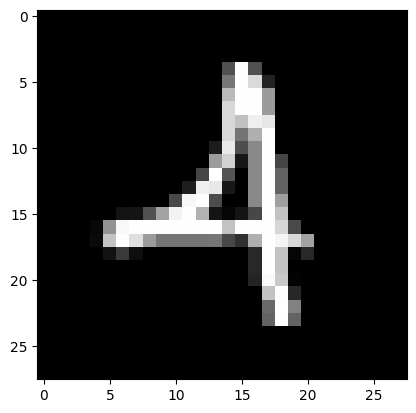

========================= 87 ===============================
test id: 1754
individual experts pred: {2: 2, 7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


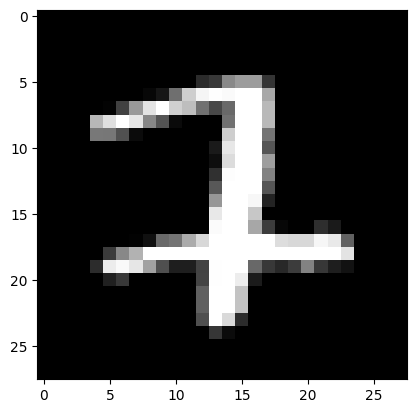

========================= 88 ===============================
test id: 1790
individual experts pred: {2: 1, 8: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


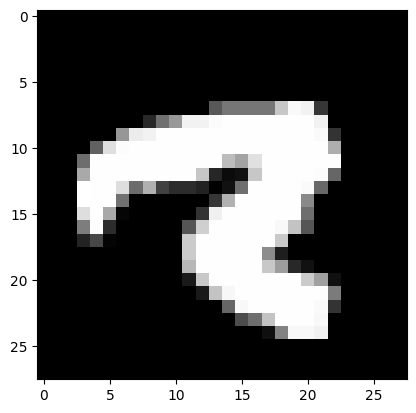

========================= 89 ===============================
test id: 1800
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


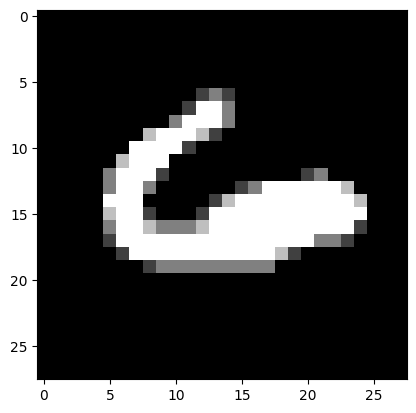

========================= 90 ===============================
test id: 1828
individual experts pred: {3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


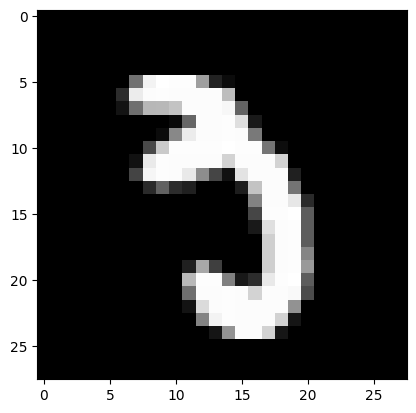

========================= 91 ===============================
test id: 1865
individual experts pred: {4: 3, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


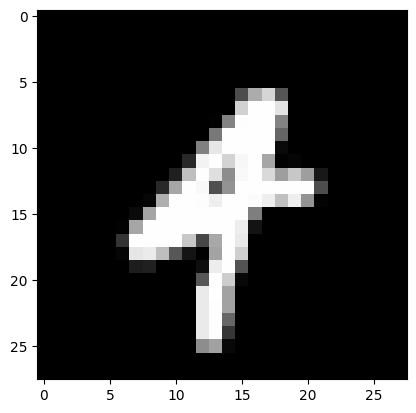

========================= 92 ===============================
test id: 1871
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


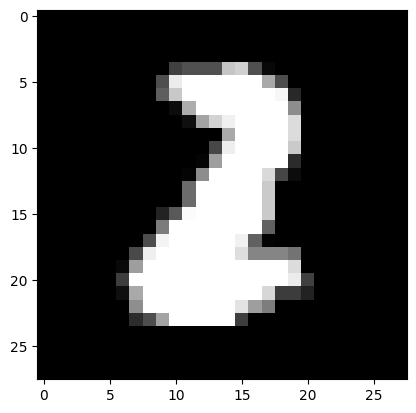

========================= 93 ===============================
test id: 1878
individual experts pred: {3: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


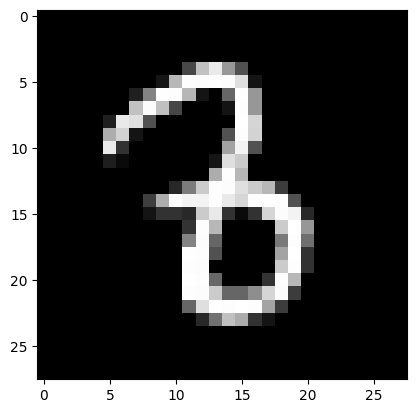

========================= 94 ===============================
test id: 1880
individual experts pred: {0: 1, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


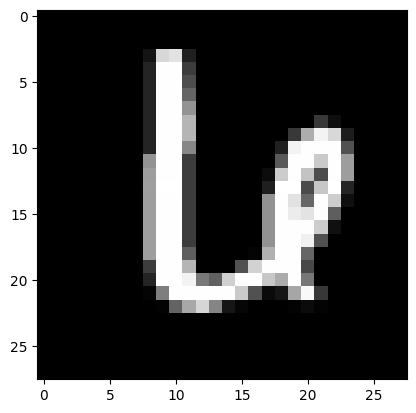

========================= 95 ===============================
test id: 1911
individual experts pred: {5: 4, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


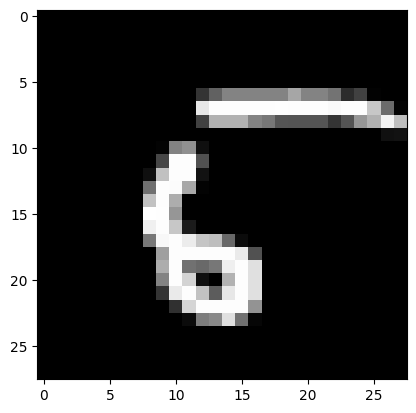

========================= 96 ===============================
test id: 1940
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


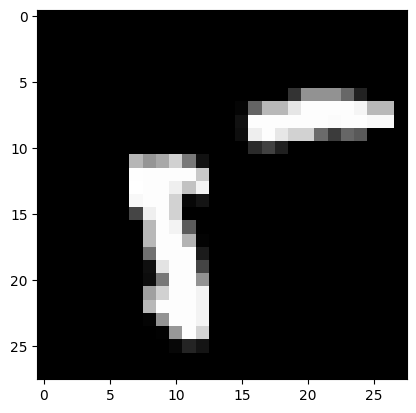

========================= 97 ===============================
test id: 1941
individual experts pred: {8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


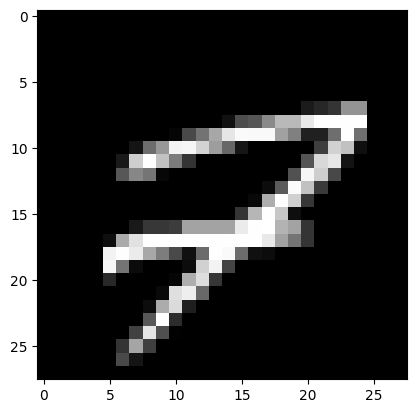

========================= 98 ===============================
test id: 1952
individual experts pred: {8: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


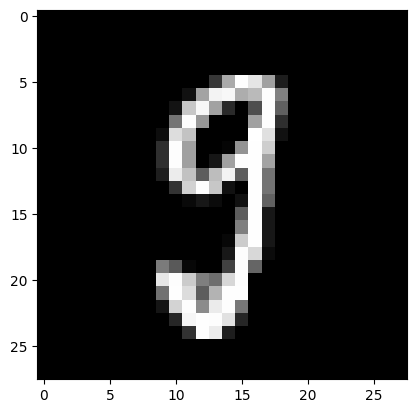

========================= 99 ===============================
test id: 1955
individual experts pred: {2: 2, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


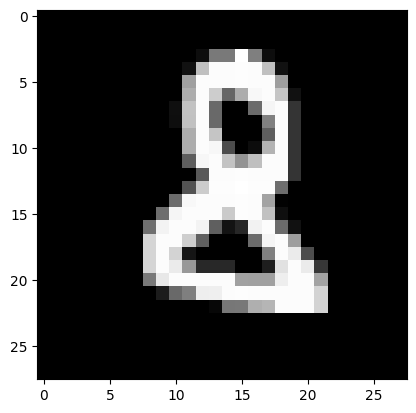

========================= 100 ===============================
test id: 1969
individual experts pred: {6: 4, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


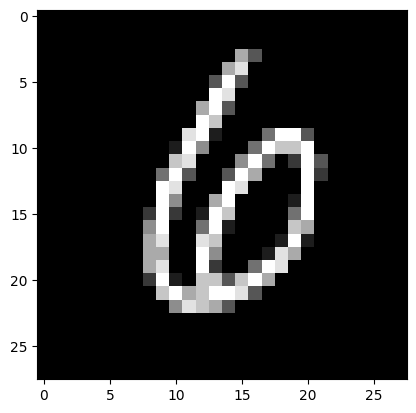

========================= 101 ===============================
test id: 1982
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


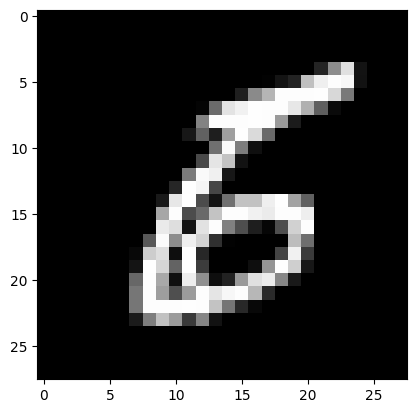

========================= 102 ===============================
test id: 1984
individual experts pred: {0: 1, 2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


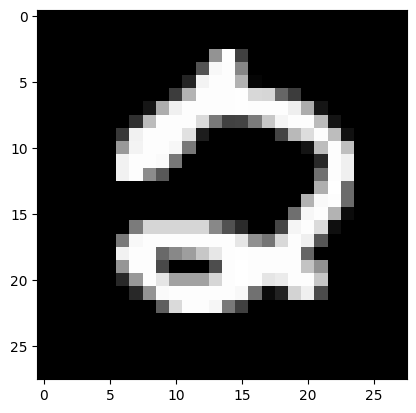

========================= 103 ===============================
test id: 1987
individual experts pred: {0: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


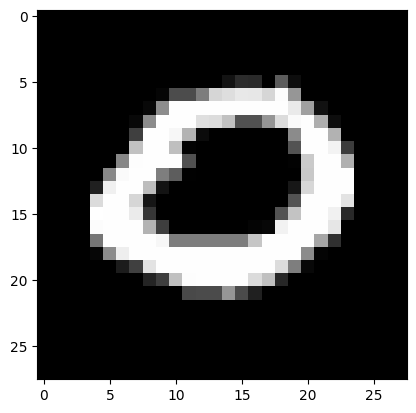

========================= 104 ===============================
test id: 2004
individual experts pred: {8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


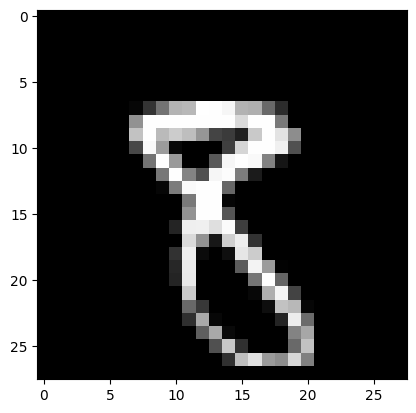

========================= 105 ===============================
test id: 2018
individual experts pred: {1: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


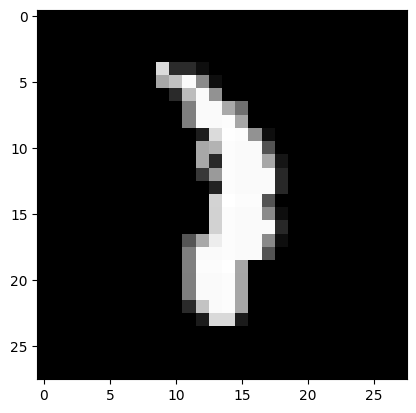

========================= 106 ===============================
test id: 2024
individual experts pred: {7: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


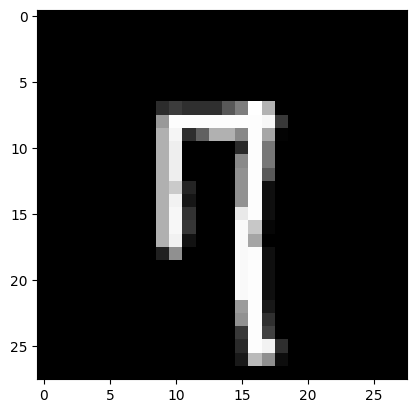

========================= 107 ===============================
test id: 2035
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


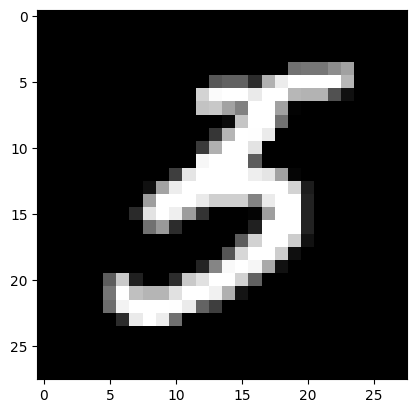

========================= 108 ===============================
test id: 2040
individual experts pred: {4: 1, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


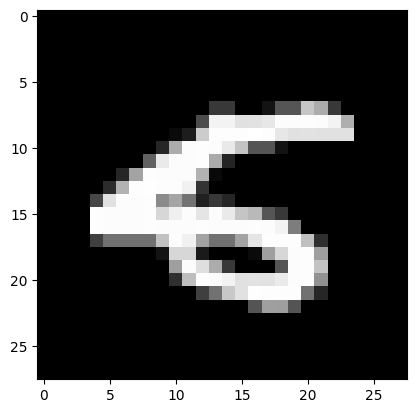

========================= 109 ===============================
test id: 2043
individual experts pred: {4: 3, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


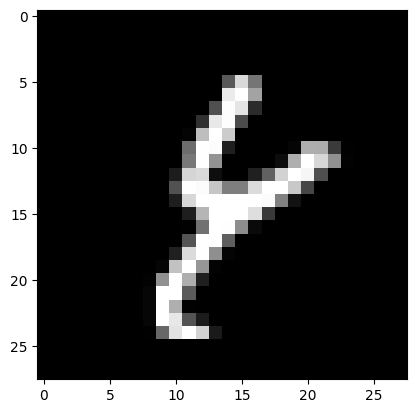

========================= 110 ===============================
test id: 2044
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


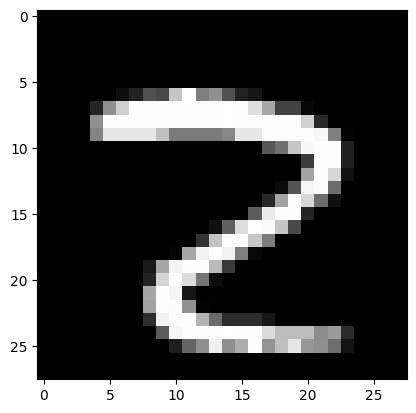

========================= 111 ===============================
test id: 2053
individual experts pred: {4: 2, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


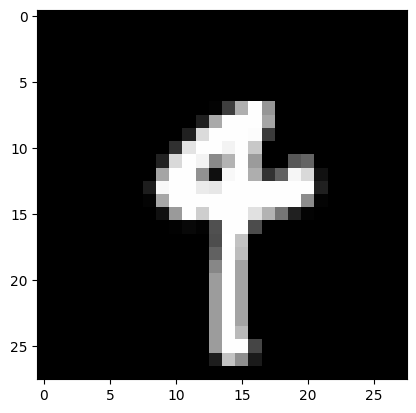

========================= 112 ===============================
test id: 2063
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


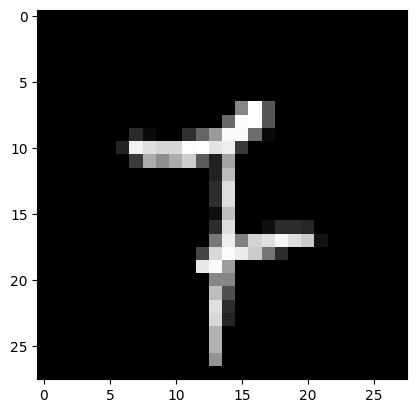

========================= 113 ===============================
test id: 2070
individual experts pred: {9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


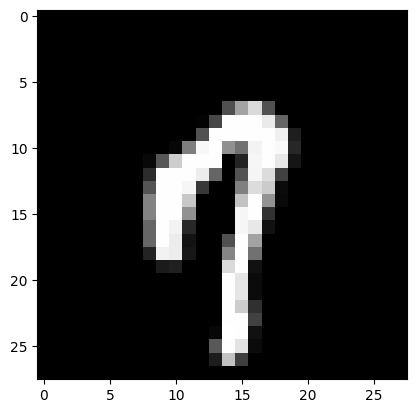

========================= 114 ===============================
test id: 2073
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


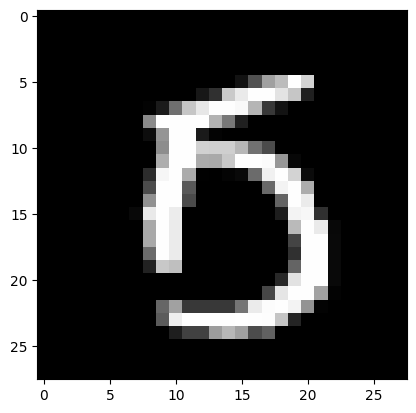

========================= 115 ===============================
test id: 2105
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


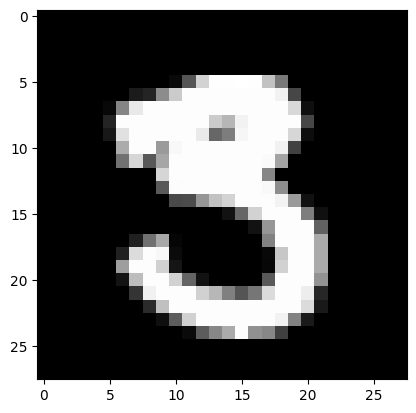

========================= 116 ===============================
test id: 2109
individual experts pred: {7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


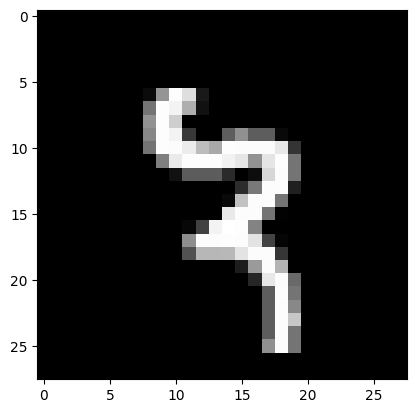

========================= 117 ===============================
test id: 2118
individual experts pred: {0: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


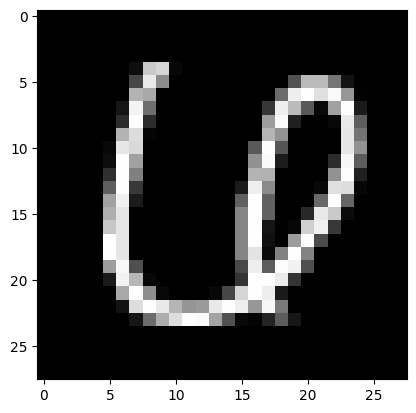

========================= 118 ===============================
test id: 2125
individual experts pred: {5: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


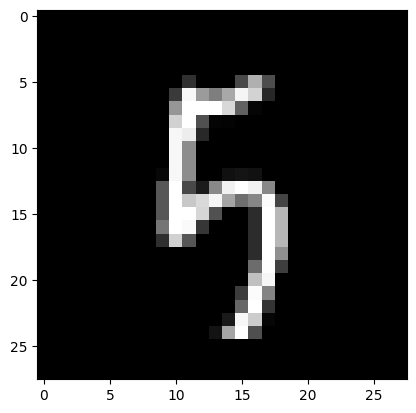

========================= 119 ===============================
test id: 2129
individual experts pred: {2: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


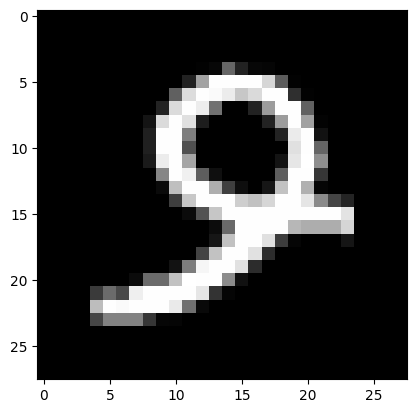

========================= 120 ===============================
test id: 2182
individual experts pred: {1: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


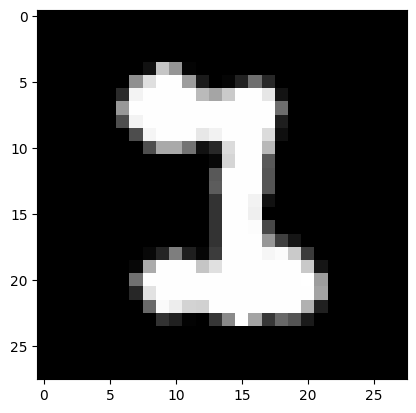

========================= 121 ===============================
test id: 2185
individual experts pred: {0: 2, 5: 1, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


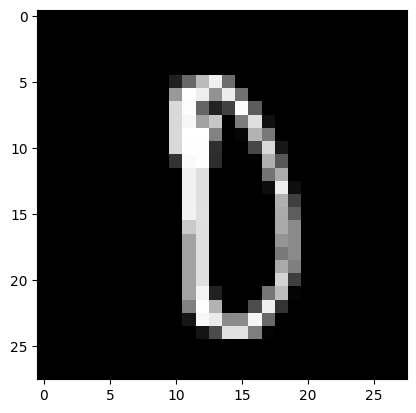

========================= 122 ===============================
test id: 2186
individual experts pred: {2: 4, 3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


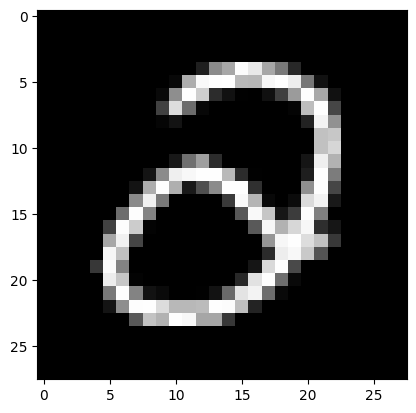

========================= 123 ===============================
test id: 2189
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


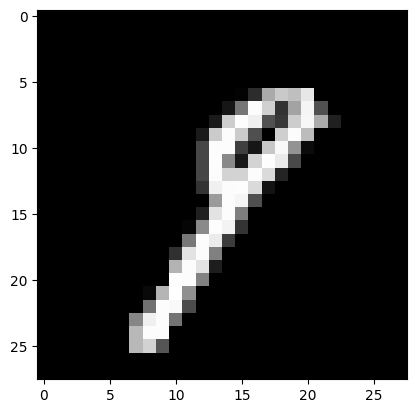

========================= 124 ===============================
test id: 2215
individual experts pred: {5: 2, 6: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


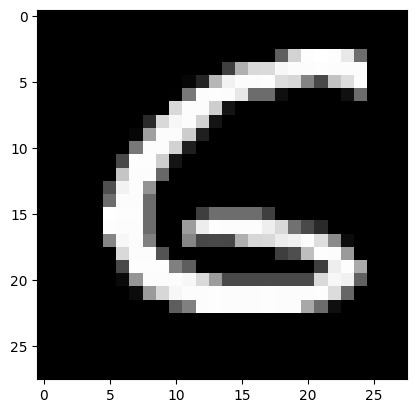

========================= 125 ===============================
test id: 2224
individual experts pred: {6: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


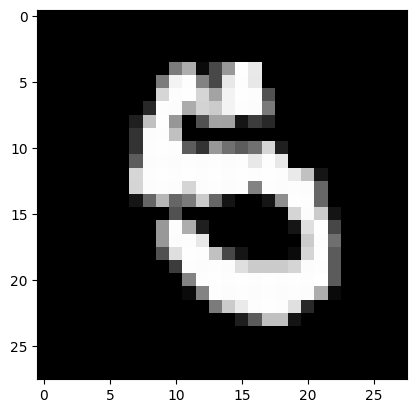

========================= 126 ===============================
test id: 2266
individual experts pred: {1: 3, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


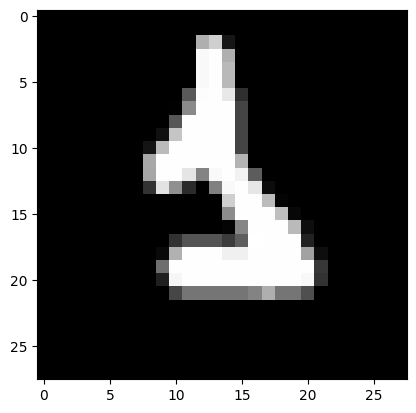

========================= 127 ===============================
test id: 2272
individual experts pred: {0: 3, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


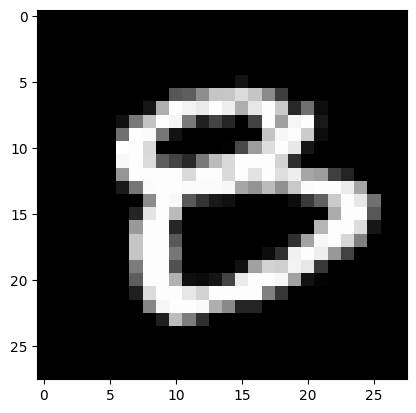

========================= 128 ===============================
test id: 2293
individual experts pred: {0: 1, 6: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


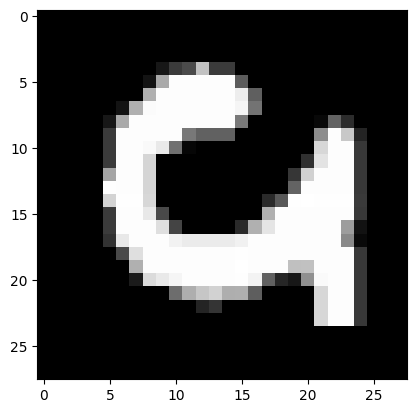

========================= 129 ===============================
test id: 2299
individual experts pred: {2: 4, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


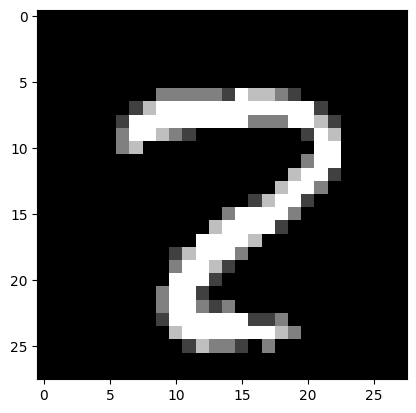

========================= 130 ===============================
test id: 2326
individual experts pred: {0: 4, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


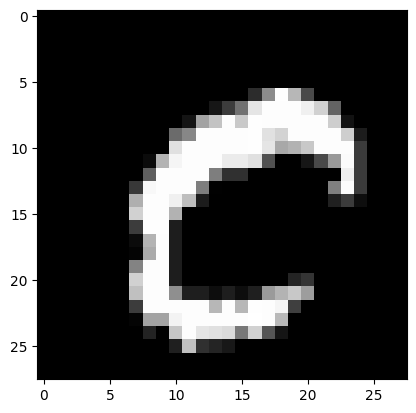

========================= 131 ===============================
test id: 2333
individual experts pred: {0: 3, 2: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


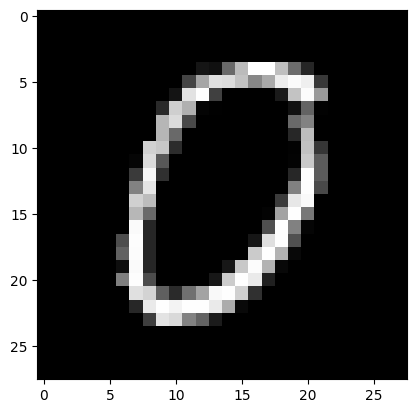

========================= 132 ===============================
test id: 2369
individual experts pred: {5: 1, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


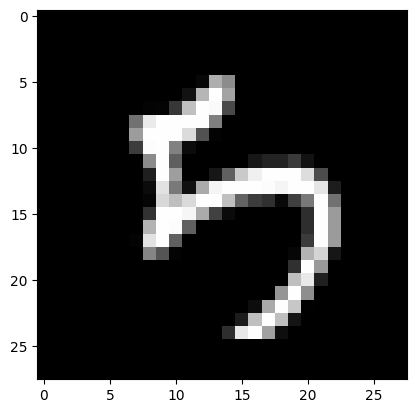

========================= 133 ===============================
test id: 2395
individual experts pred: {3: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


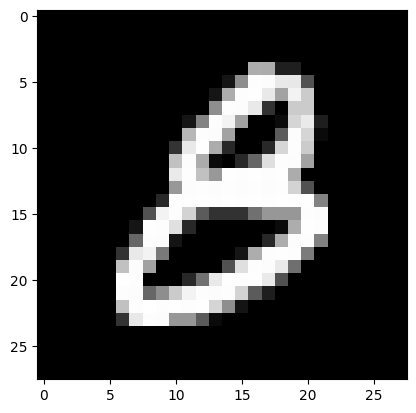

========================= 134 ===============================
test id: 2405
individual experts pred: {2: 1, 3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


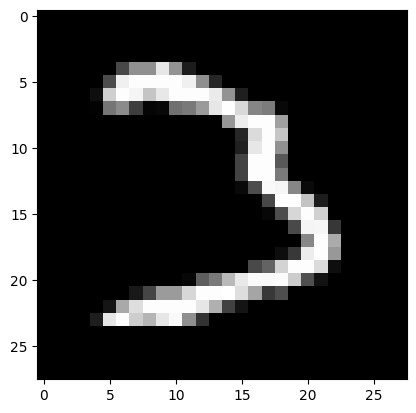

========================= 135 ===============================
test id: 2406
individual experts pred: {8: 4, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


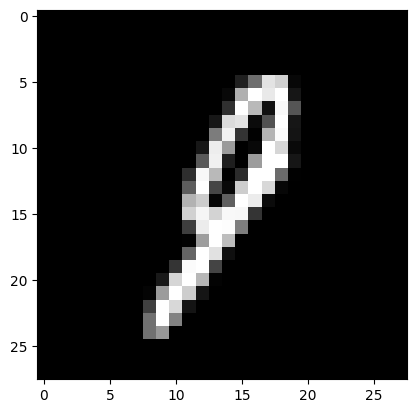

========================= 136 ===============================
test id: 2408
individual experts pred: {3: 4, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


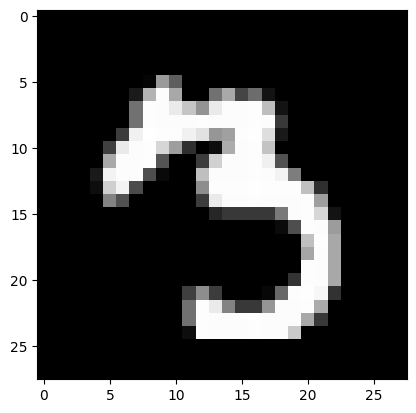

========================= 137 ===============================
test id: 2414
individual experts pred: {4: 3, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


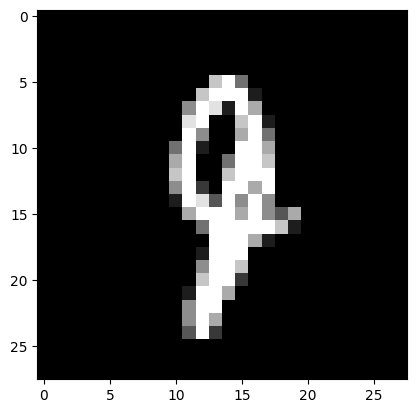

========================= 138 ===============================
test id: 2454
individual experts pred: {6: 4, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


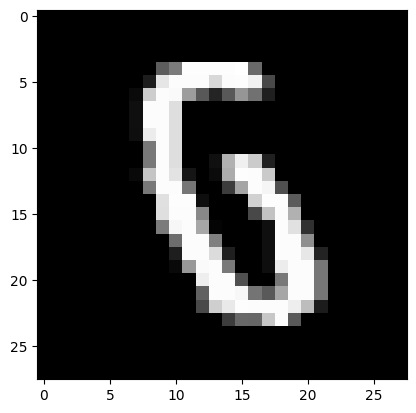

========================= 139 ===============================
test id: 2455
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


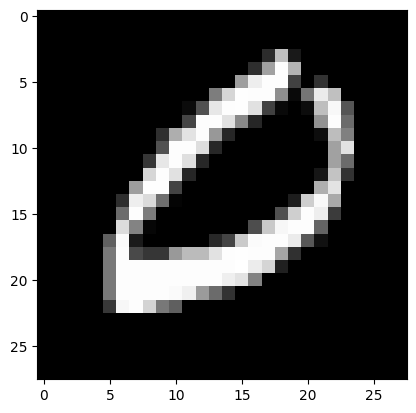

========================= 140 ===============================
test id: 2462
individual experts pred: {2: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


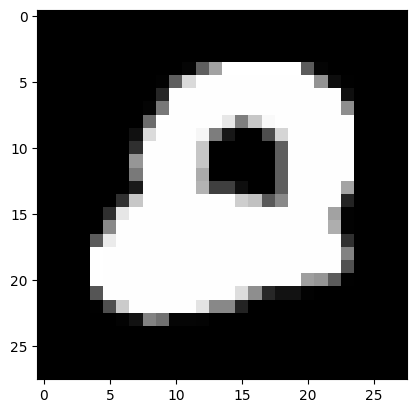

========================= 141 ===============================
test id: 2488
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


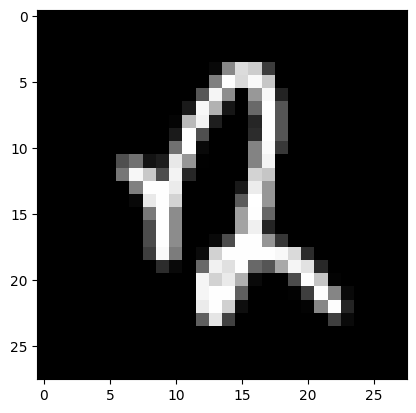

========================= 142 ===============================
test id: 2514
individual experts pred: {4: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


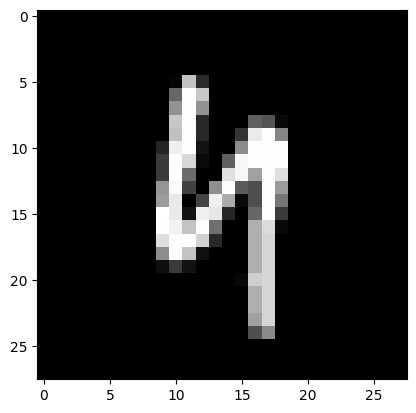

========================= 143 ===============================
test id: 2560
individual experts pred: {3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


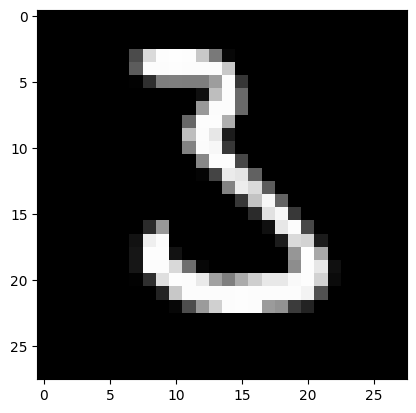

========================= 144 ===============================
test id: 2573
individual experts pred: {5: 1, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


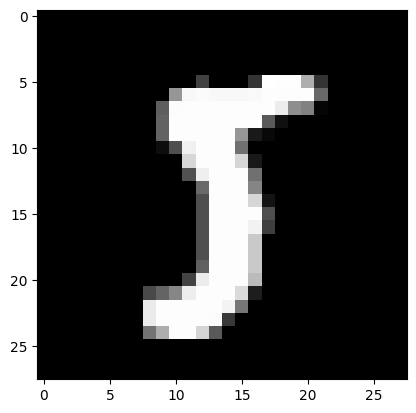

========================= 145 ===============================
test id: 2574
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


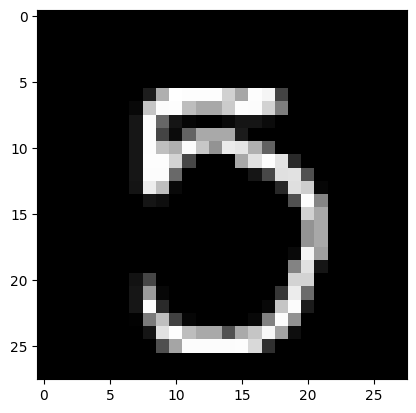

========================= 146 ===============================
test id: 2582
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


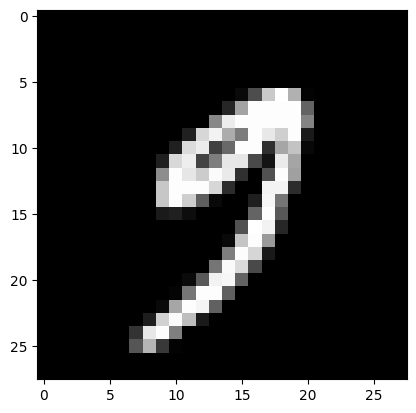

========================= 147 ===============================
test id: 2597
individual experts pred: {3: 3, 5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


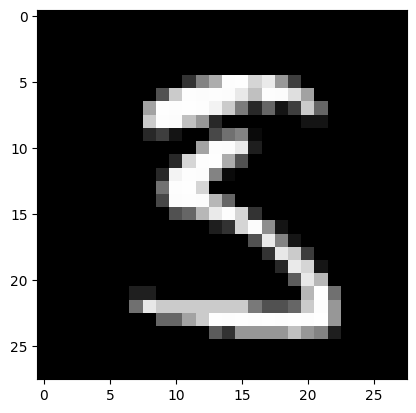

========================= 148 ===============================
test id: 2607
individual experts pred: {1: 1, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


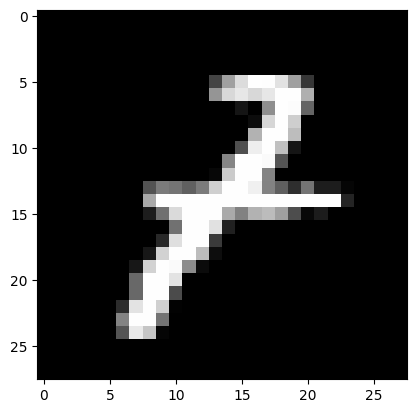

========================= 149 ===============================
test id: 2617
individual experts pred: {7: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


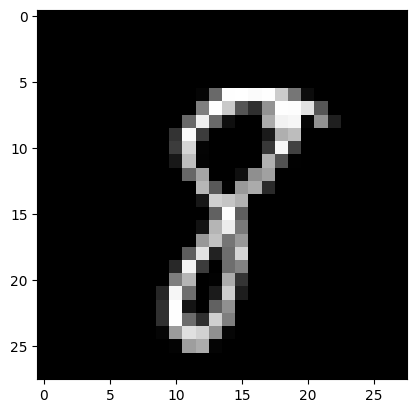

========================= 150 ===============================
test id: 2648
individual experts pred: {0: 4, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


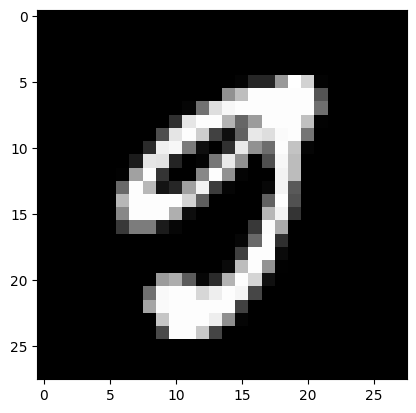

========================= 151 ===============================
test id: 2713
individual experts pred: {0: 4, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


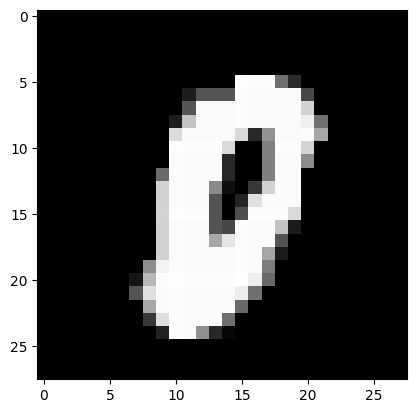

========================= 152 ===============================
test id: 2720
individual experts pred: {4: 2, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


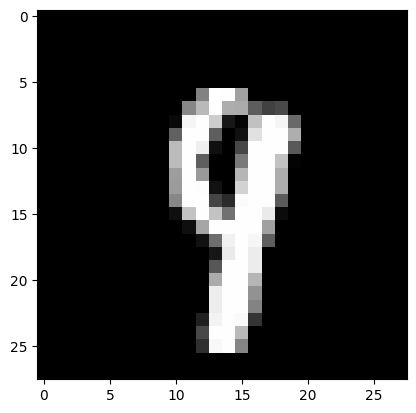

========================= 153 ===============================
test id: 2743
individual experts pred: {5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


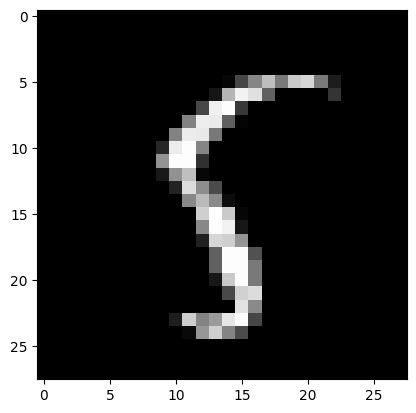

========================= 154 ===============================
test id: 2758
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


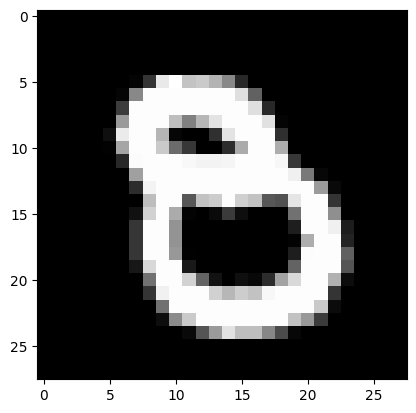

========================= 155 ===============================
test id: 2760
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


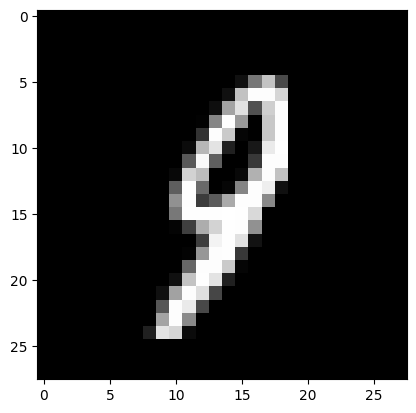

========================= 156 ===============================
test id: 2769
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


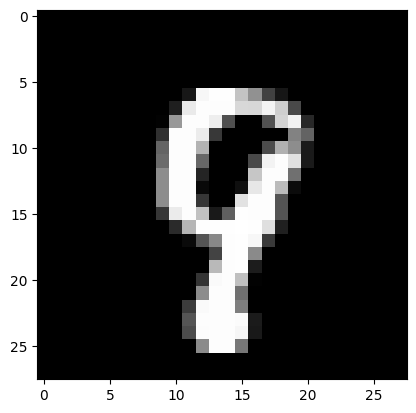

========================= 157 ===============================
test id: 2770
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


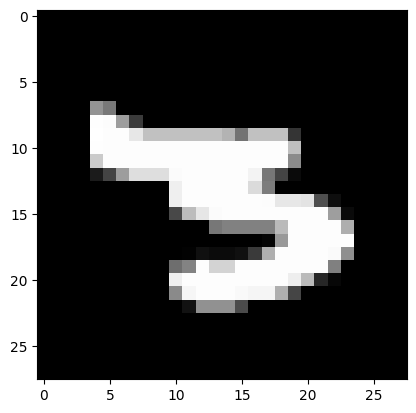

========================= 158 ===============================
test id: 2810
individual experts pred: {3: 4, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


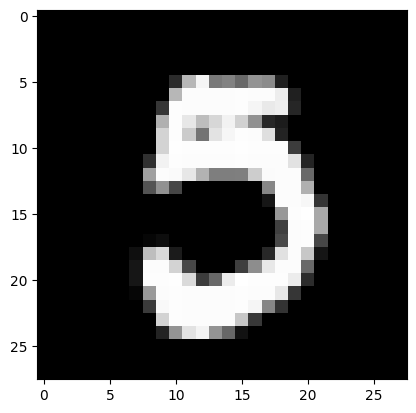

========================= 159 ===============================
test id: 2836
individual experts pred: {4: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


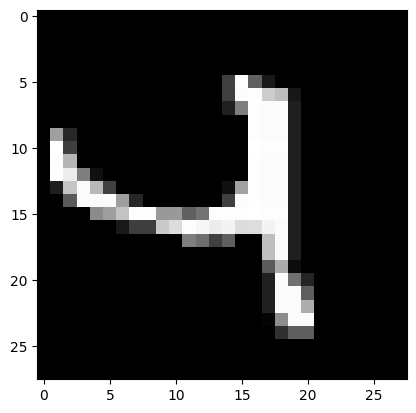

========================= 160 ===============================
test id: 2854
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


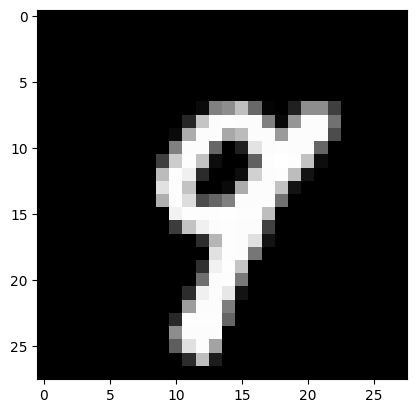

========================= 161 ===============================
test id: 2863
individual experts pred: {4: 3, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


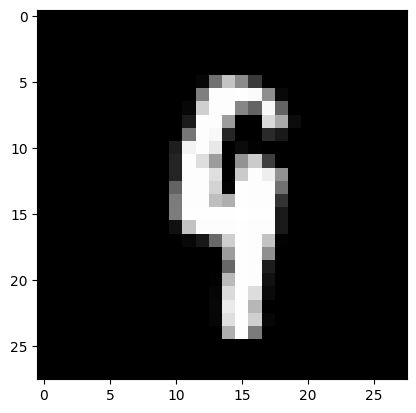

========================= 162 ===============================
test id: 2877
individual experts pred: {4: 1, 7: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


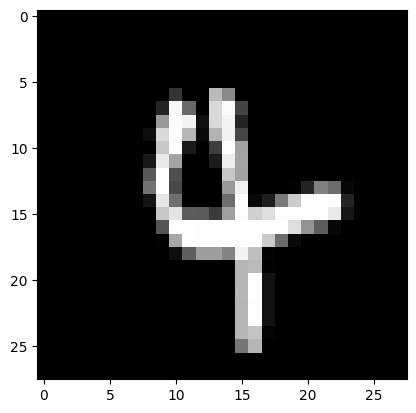

========================= 163 ===============================
test id: 2896
individual experts pred: {0: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


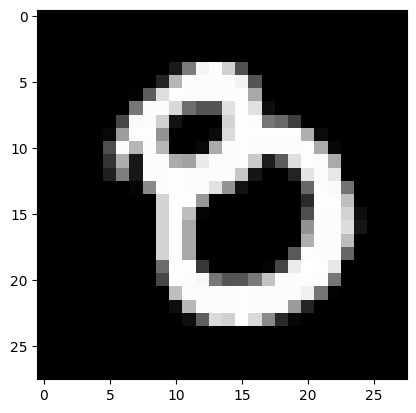

========================= 164 ===============================
test id: 2921
individual experts pred: {2: 3, 3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


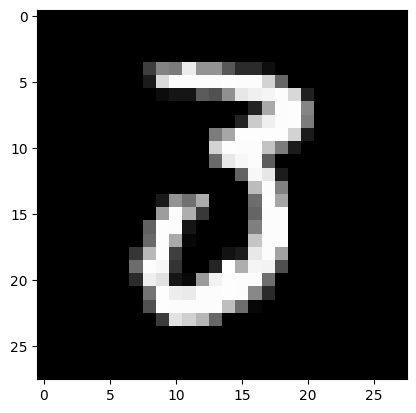

========================= 165 ===============================
test id: 2938
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


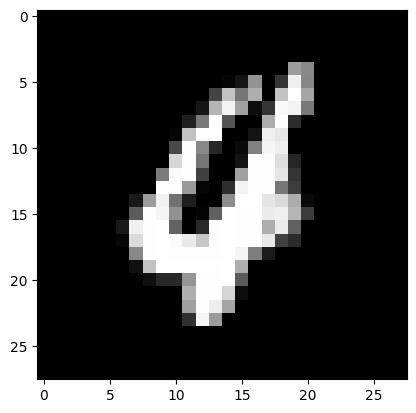

========================= 166 ===============================
test id: 2952
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


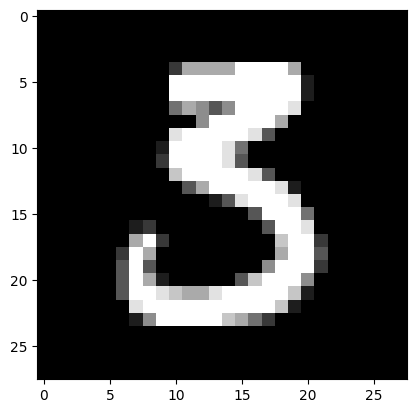

========================= 167 ===============================
test id: 2970
individual experts pred: {3: 2, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


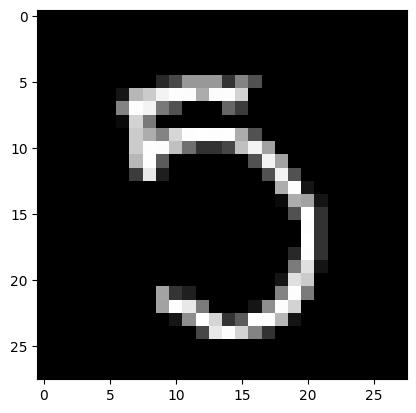

========================= 168 ===============================
test id: 2995
individual experts pred: {6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


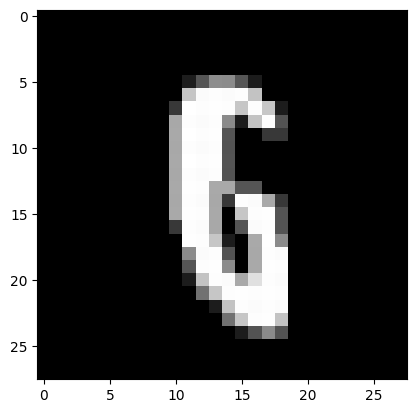

========================= 169 ===============================
test id: 3005
individual experts pred: {1: 1, 8: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


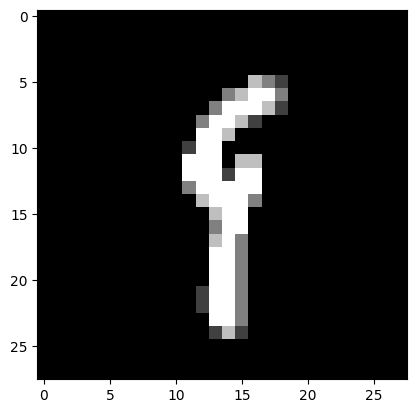

========================= 170 ===============================
test id: 3060
individual experts pred: {9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


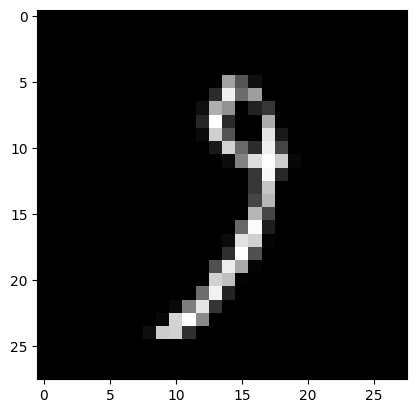

========================= 171 ===============================
test id: 3062
individual experts pred: {8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


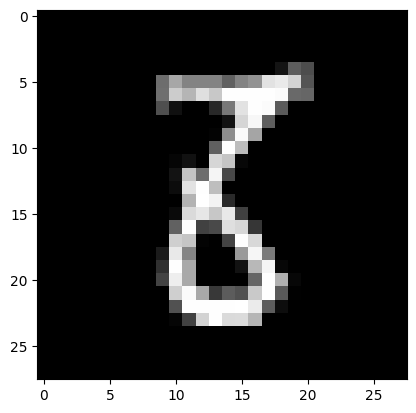

========================= 172 ===============================
test id: 3073
individual experts pred: {1: 2, 2: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


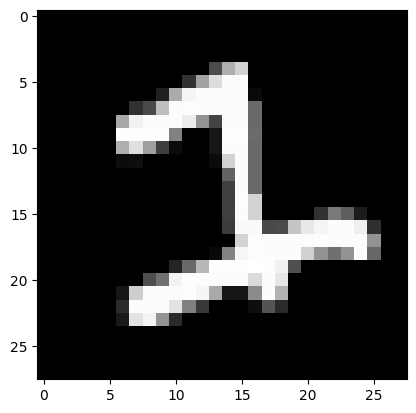

========================= 173 ===============================
test id: 3115
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


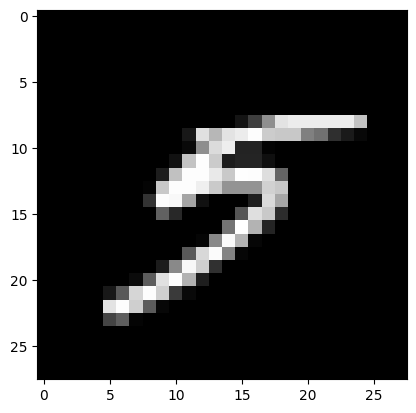

========================= 174 ===============================
test id: 3117
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


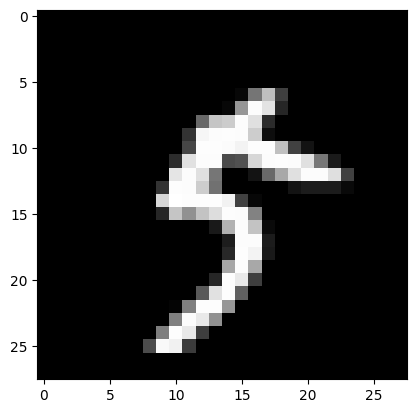

========================= 175 ===============================
test id: 3157
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


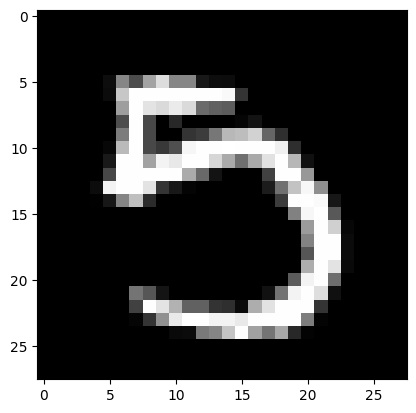

========================= 176 ===============================
test id: 3172
individual experts pred: {4: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


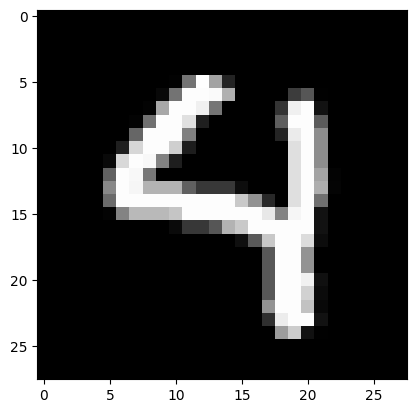

========================= 177 ===============================
test id: 3225
individual experts pred: {7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


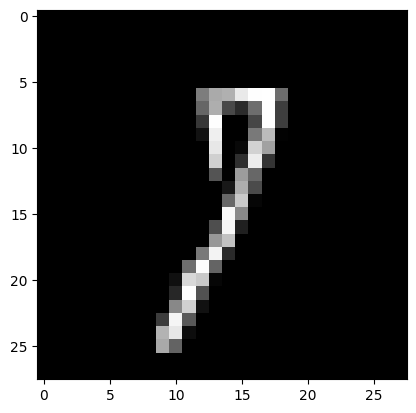

========================= 178 ===============================
test id: 3266
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


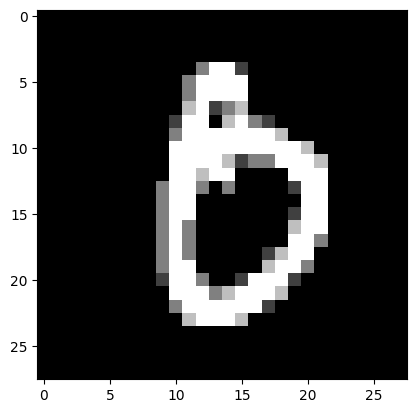

========================= 179 ===============================
test id: 3289
individual experts pred: {8: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


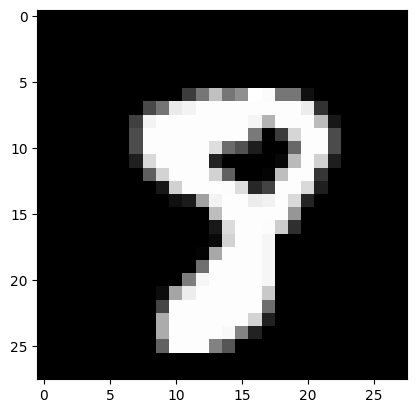

========================= 180 ===============================
test id: 3330
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


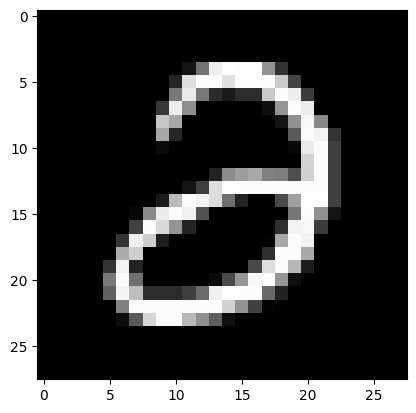

========================= 181 ===============================
test id: 3375
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


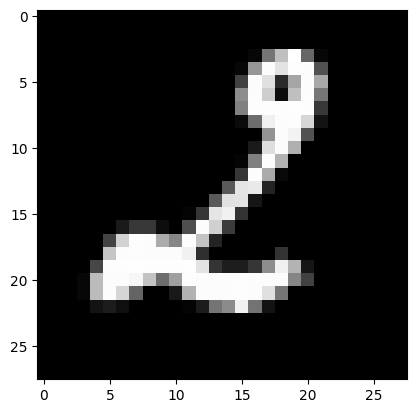

========================= 182 ===============================
test id: 3384
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


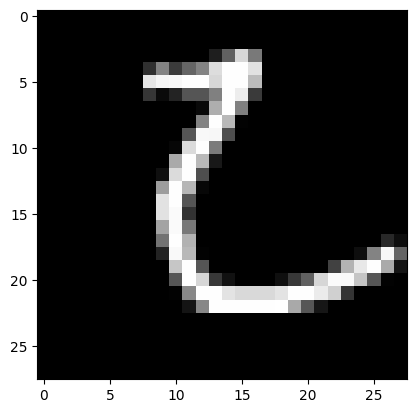

========================= 183 ===============================
test id: 3405
individual experts pred: {4: 3, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


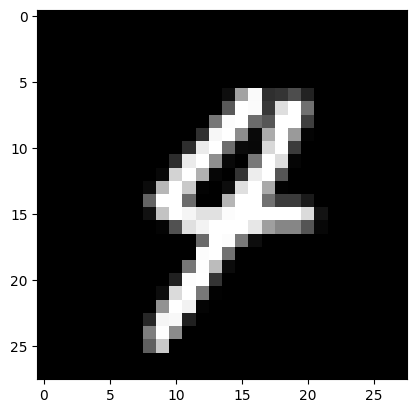

========================= 184 ===============================
test id: 3422
individual experts pred: {0: 4, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


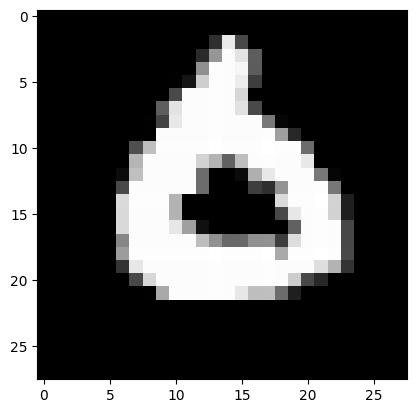

========================= 185 ===============================
test id: 3451
individual experts pred: {7: 3, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


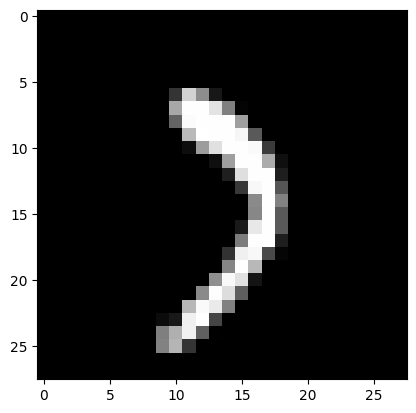

========================= 186 ===============================
test id: 3474
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


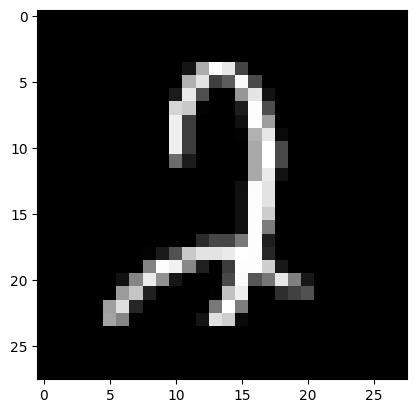

========================= 187 ===============================
test id: 3490
individual experts pred: {4: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


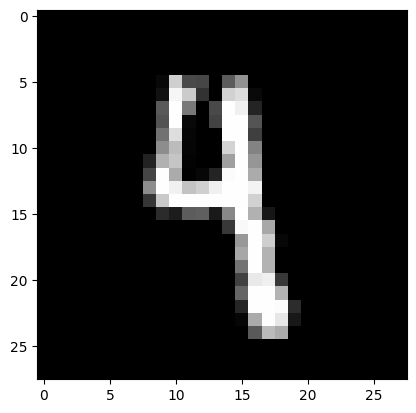

========================= 188 ===============================
test id: 3520
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


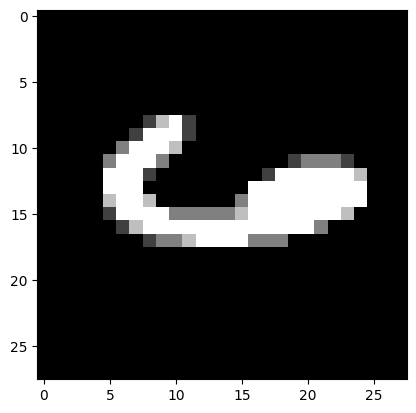

========================= 189 ===============================
test id: 3533
individual experts pred: {4: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


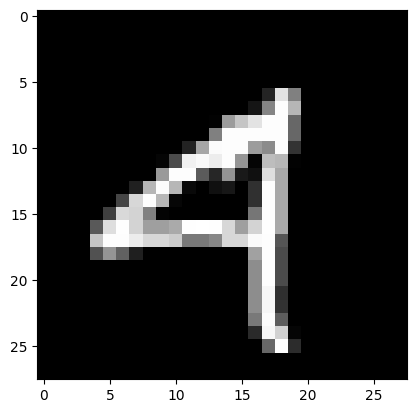

========================= 190 ===============================
test id: 3549
individual experts pred: {2: 1, 3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


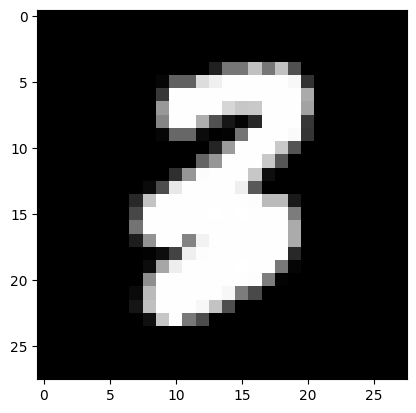

========================= 191 ===============================
test id: 3559
individual experts pred: {5: 4, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


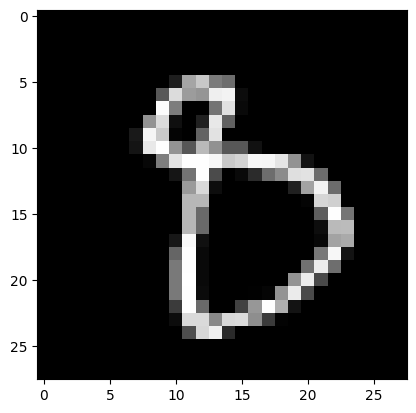

========================= 192 ===============================
test id: 3565
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


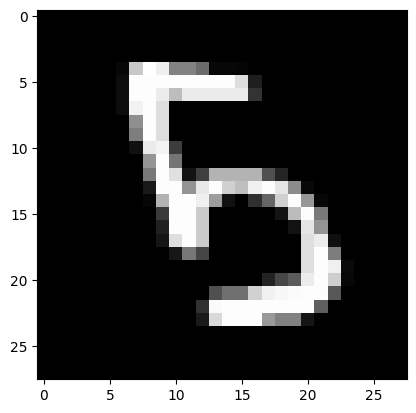

========================= 193 ===============================
test id: 3567
individual experts pred: {5: 3, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


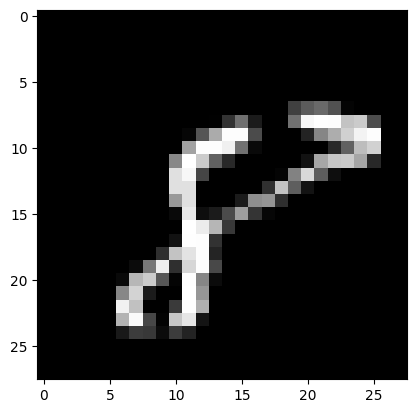

========================= 194 ===============================
test id: 3574
individual experts pred: {0: 4, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


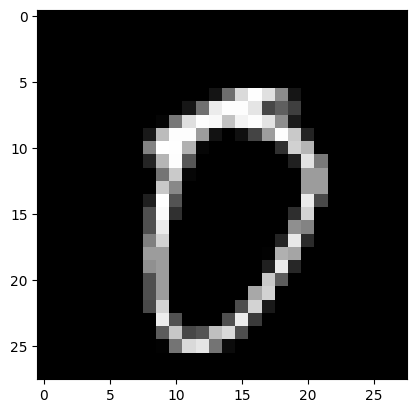

========================= 195 ===============================
test id: 3597
individual experts pred: {3: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


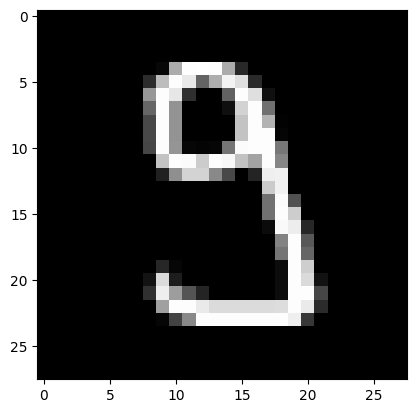

========================= 196 ===============================
test id: 3604
individual experts pred: {7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


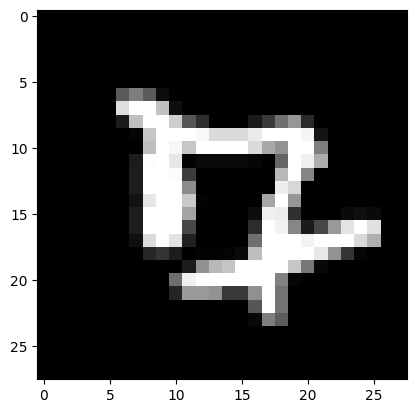

========================= 197 ===============================
test id: 3662
individual experts pred: {8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


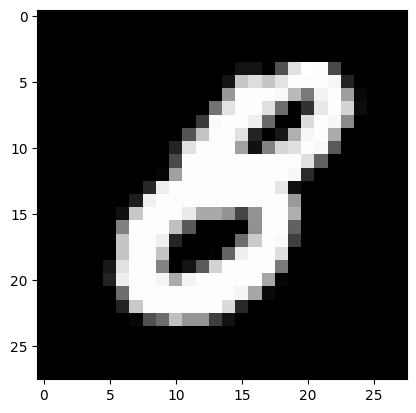

========================= 198 ===============================
test id: 3674
individual experts pred: {8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


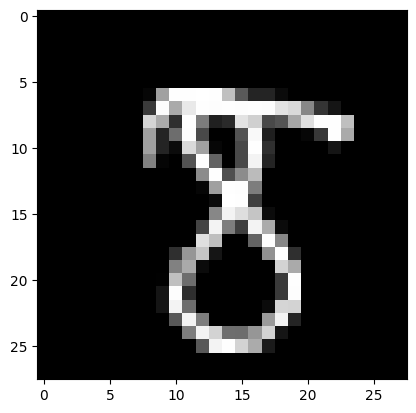

========================= 199 ===============================
test id: 3681
individual experts pred: {2: 1, 3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


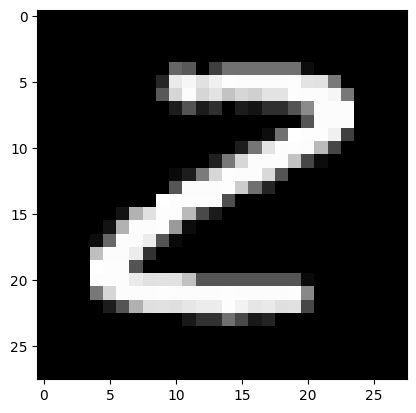

========================= 200 ===============================
test id: 3688
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


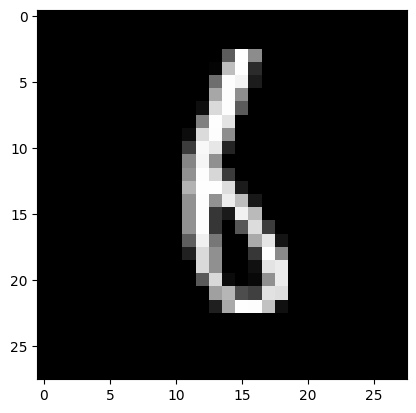

========================= 201 ===============================
test id: 3702
individual experts pred: {5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


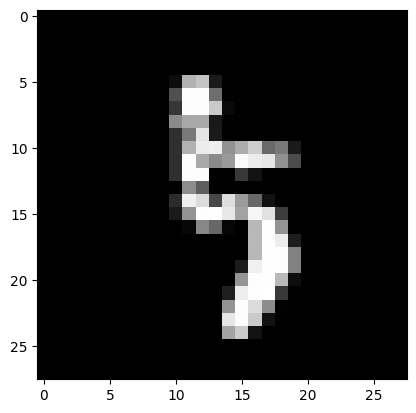

========================= 202 ===============================
test id: 3727
individual experts pred: {8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


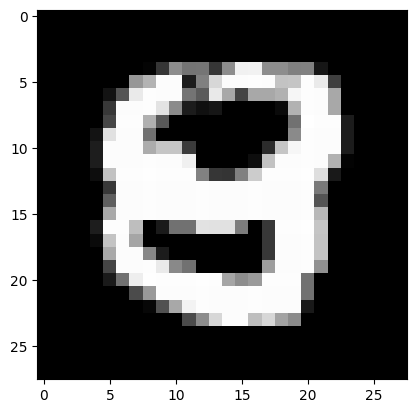

========================= 203 ===============================
test id: 3749
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


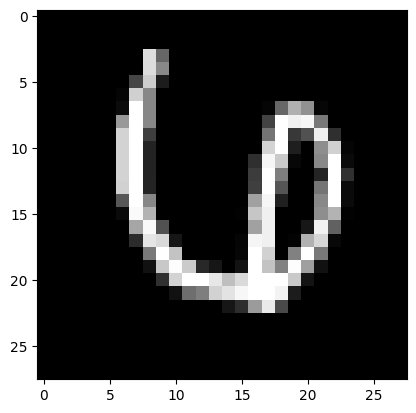

========================= 204 ===============================
test id: 3751
individual experts pred: {7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


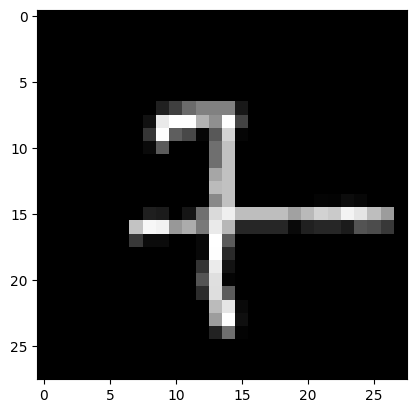

========================= 205 ===============================
test id: 3757
individual experts pred: {3: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


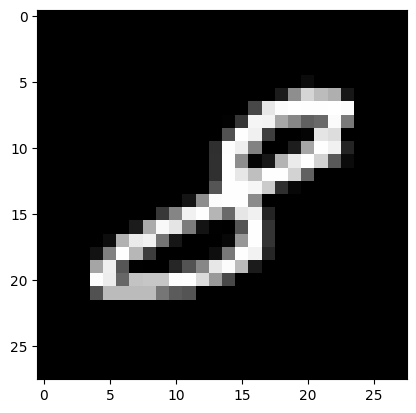

========================= 206 ===============================
test id: 3767
individual experts pred: {3: 1, 7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


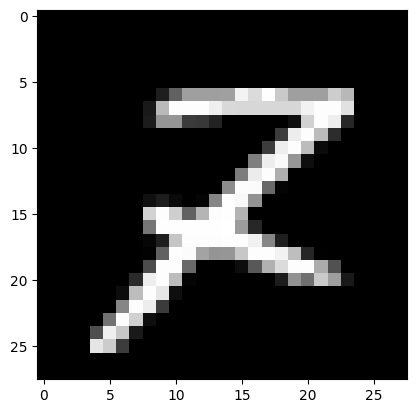

========================= 207 ===============================
test id: 3776
individual experts pred: {5: 3, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


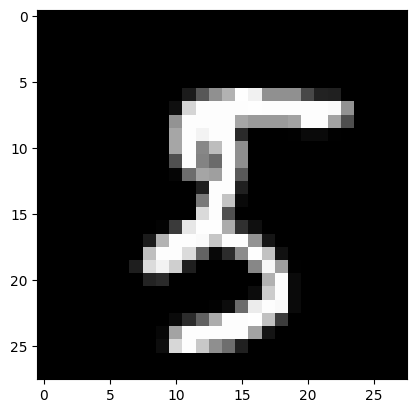

========================= 208 ===============================
test id: 3778
individual experts pred: {5: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


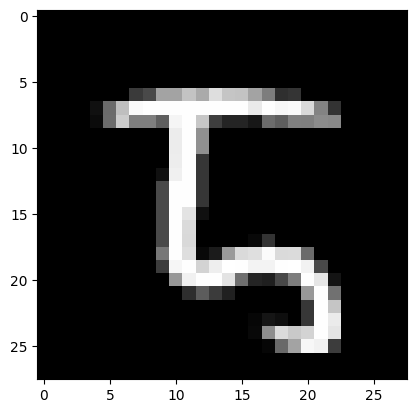

========================= 209 ===============================
test id: 3796
individual experts pred: {2: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


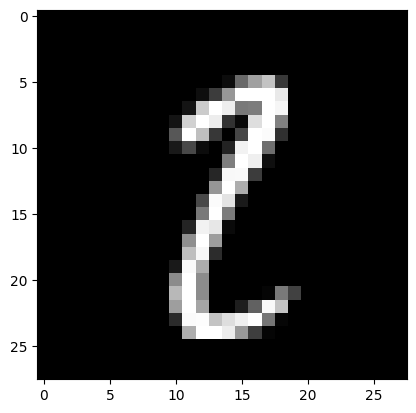

========================= 210 ===============================
test id: 3808
individual experts pred: {3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


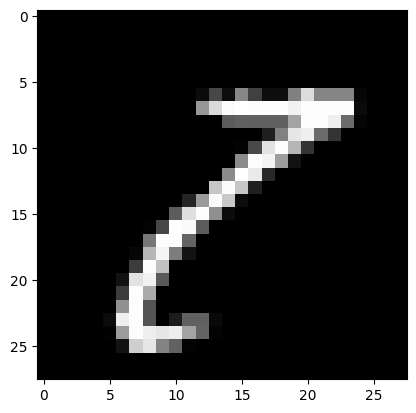

========================= 211 ===============================
test id: 3811
individual experts pred: {3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


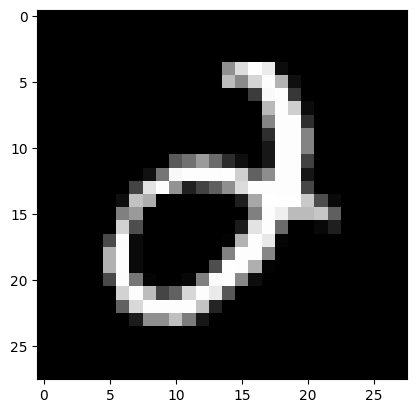

========================= 212 ===============================
test id: 3817
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


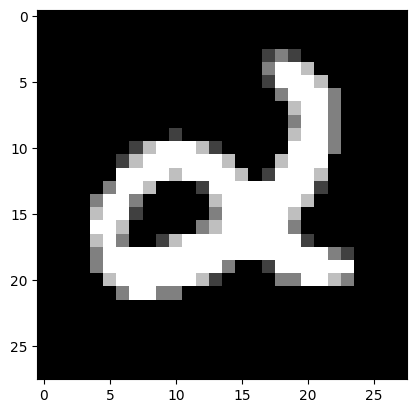

========================= 213 ===============================
test id: 3818
individual experts pred: {0: 1, 4: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


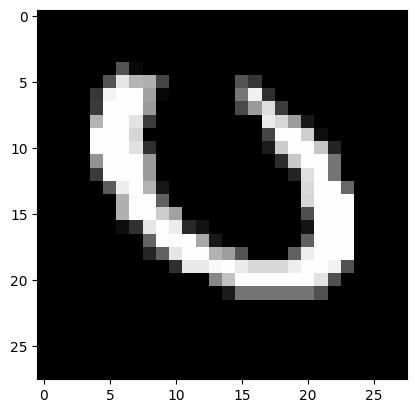

========================= 214 ===============================
test id: 3841
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


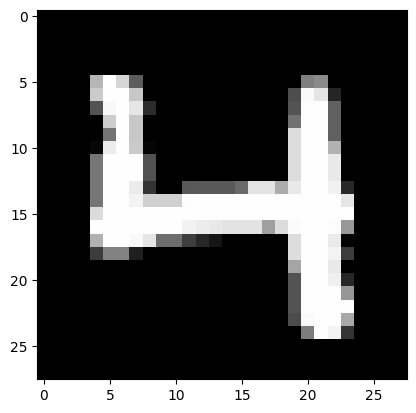

========================= 215 ===============================
test id: 3853
individual experts pred: {}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


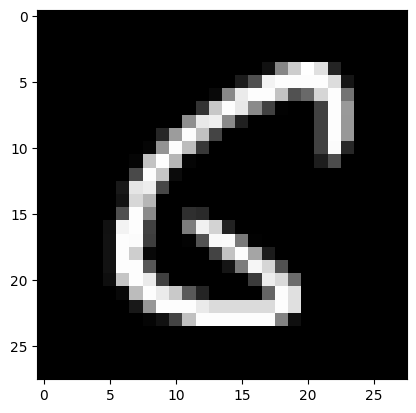

========================= 216 ===============================
test id: 3869
individual experts pred: {9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


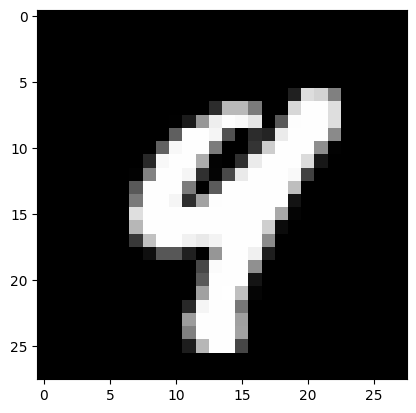

========================= 217 ===============================
test id: 3876
individual experts pred: {2: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


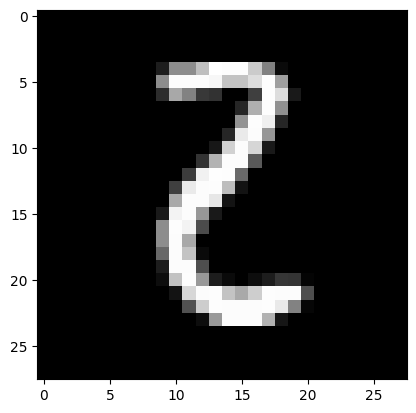

========================= 218 ===============================
test id: 3906
individual experts pred: {3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


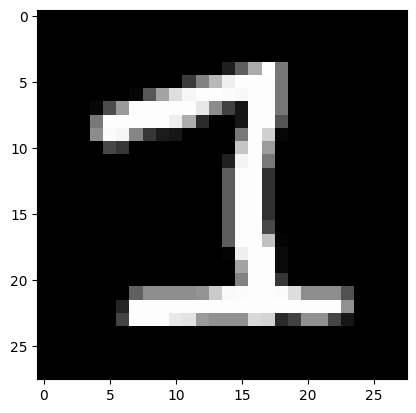

========================= 219 ===============================
test id: 3926
individual experts pred: {3: 4, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


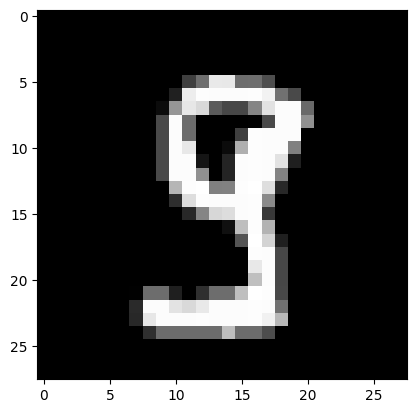

========================= 220 ===============================
test id: 3941
individual experts pred: {2: 3, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


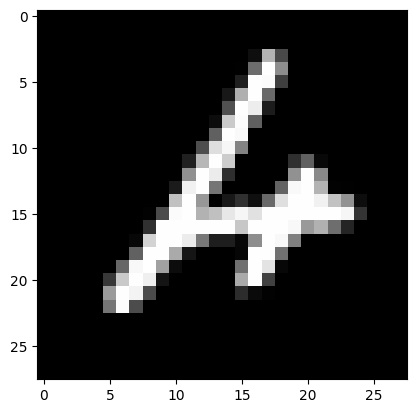

========================= 221 ===============================
test id: 3943
individual experts pred: {3: 3, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


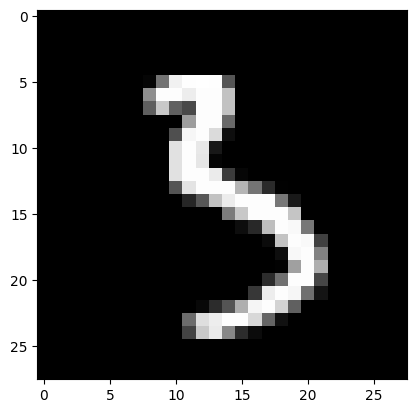

========================= 222 ===============================
test id: 3946
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


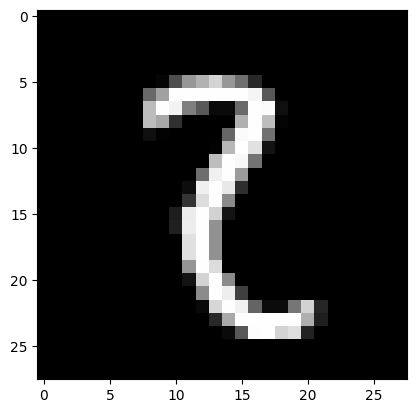

========================= 223 ===============================
test id: 3951
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


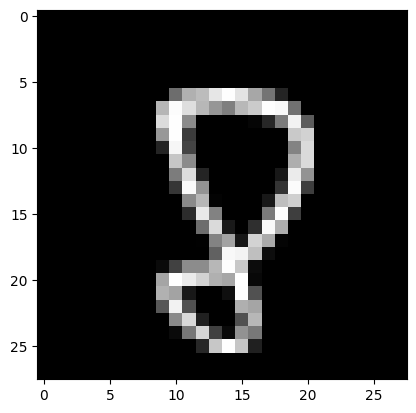

========================= 224 ===============================
test id: 3976
individual experts pred: {1: 2, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


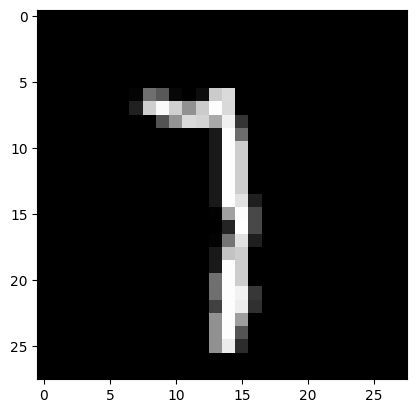

========================= 225 ===============================
test id: 3985
individual experts pred: {4: 4, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


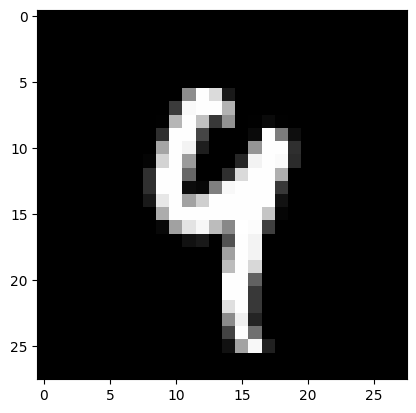

========================= 226 ===============================
test id: 4002
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


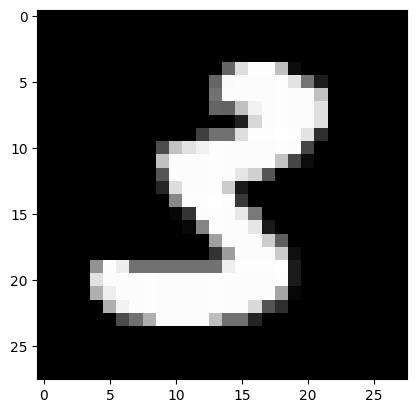

========================= 227 ===============================
test id: 4007
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


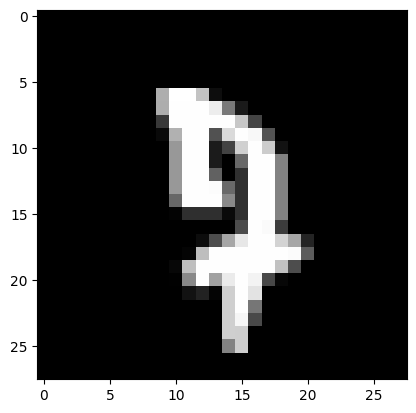

========================= 228 ===============================
test id: 4017
individual experts pred: {4: 4, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


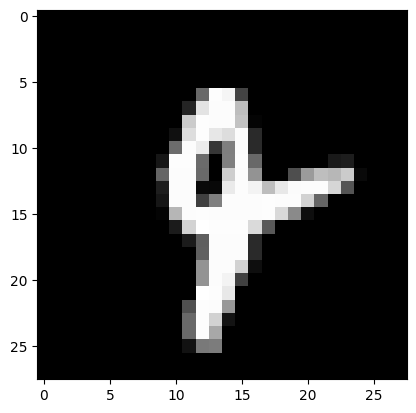

========================= 229 ===============================
test id: 4027
individual experts pred: {7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


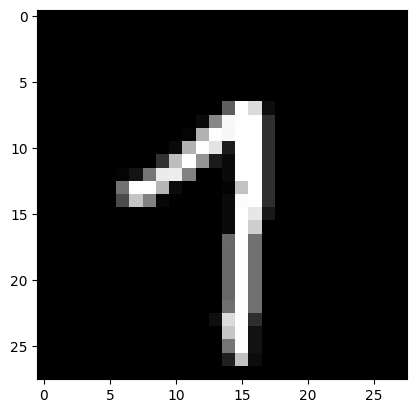

========================= 230 ===============================
test id: 4065
individual experts pred: {2: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


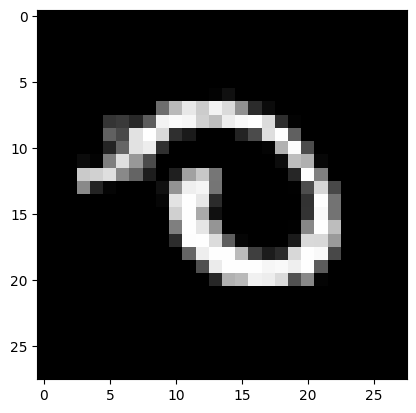

========================= 231 ===============================
test id: 4075
individual experts pred: {0: 3, 3: 1, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


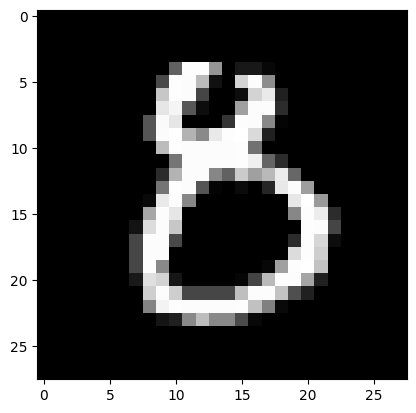

========================= 232 ===============================
test id: 4078
individual experts pred: {3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


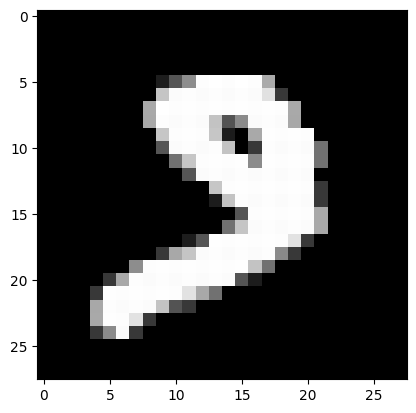

========================= 233 ===============================
test id: 4093
individual experts pred: {4: 1, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


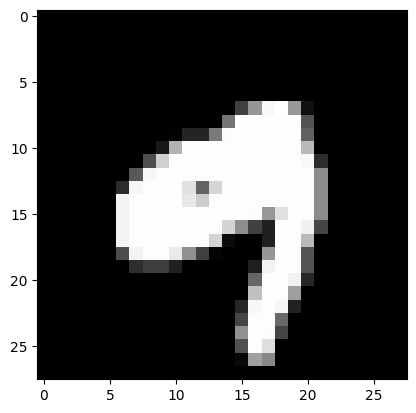

========================= 234 ===============================
test id: 4163
individual experts pred: {}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


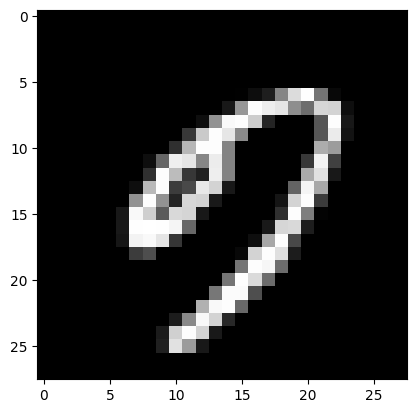

========================= 235 ===============================
test id: 4177
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


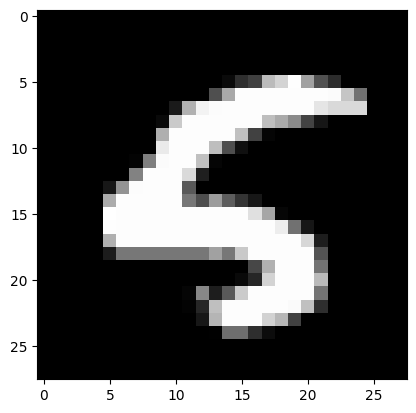

========================= 236 ===============================
test id: 4199
individual experts pred: {7: 1, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


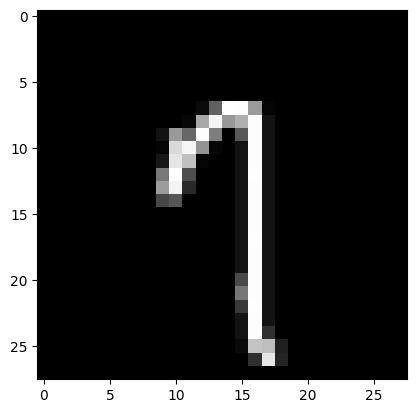

========================= 237 ===============================
test id: 4201
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


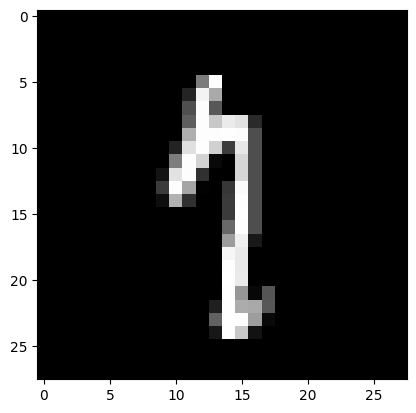

========================= 238 ===============================
test id: 4248
individual experts pred: {4: 1, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


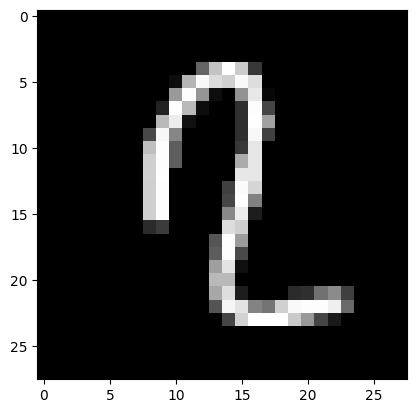

========================= 239 ===============================
test id: 4271
individual experts pred: {3: 2, 5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


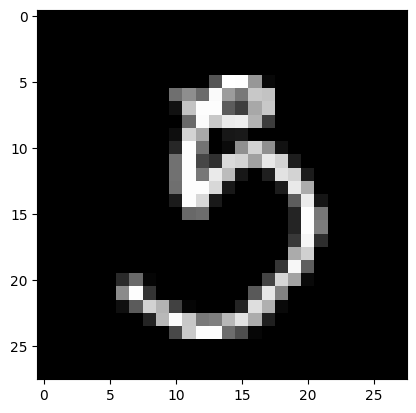

========================= 240 ===============================
test id: 4289
individual experts pred: {7: 3, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


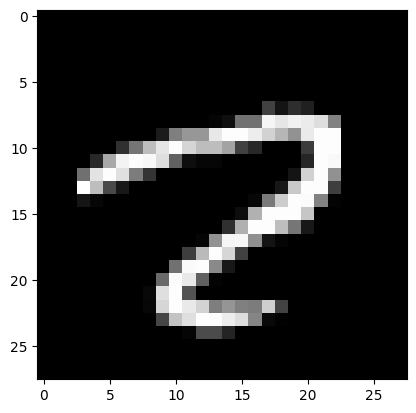

========================= 241 ===============================
test id: 4300
individual experts pred: {5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


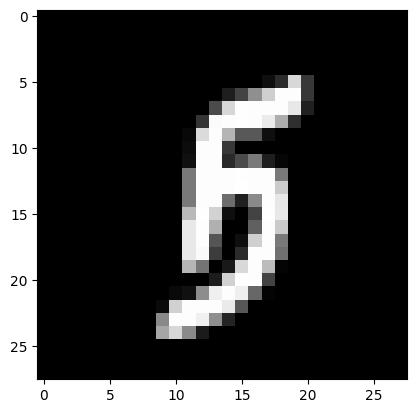

========================= 242 ===============================
test id: 4306
individual experts pred: {3: 2, 7: 3, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


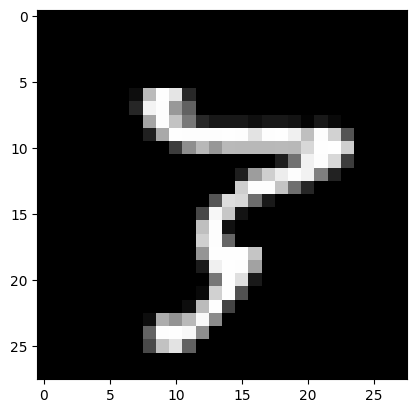

========================= 243 ===============================
test id: 4313
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


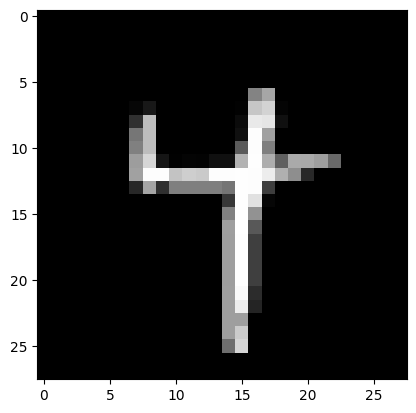

========================= 244 ===============================
test id: 4344
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


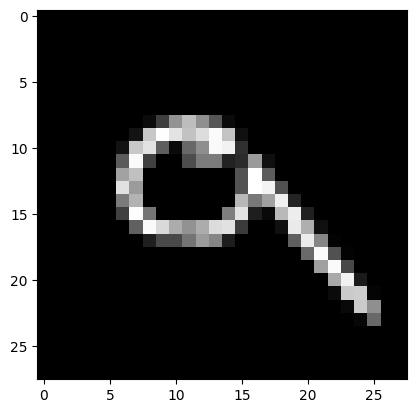

========================= 245 ===============================
test id: 4355
individual experts pred: {3: 1, 5: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


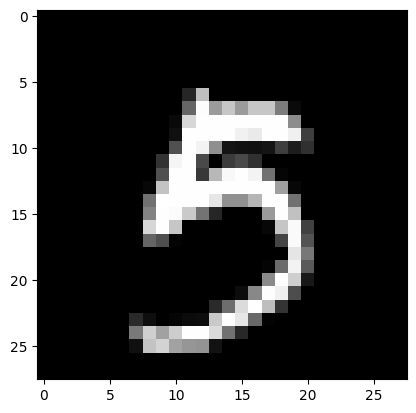

========================= 246 ===============================
test id: 4369
individual experts pred: {4: 4, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


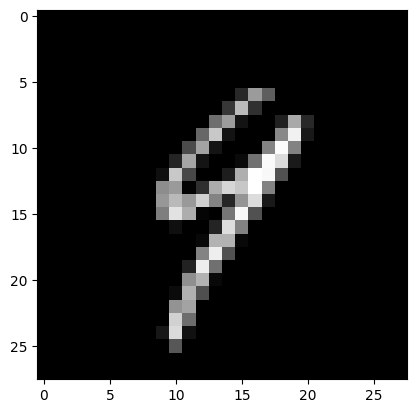

========================= 247 ===============================
test id: 4374
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


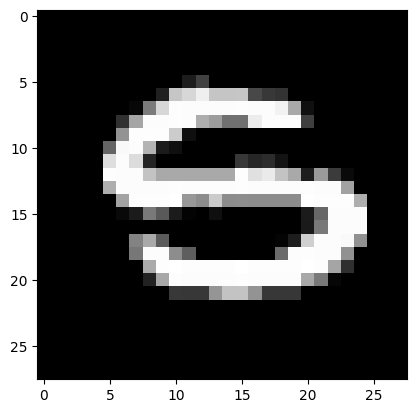

========================= 248 ===============================
test id: 4400
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


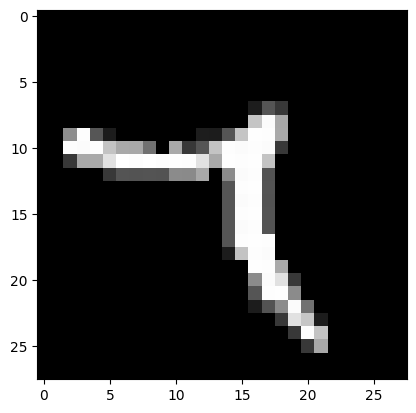

========================= 249 ===============================
test id: 4419
individual experts pred: {4: 2, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


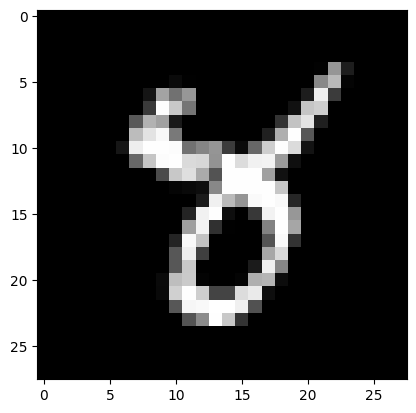

========================= 250 ===============================
test id: 4437
individual experts pred: {2: 4, 3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


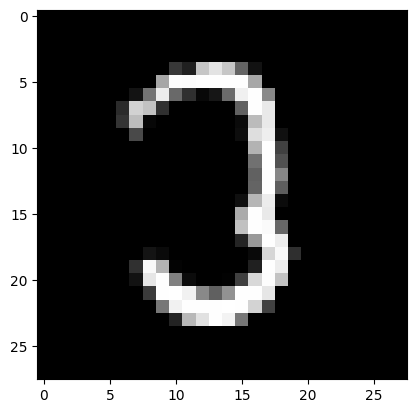

========================= 251 ===============================
test id: 4438
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


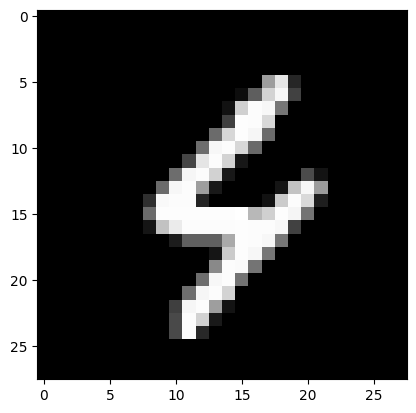

========================= 252 ===============================
test id: 4449
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


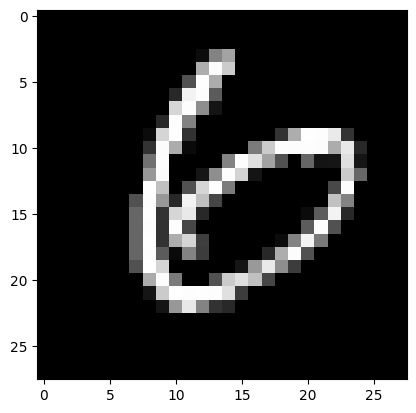

========================= 253 ===============================
test id: 4451
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


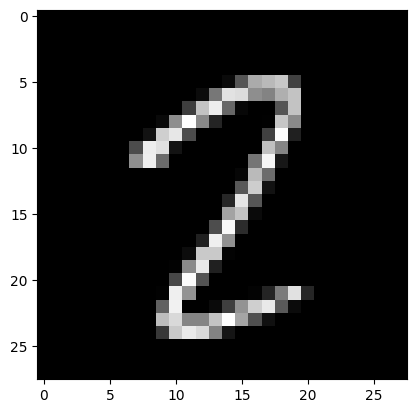

========================= 254 ===============================
test id: 4477
individual experts pred: {0: 4, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


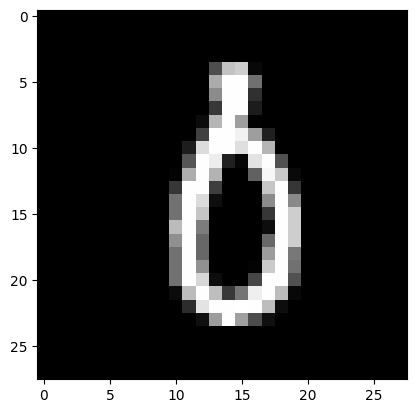

========================= 255 ===============================
test id: 4497
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


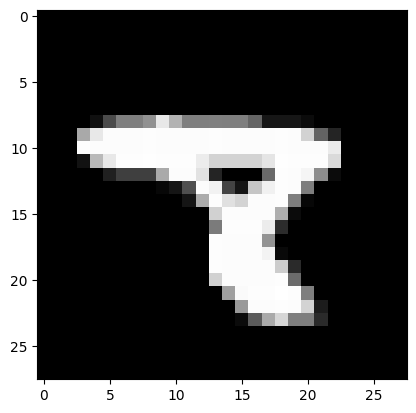

========================= 256 ===============================
test id: 4500
individual experts pred: {1: 2, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


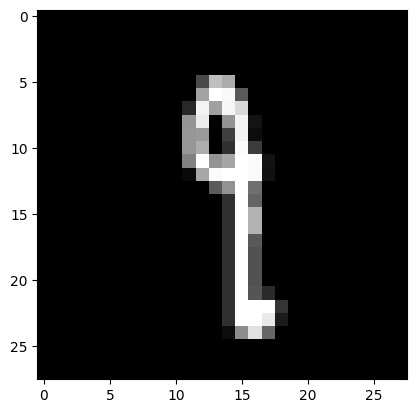

========================= 257 ===============================
test id: 4504
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


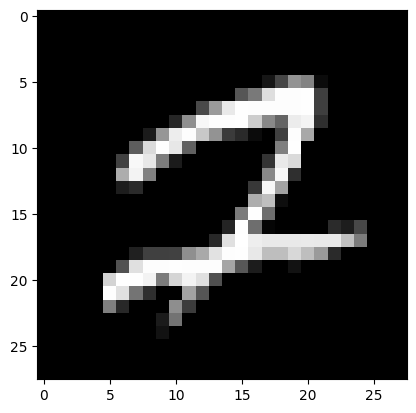

========================= 258 ===============================
test id: 4507
individual experts pred: {1: 4, 7: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


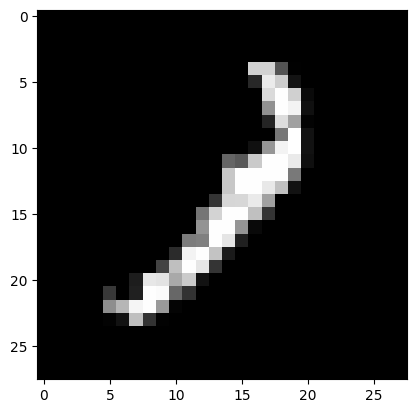

========================= 259 ===============================
test id: 4534
individual experts pred: {8: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


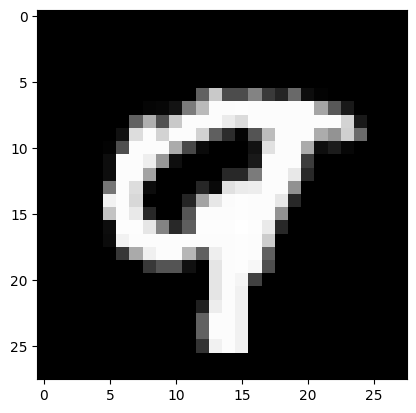

========================= 260 ===============================
test id: 4547
individual experts pred: {6: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


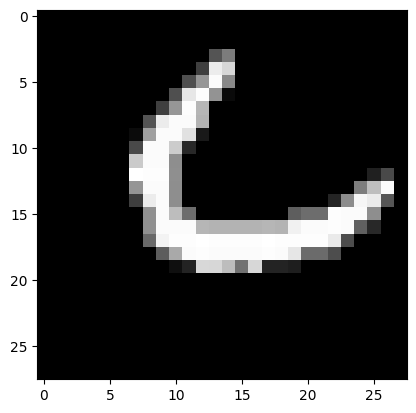

========================= 261 ===============================
test id: 4571
individual experts pred: {6: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


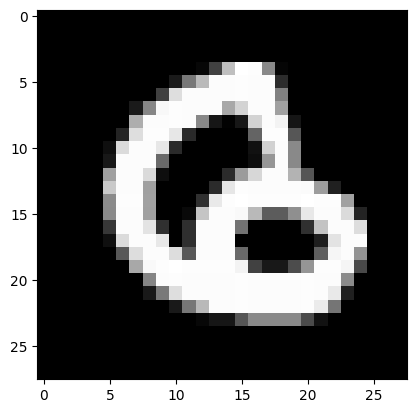

========================= 262 ===============================
test id: 4575
individual experts pred: {2: 3, 4: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


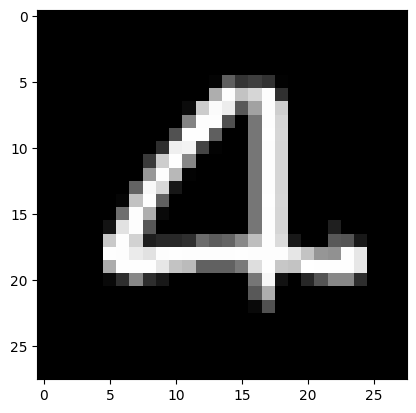

========================= 263 ===============================
test id: 4601
individual experts pred: {4: 4, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


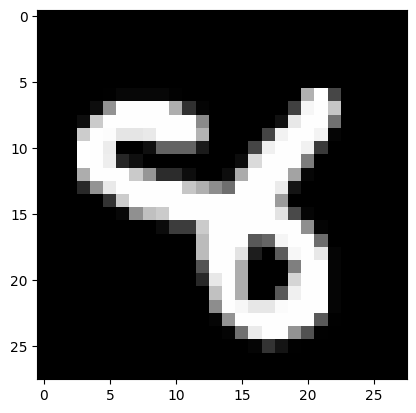

========================= 264 ===============================
test id: 4615
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


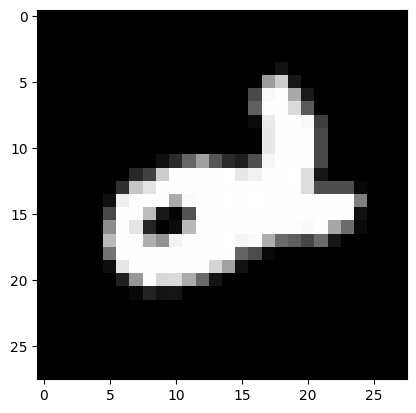

========================= 265 ===============================
test id: 4635
individual experts pred: {3: 4, 5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


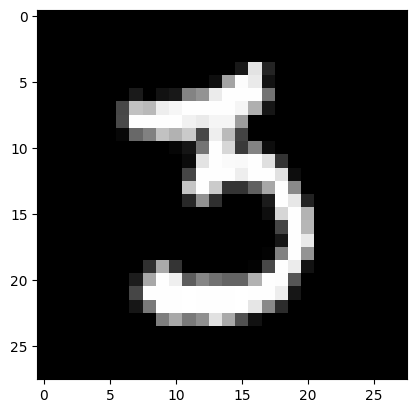

========================= 266 ===============================
test id: 4639
individual experts pred: {8: 2, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


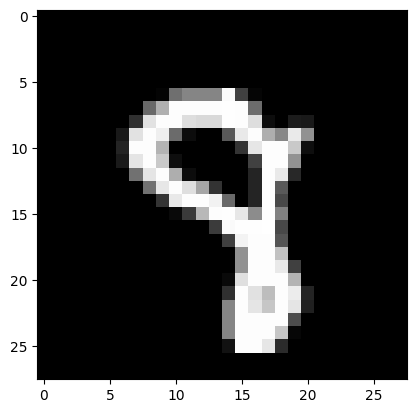

========================= 267 ===============================
test id: 4671
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


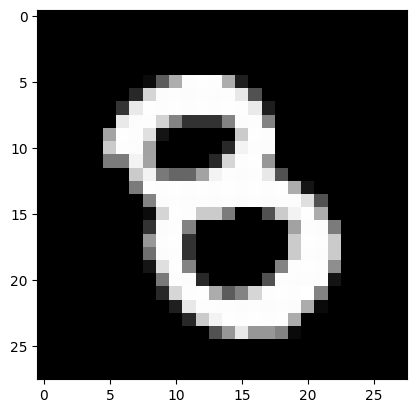

========================= 268 ===============================
test id: 4690
individual experts pred: {2: 2, 7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


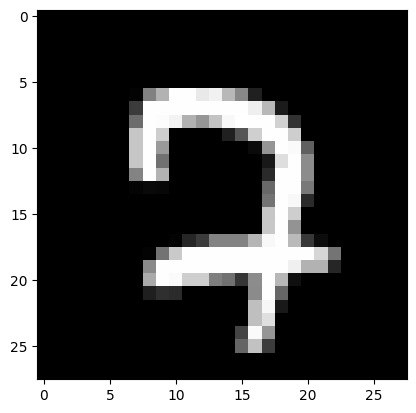

========================= 269 ===============================
test id: 4699
individual experts pred: {1: 2, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


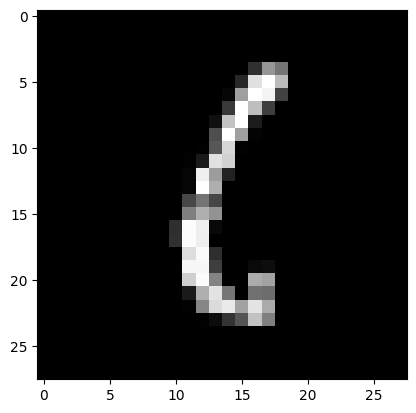

========================= 270 ===============================
test id: 4723
individual experts pred: {2: 4, 3: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


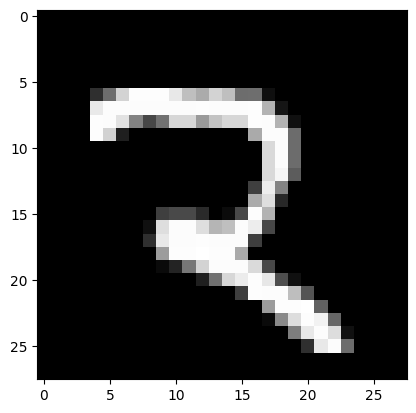

========================= 271 ===============================
test id: 4731
individual experts pred: {7: 2, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


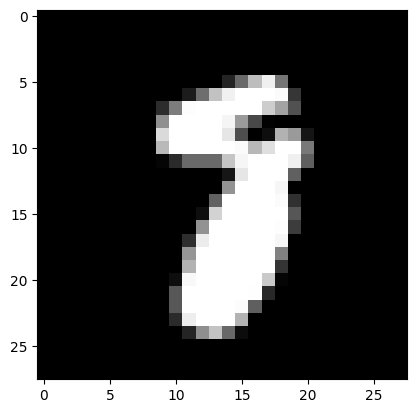

========================= 272 ===============================
test id: 4740
individual experts pred: {3: 2, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


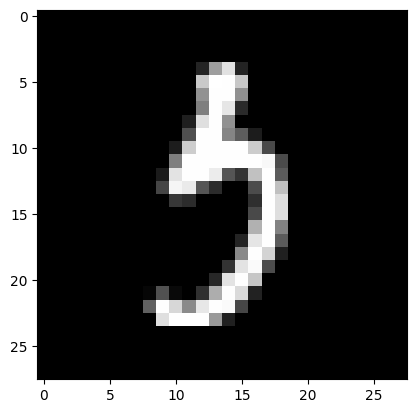

========================= 273 ===============================
test id: 4751
individual experts pred: {4: 3, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


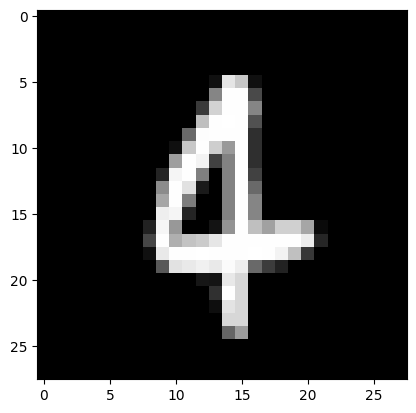

========================= 274 ===============================
test id: 4761
individual experts pred: {8: 3, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


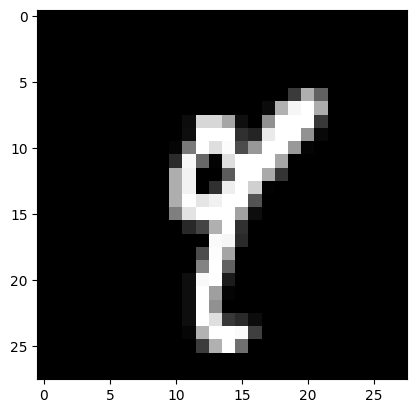

========================= 275 ===============================
test id: 4763
individual experts pred: {5: 4, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


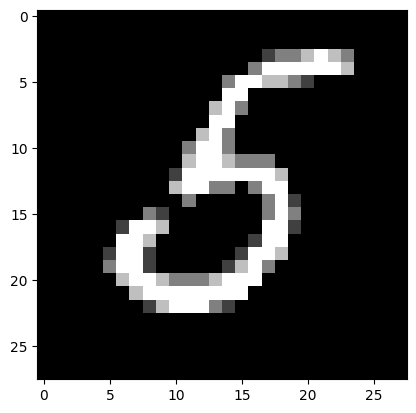

========================= 276 ===============================
test id: 4807
individual experts pred: {0: 2, 3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


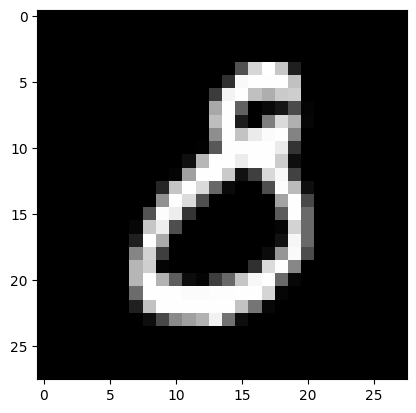

========================= 277 ===============================
test id: 4814
individual experts pred: {6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


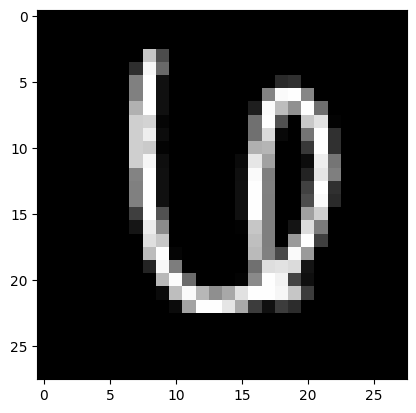

========================= 278 ===============================
test id: 4823
individual experts pred: {4: 2, 6: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


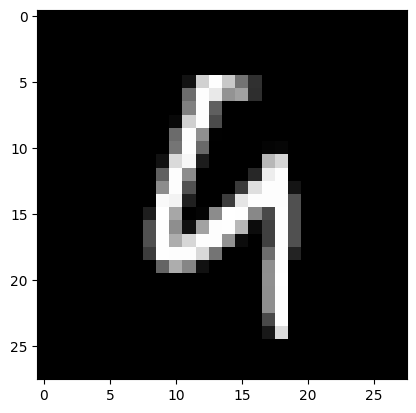

========================= 279 ===============================
test id: 4837
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


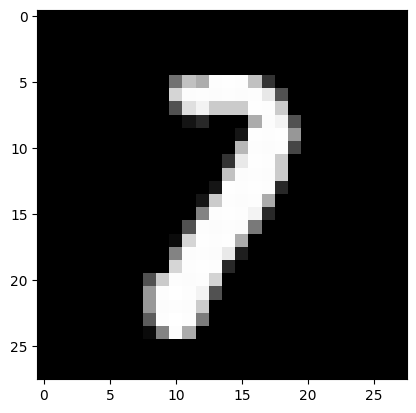

========================= 280 ===============================
test id: 4860
individual experts pred: {4: 3, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


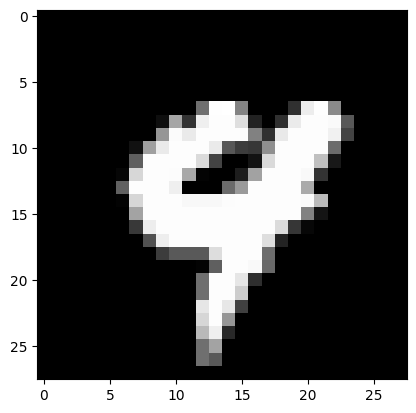

========================= 281 ===============================
test id: 4874
individual experts pred: {9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


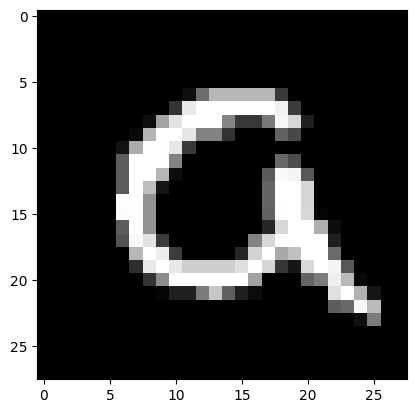

========================= 282 ===============================
test id: 4880
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


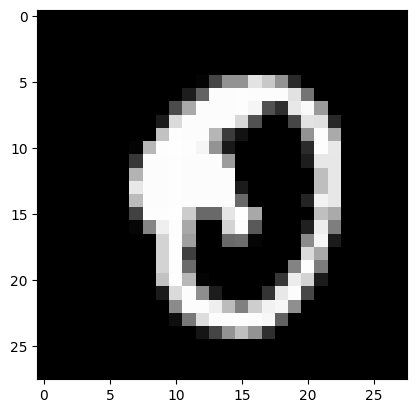

========================= 283 ===============================
test id: 4886
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


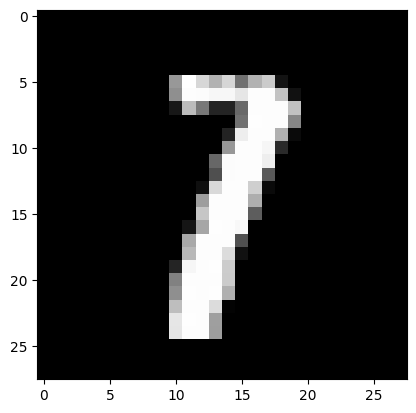

========================= 284 ===============================
test id: 4890
individual experts pred: {8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


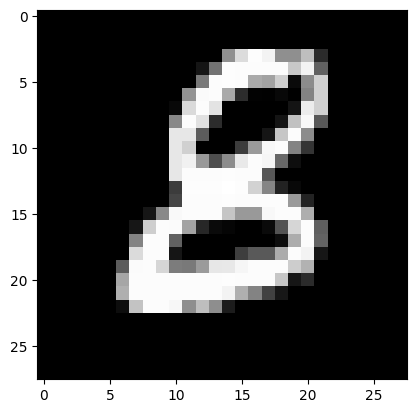

========================= 285 ===============================
test id: 4910
individual experts pred: {4: 1, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


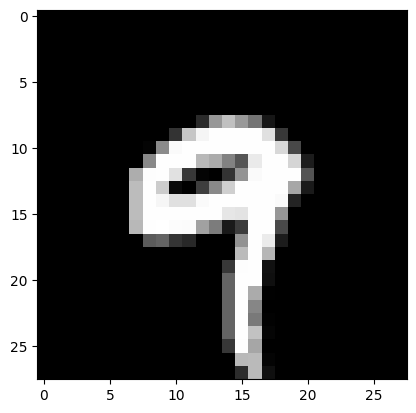

========================= 286 ===============================
test id: 4943
individual experts pred: {2: 1, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


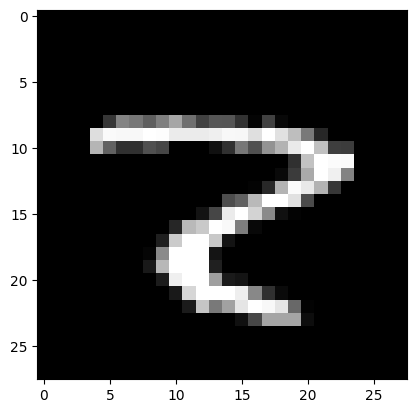

========================= 287 ===============================
test id: 4950
individual experts pred: {2: 4, 3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


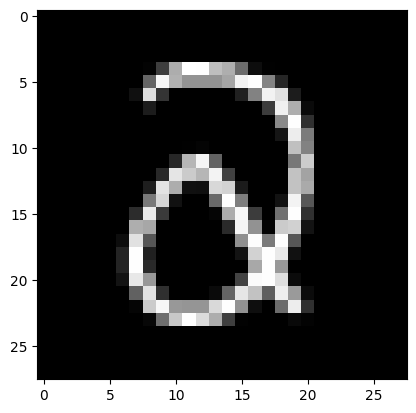

========================= 288 ===============================
test id: 4956
individual experts pred: {4: 3, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


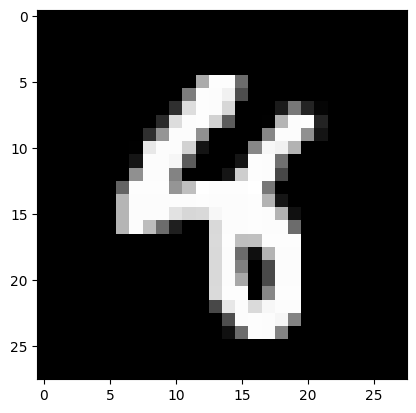

========================= 289 ===============================
test id: 4966
individual experts pred: {7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


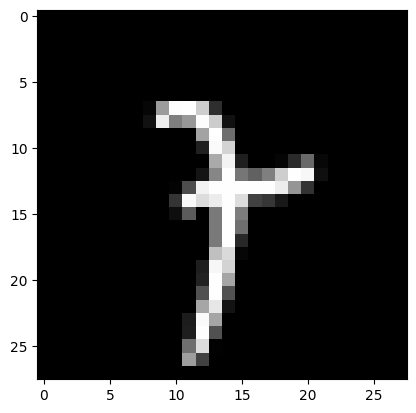

========================= 290 ===============================
test id: 4978
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


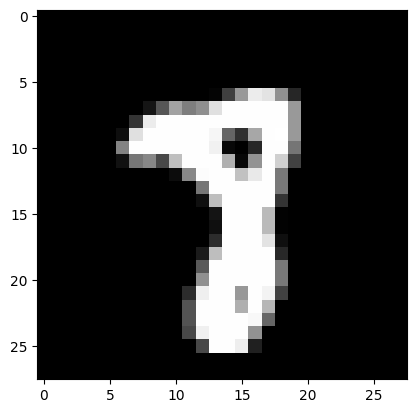

========================= 291 ===============================
test id: 5006
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


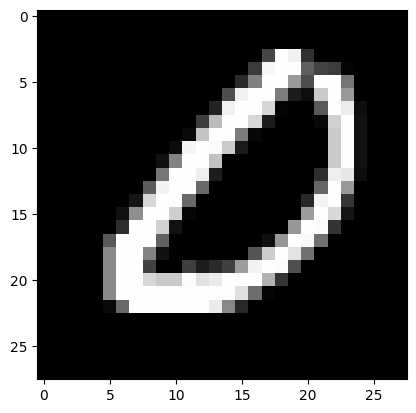

========================= 292 ===============================
test id: 5078
individual experts pred: {3: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


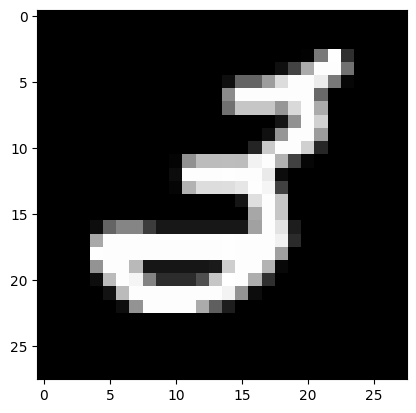

========================= 293 ===============================
test id: 5140
individual experts pred: {3: 4, 4: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


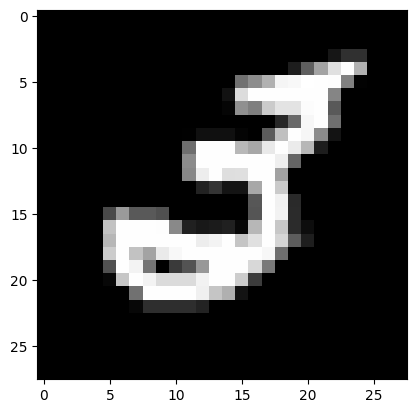

========================= 294 ===============================
test id: 5165
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


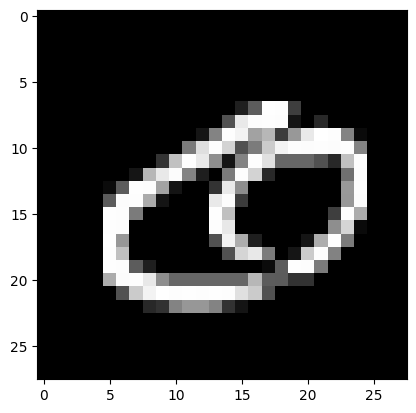

========================= 295 ===============================
test id: 5199
individual experts pred: {6: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


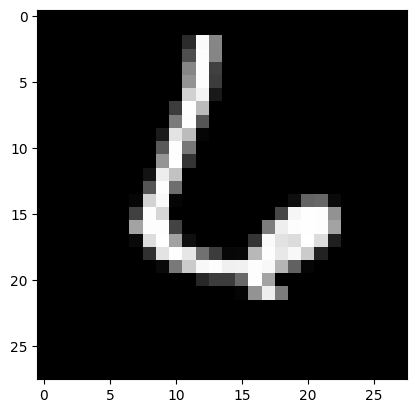

========================= 296 ===============================
test id: 5210
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


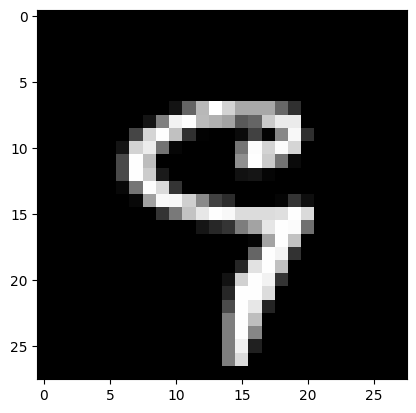

========================= 297 ===============================
test id: 5331
individual experts pred: {1: 2, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


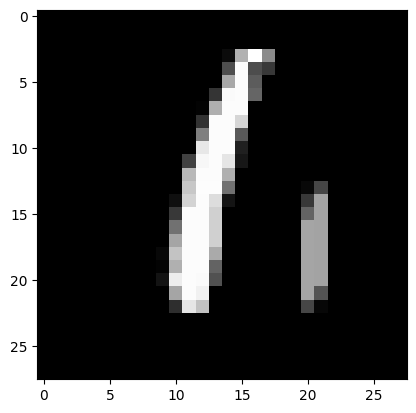

========================= 298 ===============================
test id: 5409
individual experts pred: {4: 4, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


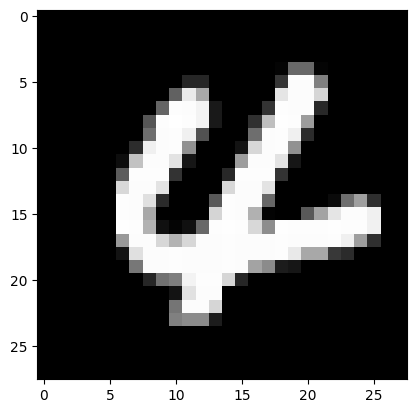

========================= 299 ===============================
test id: 5600
individual experts pred: {7: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


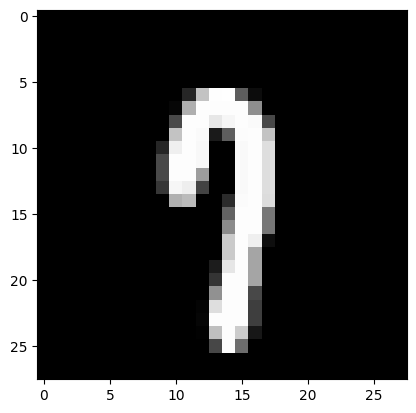

========================= 300 ===============================
test id: 5613
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


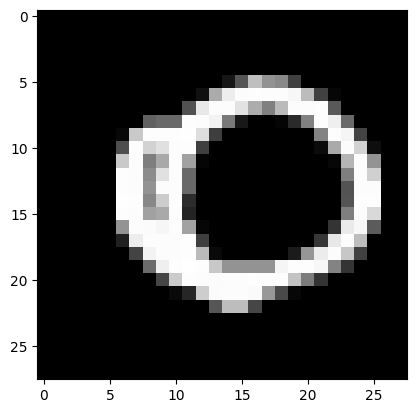

========================= 301 ===============================
test id: 5634
individual experts pred: {2: 3, 3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


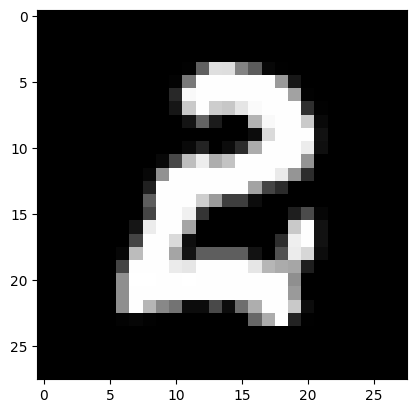

========================= 302 ===============================
test id: 5642
individual experts pred: {1: 2, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


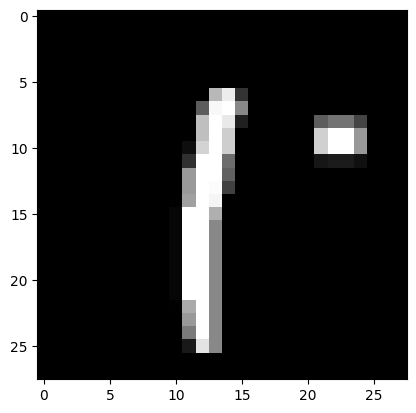

========================= 303 ===============================
test id: 5655
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


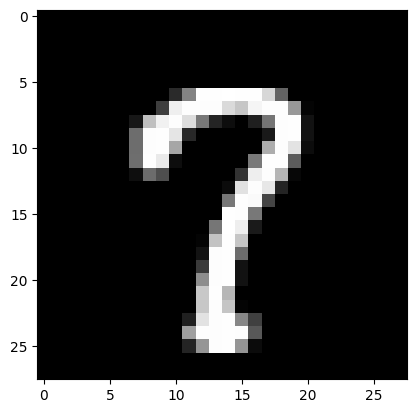

========================= 304 ===============================
test id: 5676
individual experts pred: {3: 1, 4: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


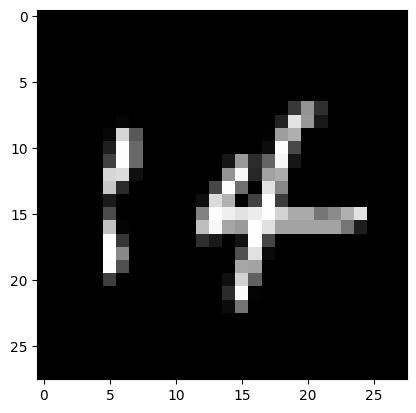

========================= 305 ===============================
test id: 5719
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


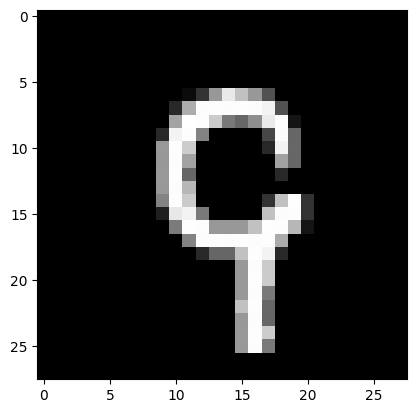

========================= 306 ===============================
test id: 5734
individual experts pred: {2: 4, 7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


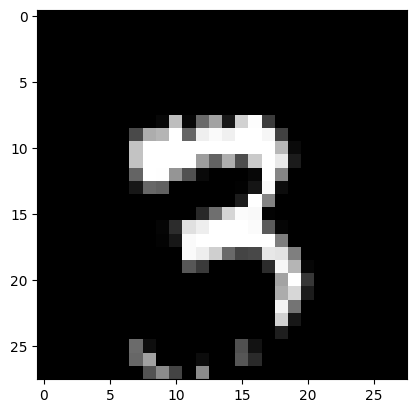

========================= 307 ===============================
test id: 5735
individual experts pred: {5: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


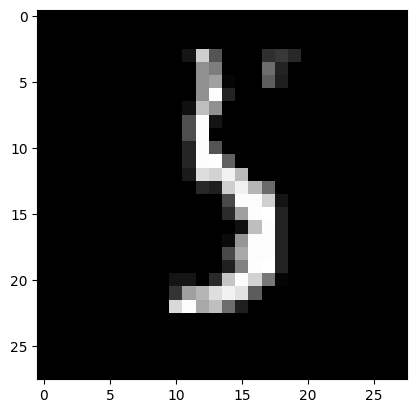

========================= 308 ===============================
test id: 5749
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


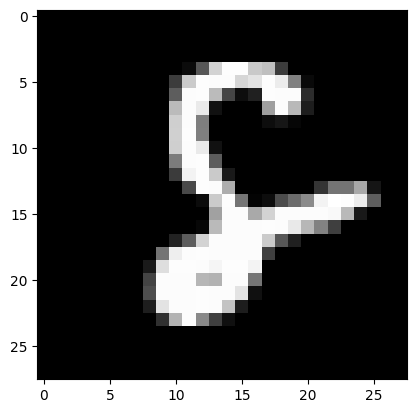

========================= 309 ===============================
test id: 5835
individual experts pred: {7: 2, 8: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


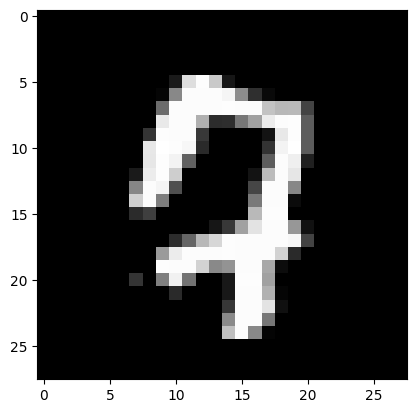

========================= 310 ===============================
test id: 5841
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


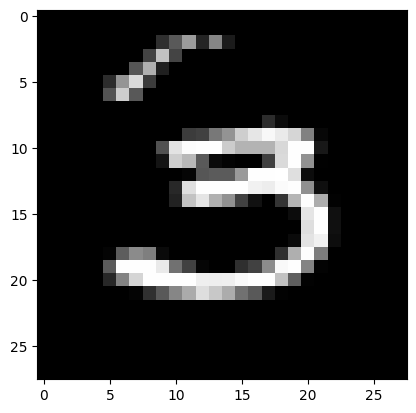

========================= 311 ===============================
test id: 5887
individual experts pred: {}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


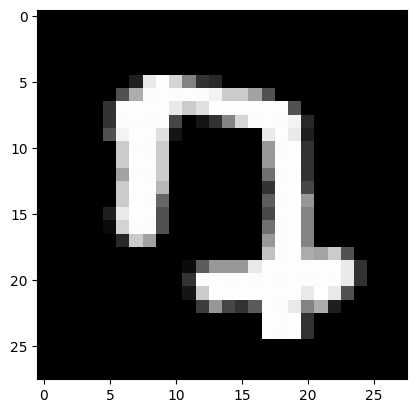

========================= 312 ===============================
test id: 5888
individual experts pred: {0: 1, 4: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


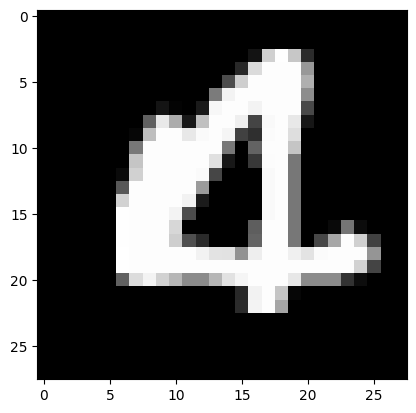

========================= 313 ===============================
test id: 5936
individual experts pred: {4: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


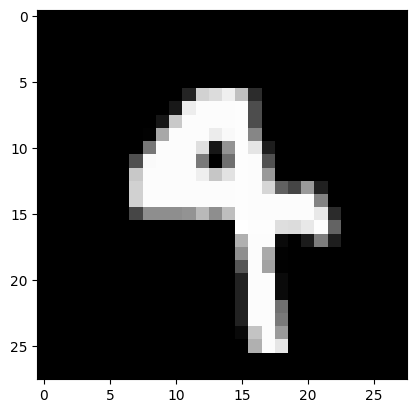

========================= 314 ===============================
test id: 5982
individual experts pred: {3: 1, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


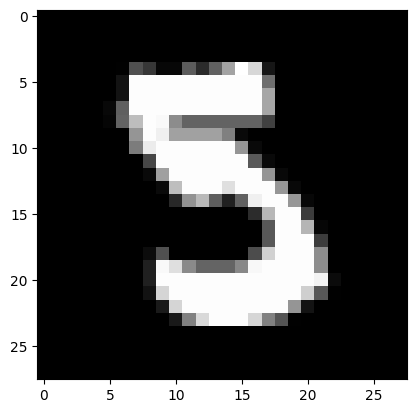

========================= 315 ===============================
test id: 6011
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


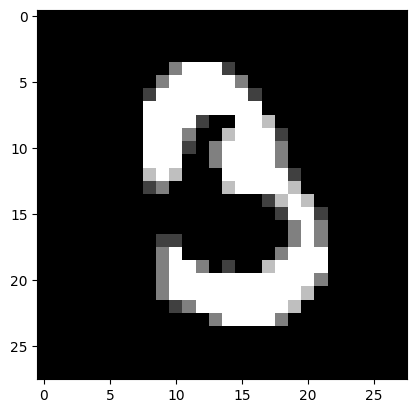

========================= 316 ===============================
test id: 6023
individual experts pred: {}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


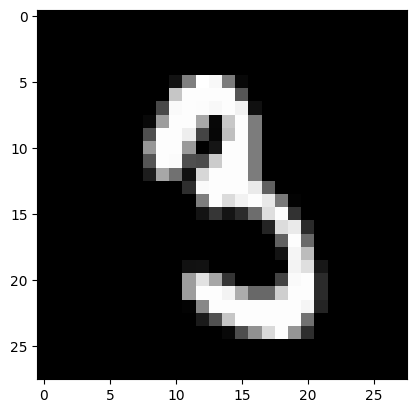

========================= 317 ===============================
test id: 6030
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


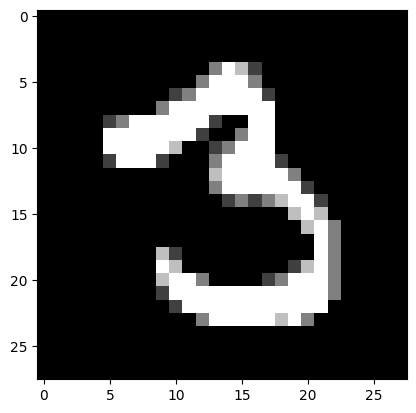

========================= 318 ===============================
test id: 6045
individual experts pred: {3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


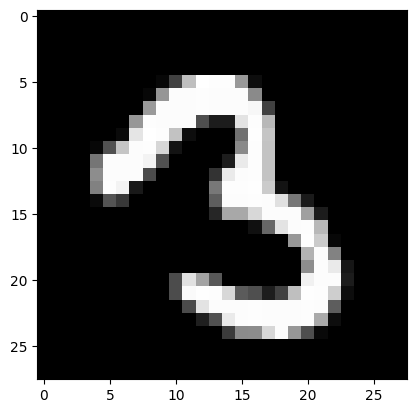

========================= 319 ===============================
test id: 6046
individual experts pred: {3: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


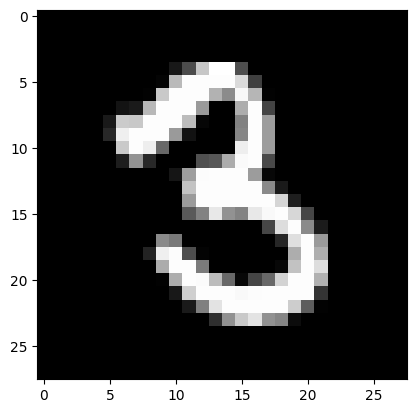

========================= 320 ===============================
test id: 6059
individual experts pred: {}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


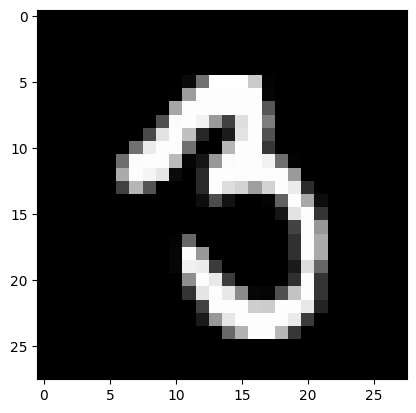

========================= 321 ===============================
test id: 6071
individual experts pred: {3: 3, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


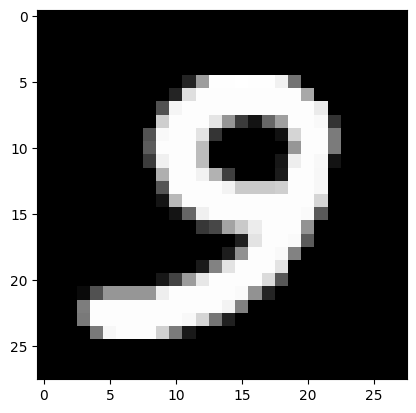

========================= 322 ===============================
test id: 6081
individual experts pred: {3: 1, 5: 1, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


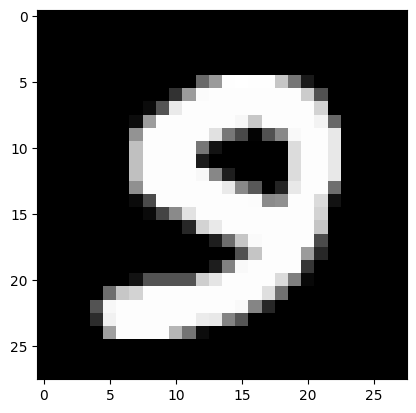

========================= 323 ===============================
test id: 6091
individual experts pred: {9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


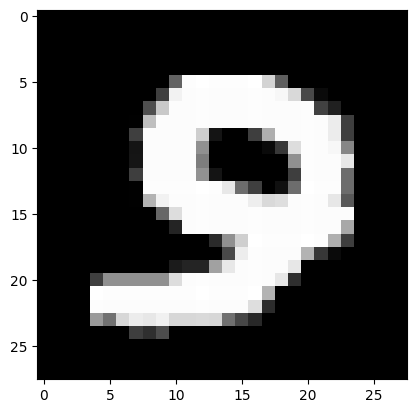

========================= 324 ===============================
test id: 6166
individual experts pred: {3: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


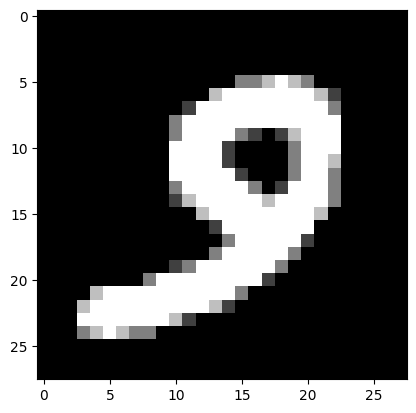

========================= 325 ===============================
test id: 6168
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


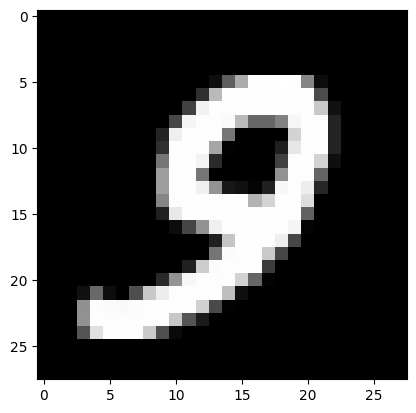

========================= 326 ===============================
test id: 6172
individual experts pred: {9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


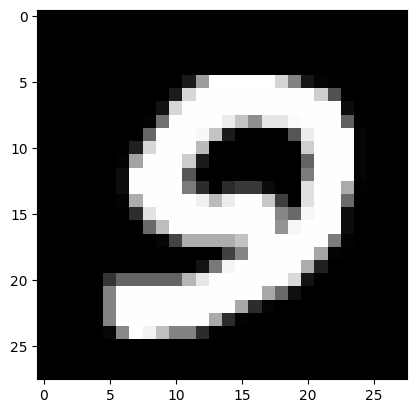

========================= 327 ===============================
test id: 6173
individual experts pred: {9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


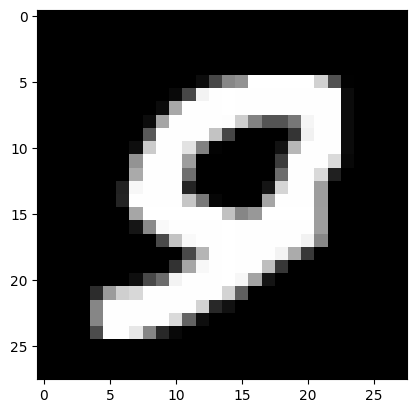

========================= 328 ===============================
test id: 6174
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


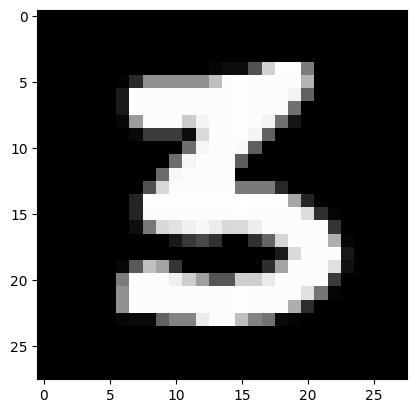

========================= 329 ===============================
test id: 6391
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


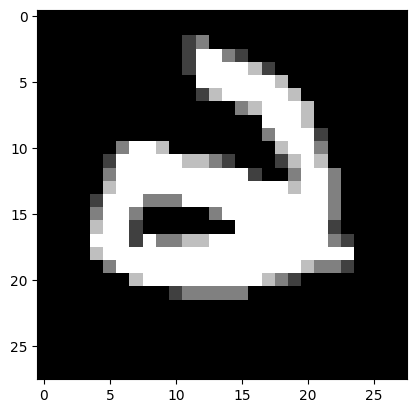

========================= 330 ===============================
test id: 6400
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


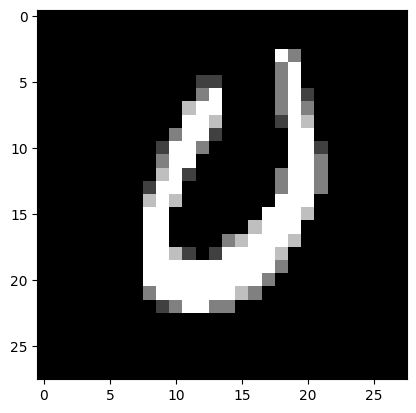

========================= 331 ===============================
test id: 6505
individual experts pred: {0: 4, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


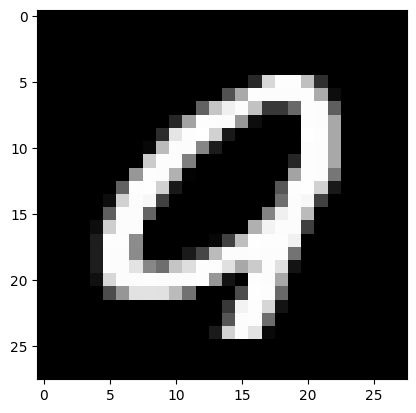

========================= 332 ===============================
test id: 6560
individual experts pred: {8: 2, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


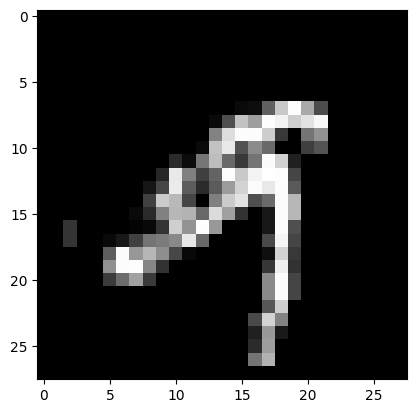

========================= 333 ===============================
test id: 6568
individual experts pred: {4: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


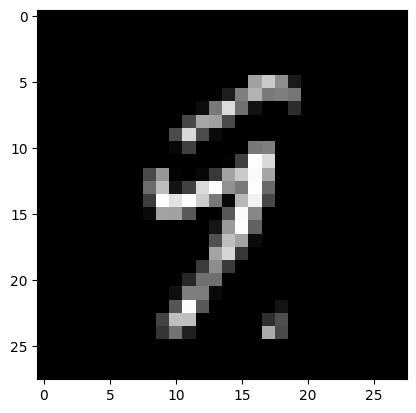

========================= 334 ===============================
test id: 6571
individual experts pred: {7: 4, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


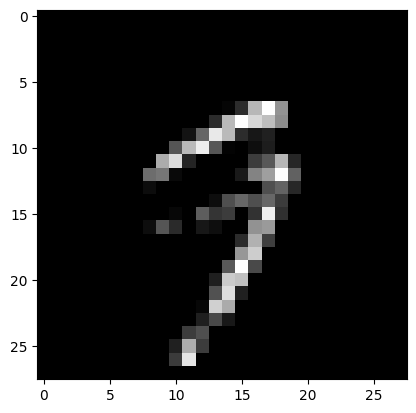

========================= 335 ===============================
test id: 6576
individual experts pred: {7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


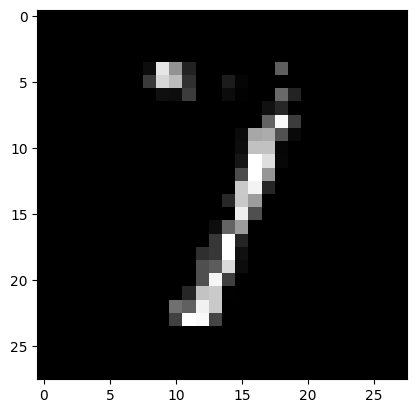

========================= 336 ===============================
test id: 6603
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


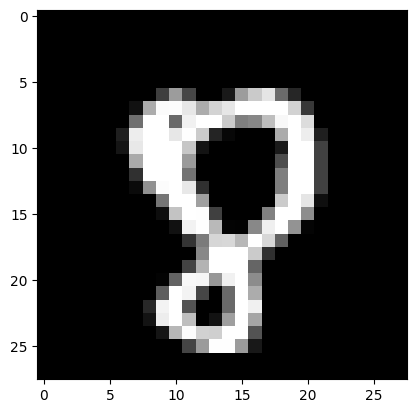

========================= 337 ===============================
test id: 6625
individual experts pred: {4: 3, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


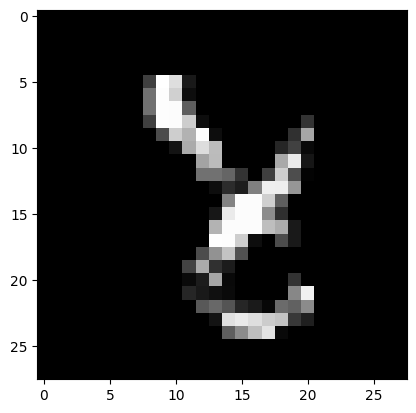

========================= 338 ===============================
test id: 6641
individual experts pred: {5: 1, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


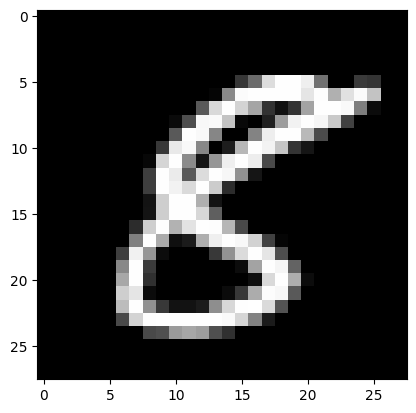

========================= 339 ===============================
test id: 6651
individual experts pred: {5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


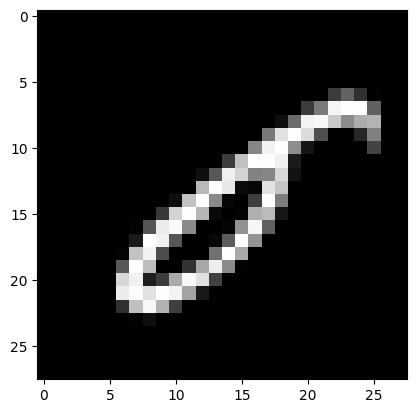

========================= 340 ===============================
test id: 6681
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


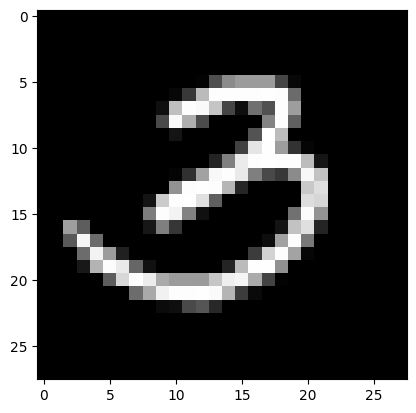

========================= 341 ===============================
test id: 6740
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


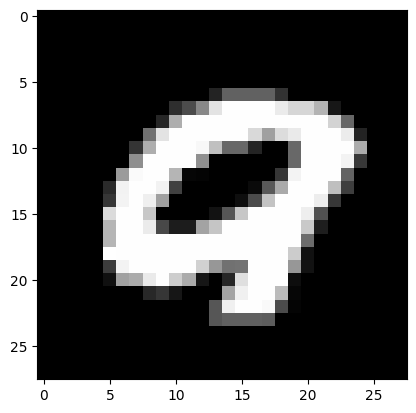

========================= 342 ===============================
test id: 6755
individual experts pred: {9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


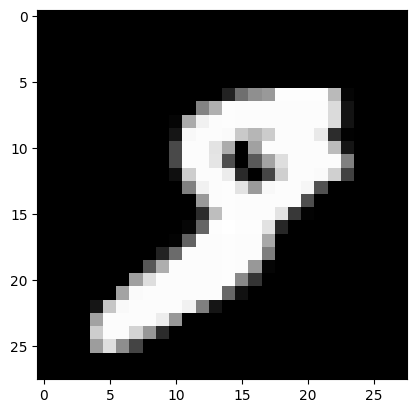

========================= 343 ===============================
test id: 6817
individual experts pred: {4: 1, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


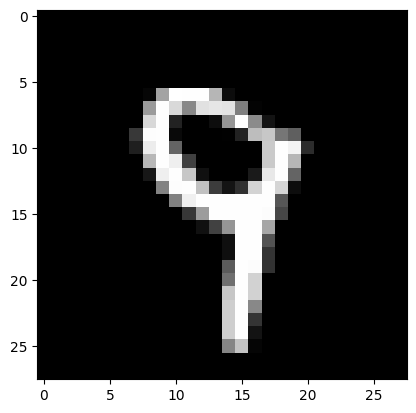

========================= 344 ===============================
test id: 6847
individual experts pred: {4: 2, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


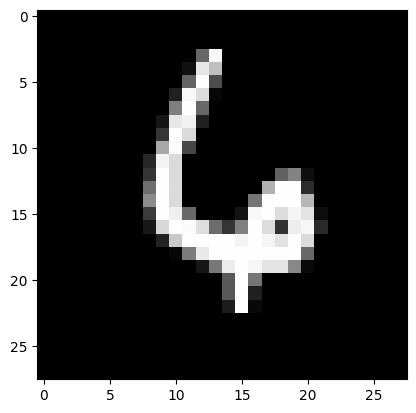

========================= 345 ===============================
test id: 7208
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


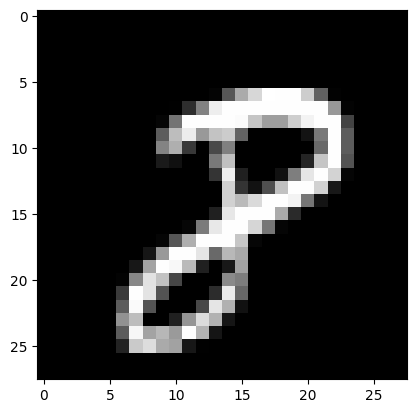

========================= 346 ===============================
test id: 7216
individual experts pred: {3: 1, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


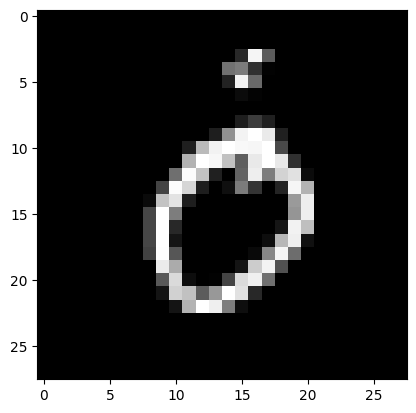

========================= 347 ===============================
test id: 7233
individual experts pred: {3: 3, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


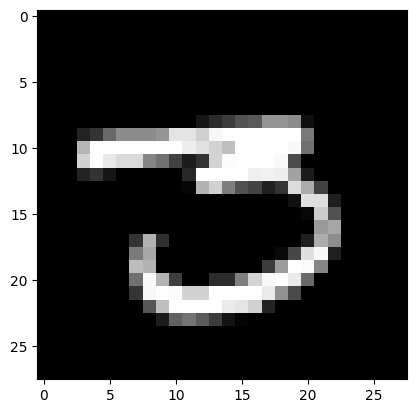

========================= 348 ===============================
test id: 7434
individual experts pred: {4: 3, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


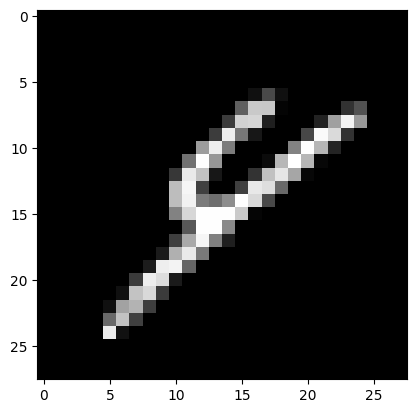

========================= 349 ===============================
test id: 7451
individual experts pred: {5: 3, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


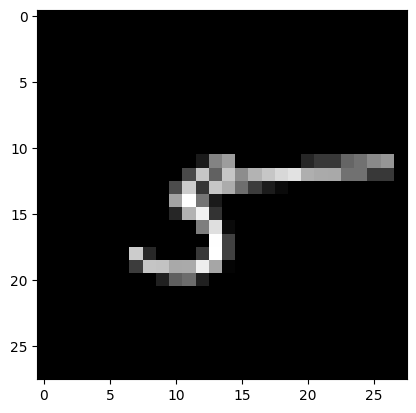

========================= 350 ===============================
test id: 7492
individual experts pred: {2: 3, 7: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


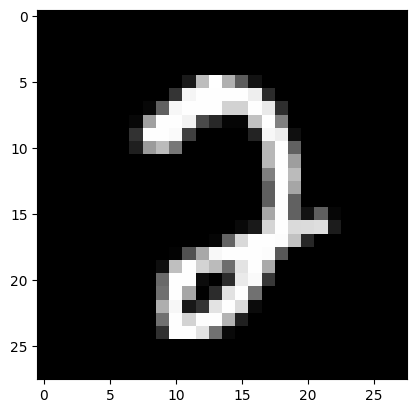

========================= 351 ===============================
test id: 7545
individual experts pred: {8: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


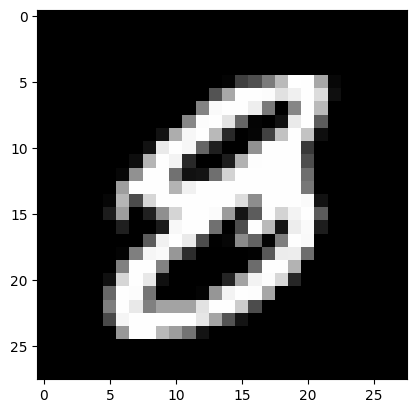

========================= 352 ===============================
test id: 7797
individual experts pred: {5: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


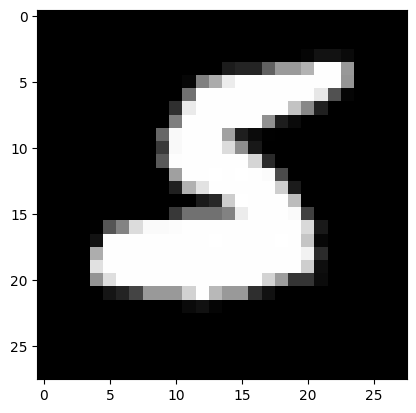

========================= 353 ===============================
test id: 7823
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


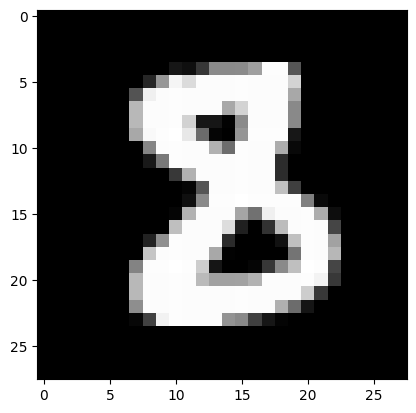

========================= 354 ===============================
test id: 7849
individual experts pred: {2: 3, 3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


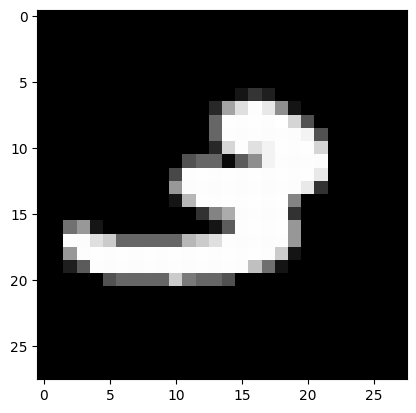

========================= 355 ===============================
test id: 7899
individual experts pred: {1: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


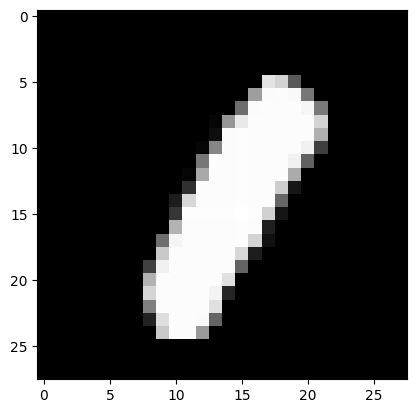

========================= 356 ===============================
test id: 7921
individual experts pred: {8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


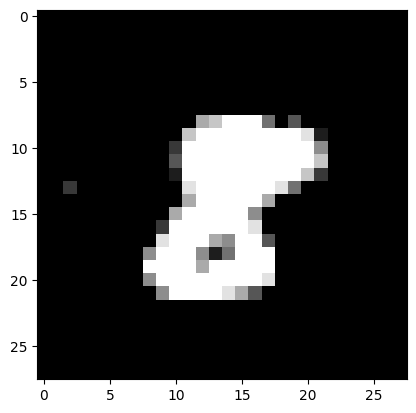

========================= 357 ===============================
test id: 7928
individual experts pred: {0: 1, 1: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


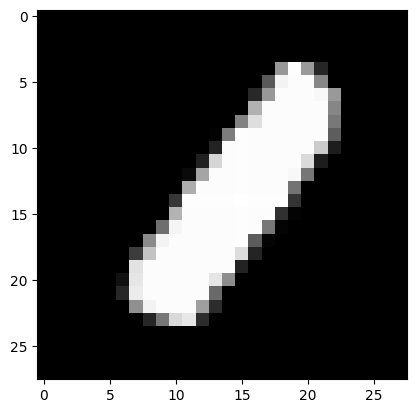

========================= 358 ===============================
test id: 7991
individual experts pred: {8: 2, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


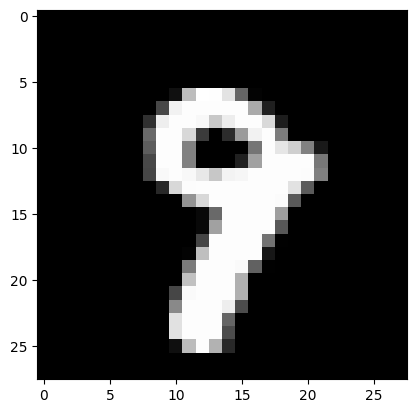

========================= 359 ===============================
test id: 8020
individual experts pred: {1: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


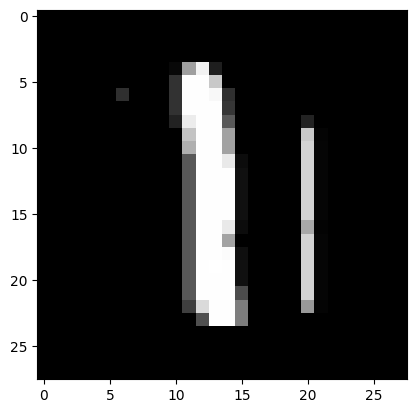

========================= 360 ===============================
test id: 8196
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


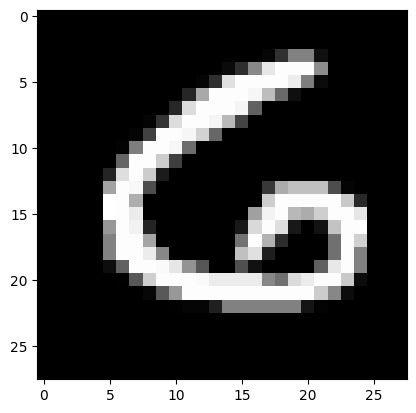

========================= 361 ===============================
test id: 8255
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


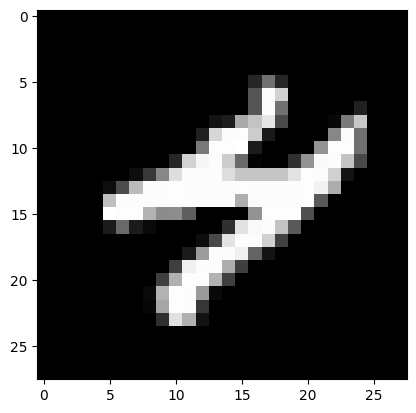

========================= 362 ===============================
test id: 8277
individual experts pred: {5: 2, 8: 3, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


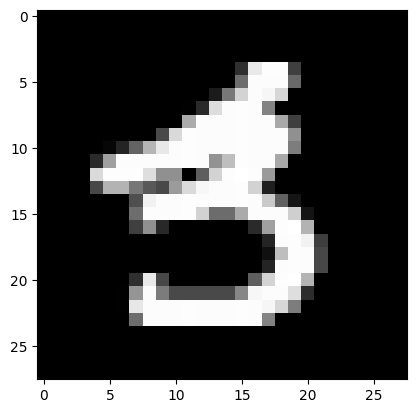

========================= 363 ===============================
test id: 8325
individual experts pred: {0: 1, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


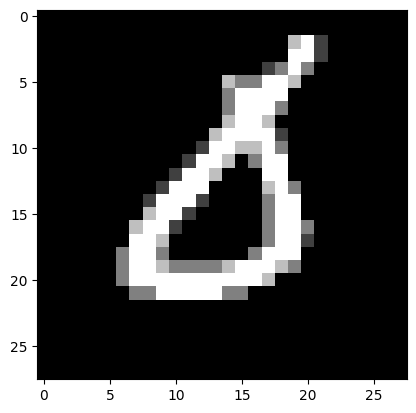

========================= 364 ===============================
test id: 8339
individual experts pred: {8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


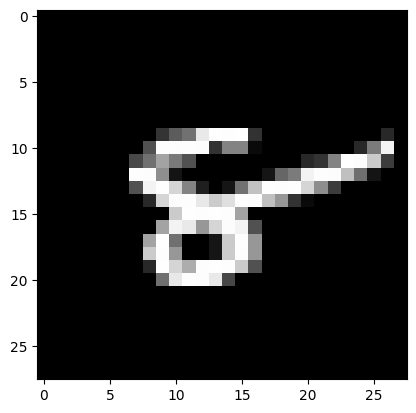

========================= 365 ===============================
test id: 8408
individual experts pred: {5: 1, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


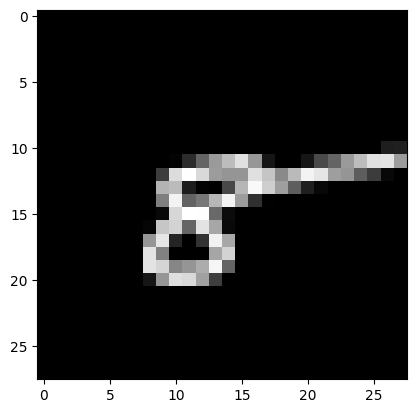

========================= 366 ===============================
test id: 8453
individual experts pred: {5: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


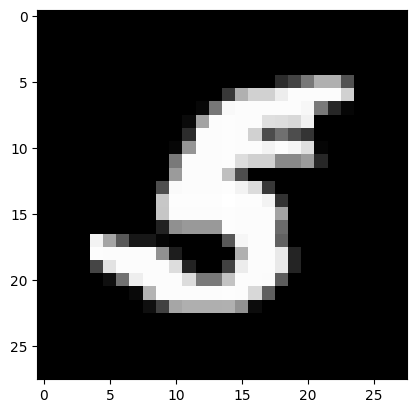

========================= 367 ===============================
test id: 8502
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


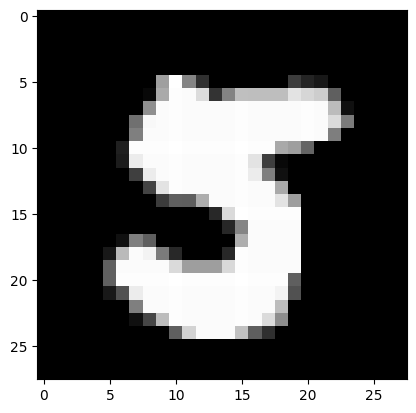

========================= 368 ===============================
test id: 8508
individual experts pred: {3: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


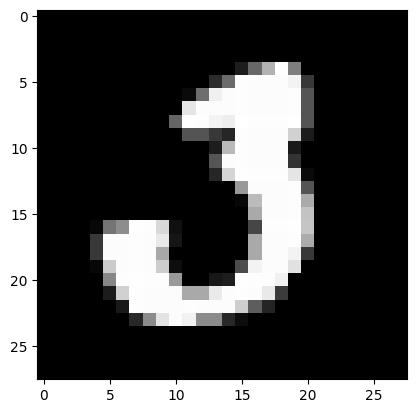

========================= 369 ===============================
test id: 8520
individual experts pred: {4: 1, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


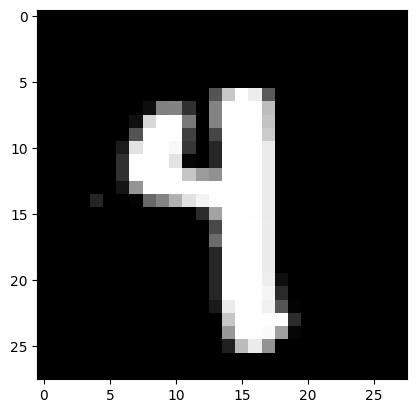

========================= 370 ===============================
test id: 8522
individual experts pred: {8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


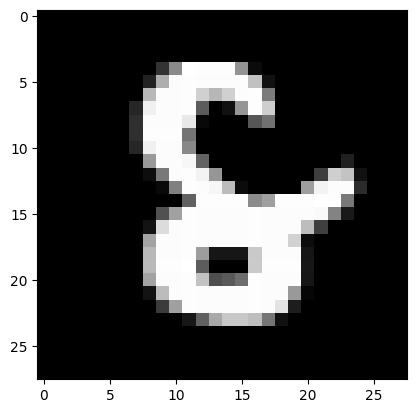

========================= 371 ===============================
test id: 8527
individual experts pred: {4: 3, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


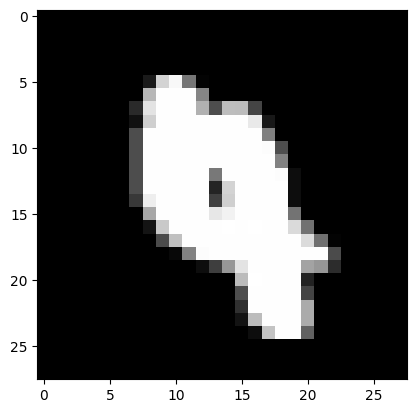

========================= 372 ===============================
test id: 8553
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


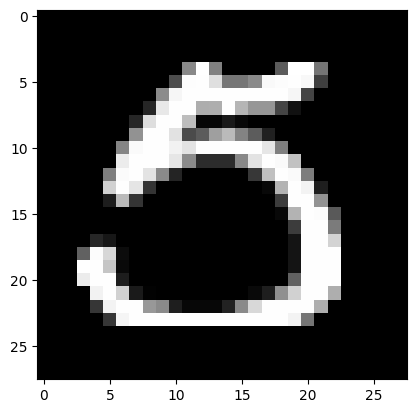

========================= 373 ===============================
test id: 8607
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


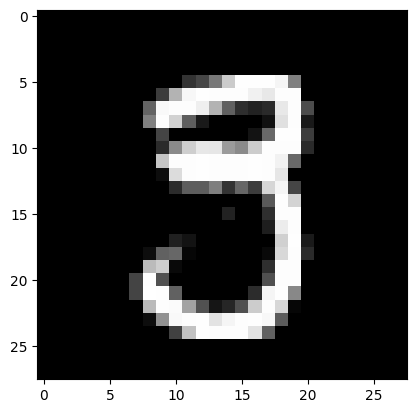

========================= 374 ===============================
test id: 9016
individual experts pred: {0: 4, 5: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


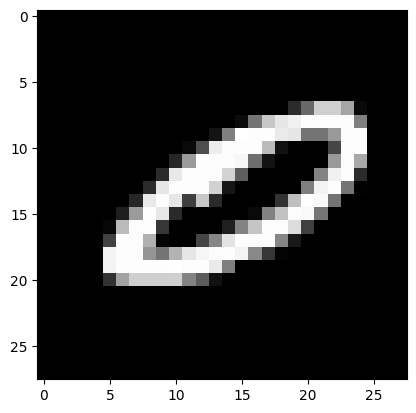

========================= 375 ===============================
test id: 9019
individual experts pred: {2: 3, 7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


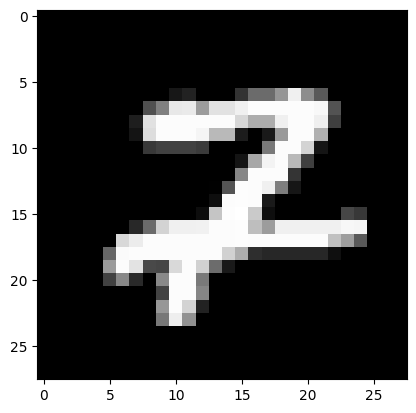

========================= 376 ===============================
test id: 9280
individual experts pred: {5: 2, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


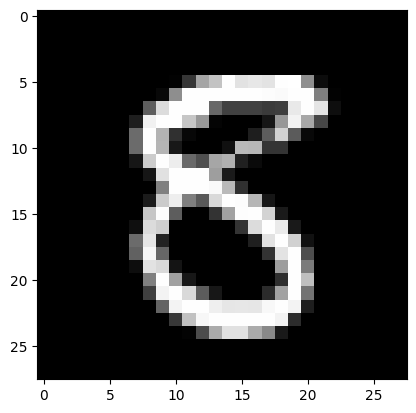

========================= 377 ===============================
test id: 9422
individual experts pred: {1: 1, 3: 1, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


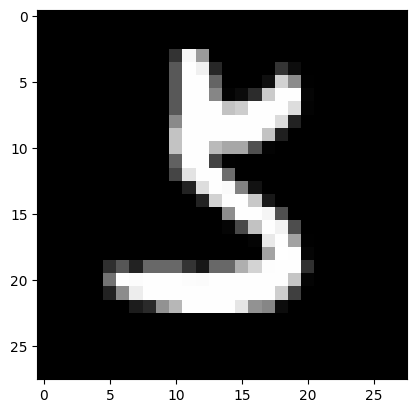

========================= 378 ===============================
test id: 9482
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


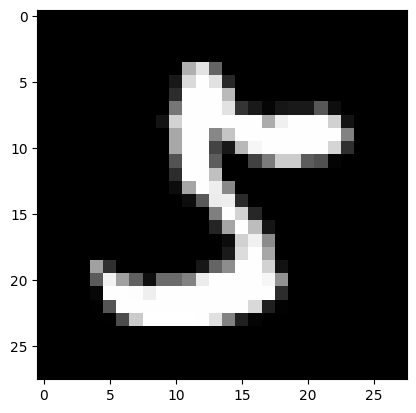

========================= 379 ===============================
test id: 9540
individual experts pred: {1: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


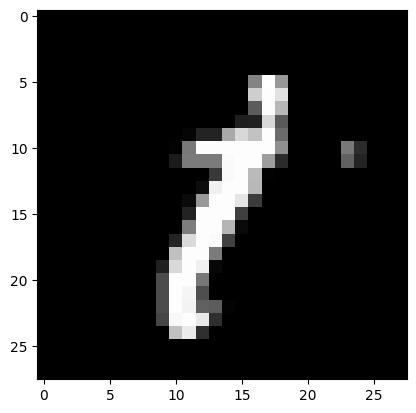

========================= 380 ===============================
test id: 9634
individual experts pred: {1: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


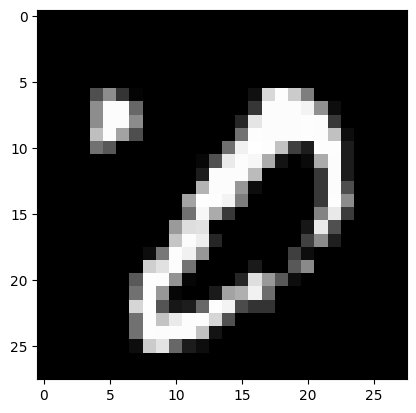

========================= 381 ===============================
test id: 9669
individual experts pred: {4: 1, 7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


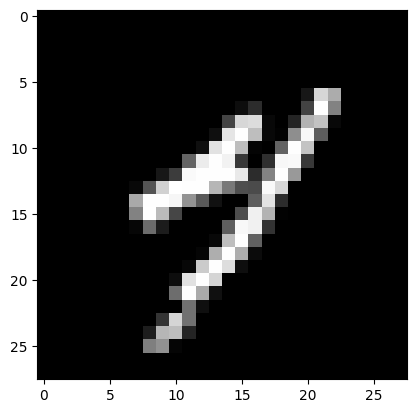

========================= 382 ===============================
test id: 9679
individual experts pred: {3: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


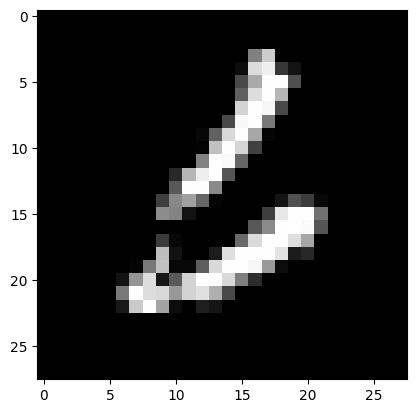

========================= 383 ===============================
test id: 9692
individual experts pred: {7: 4, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


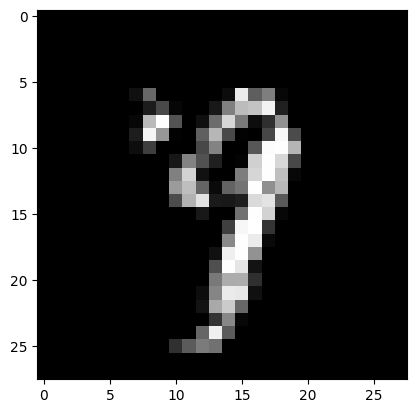

========================= 384 ===============================
test id: 9698
individual experts pred: {5: 2, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


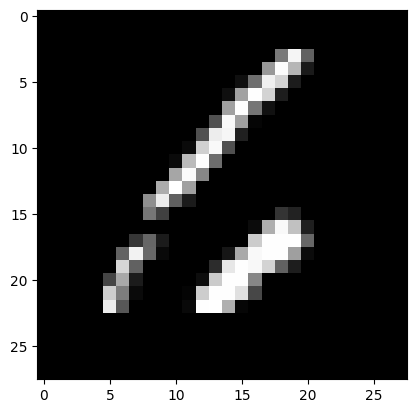

========================= 385 ===============================
test id: 9700
individual experts pred: {2: 3, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


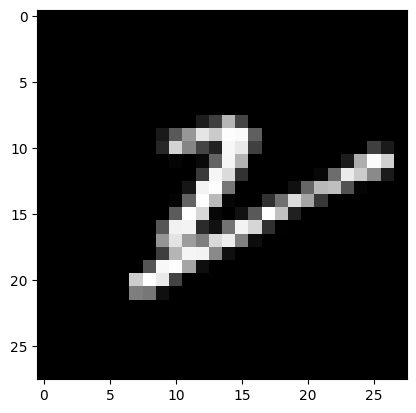

========================= 386 ===============================
test id: 9719
individual experts pred: {0: 2, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


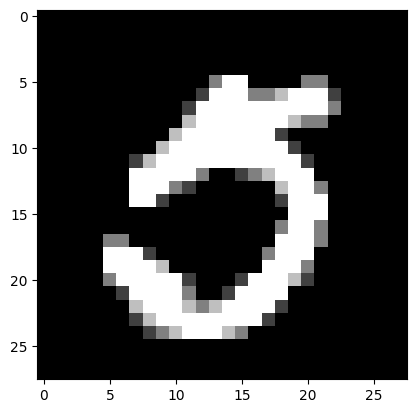

========================= 387 ===============================
test id: 9733
individual experts pred: {9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


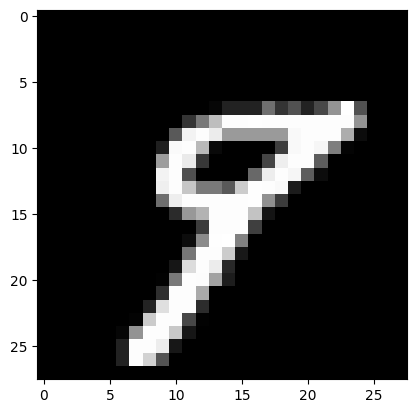

========================= 388 ===============================
test id: 9745
individual experts pred: {0: 2, 4: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


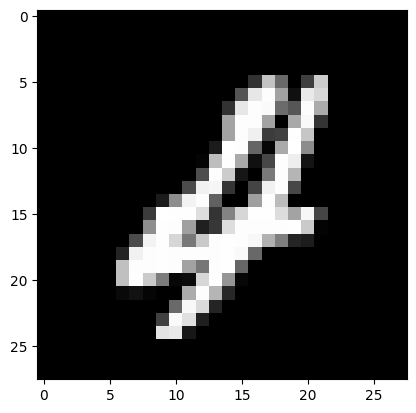

========================= 389 ===============================
test id: 9749
individual experts pred: {5: 1, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


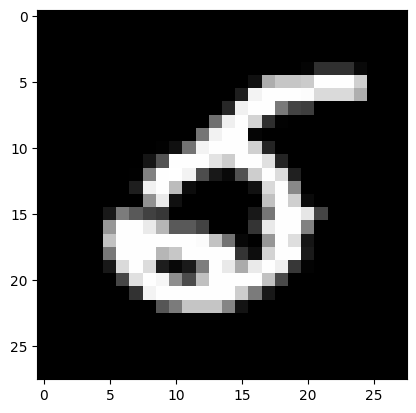

========================= 390 ===============================
test id: 9755
individual experts pred: {5: 3, 8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


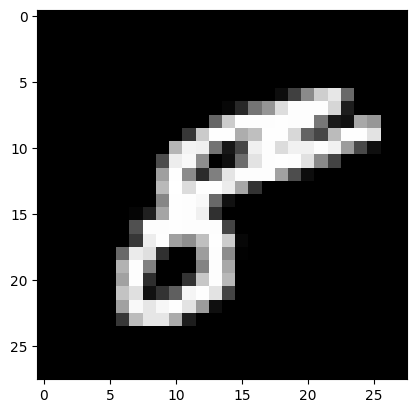

========================= 391 ===============================
test id: 9764
individual experts pred: {4: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


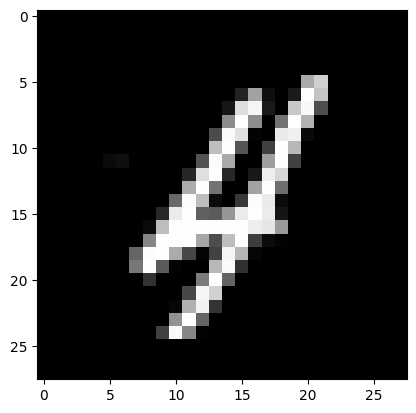

========================= 392 ===============================
test id: 9768
individual experts pred: {0: 1, 2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


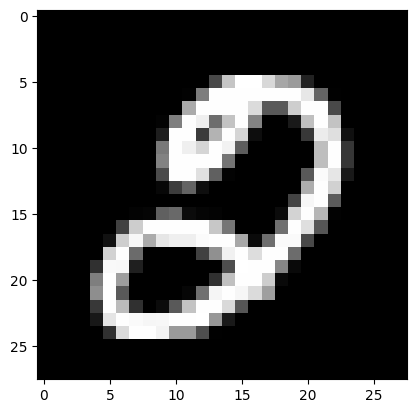

========================= 393 ===============================
test id: 9770
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


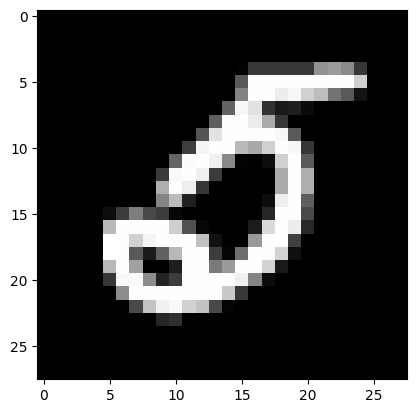

========================= 394 ===============================
test id: 9782
individual experts pred: {5: 1, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


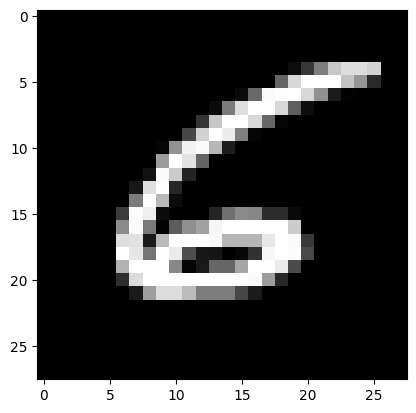

========================= 395 ===============================
test id: 9792
individual experts pred: {1: 1, 4: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


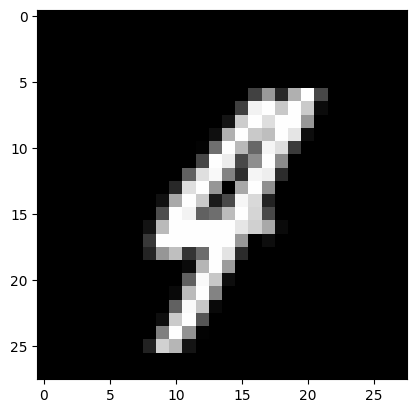

========================= 396 ===============================
test id: 9811
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


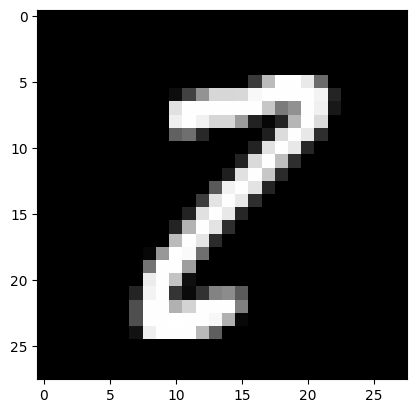

========================= 397 ===============================
test id: 9839
individual experts pred: {}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


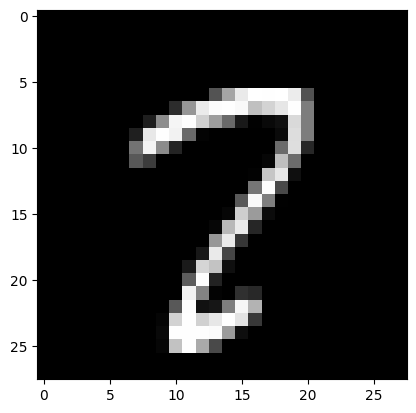

========================= 398 ===============================
test id: 9847
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


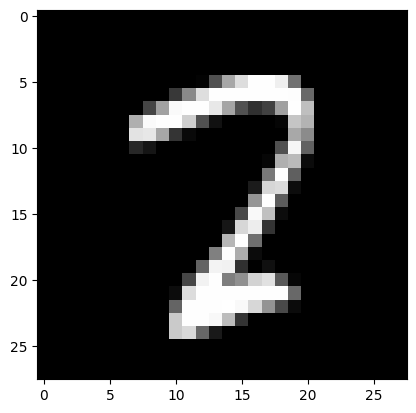

========================= 399 ===============================
test id: 9858
individual experts pred: {6: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


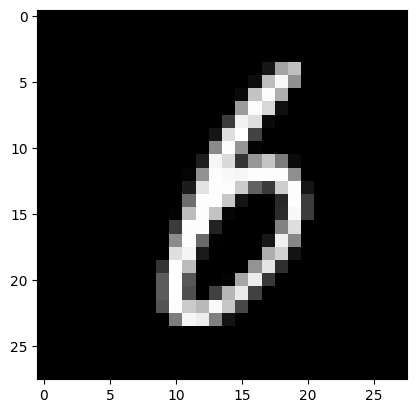

========================= 400 ===============================
test id: 9879
individual experts pred: {0: 3, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


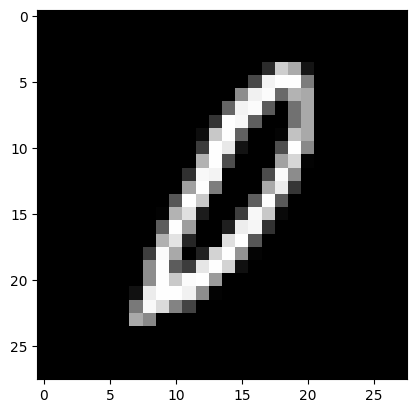

========================= 401 ===============================
test id: 9888
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


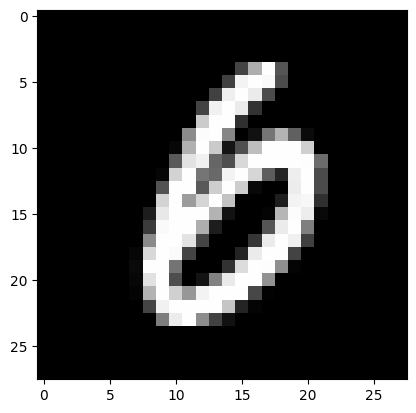

========================= 402 ===============================
test id: 9892
individual experts pred: {8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


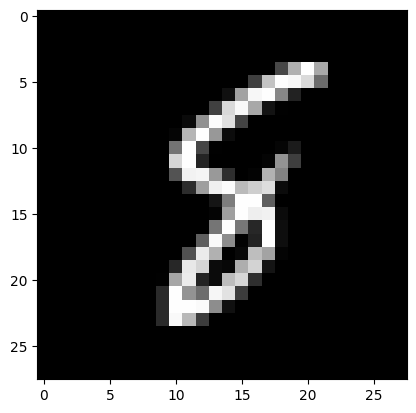

========================= 403 ===============================
test id: 9904
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


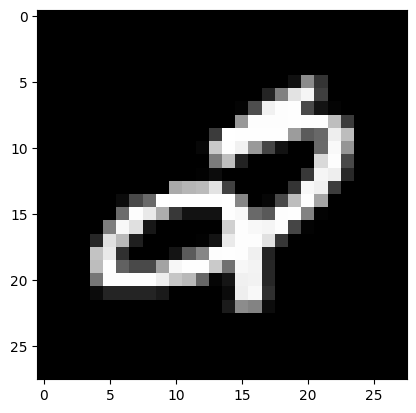

========================= 404 ===============================
test id: 9925
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


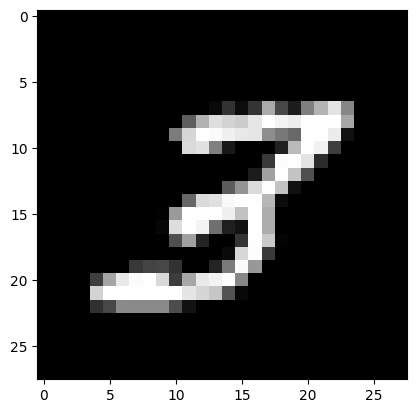

========================= 405 ===============================
test id: 9941
individual experts pred: {5: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


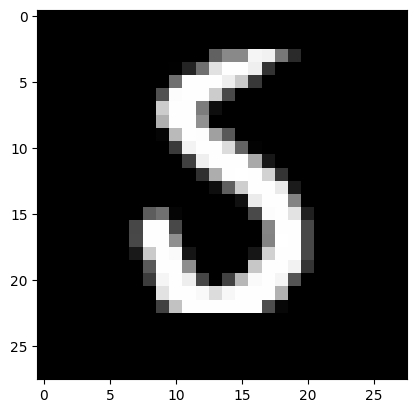

========================= 406 ===============================
test id: 9944
individual experts pred: {}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


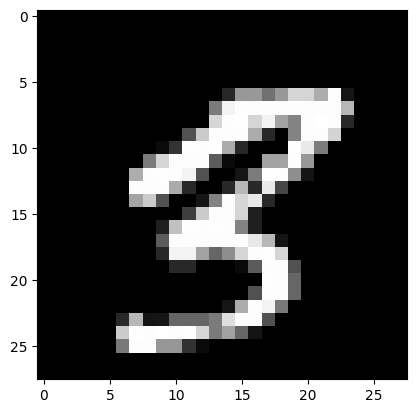

========================= 407 ===============================
test id: 9975
individual experts pred: {3: 2, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


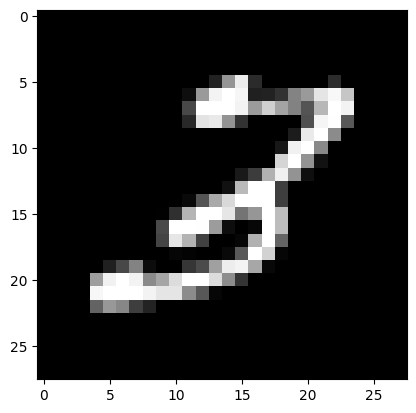

========================= 408 ===============================
test id: 9982
individual experts pred: {5: 4, 6: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


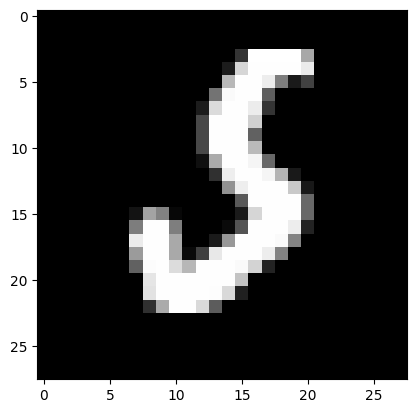

In [18]:
pred_set_size = {i: [] for i in range(10)}
max_voting_correct_count = 0
for i, id_ in enumerate(np.arange(len(zero_preds_))[np.array(zero_preds_)]):
# for id_ in np.arange(len(nlls_))[np.array(infs)]:
    print(f"========================= {i} ===============================")
    print(f"test id: {id_}")
    # print(ovr_err(logits[id_], y_test[id_]), max_voting(logits[id_], y_test[id_]))
    # print(nn.sigmoid(logits[id_]).round())
    individual_preds = get_experts_preds(nn.sigmoid(logits[id_]).round())
    print(f"individual experts pred: {individual_preds}" )
    print(f"PoE predictive: {ovr_prod_probs(logits[id_])}")
    print(f"true label: {y_test[id_]}")
    plt.imshow(X_test[id_].reshape(28, 28), cmap='gray')
    plt.show()
    # print(ovr_err(logits[id_], y_test[id_]))
    pred_set_size_i = len(individual_preds)
    pred_set_size[pred_set_size_i].append(id_)
    if individual_preds and max(individual_preds, key=individual_preds.get) == y_test[id_]:
        max_voting_correct_count += 1

#### if max voting is used when full-ensemble prediction is 0, 70% of OOD samples would be correctly classified

In [17]:
max_voting_correct_count / zero_preds_.sum()

DeviceArray(0.69193155, dtype=float32)

#### closer look at OOD test samples with the "largest" predictive sets/predictive distribution support

Some look very strange indeed, however some digits look very normal. so at least based on the first impression, prediction set size might not be the best metric to measure "OODness" of samples

In [30]:
for i, ids in pred_set_size.items():
    print(f"nr. of OOD samples with predictivon set of size {i}: {len(ids)}")

nr. of OOD samples with predictivon set of size 0: 7
nr. of OOD samples with predictivon set of size 1: 179
nr. of OOD samples with predictivon set of size 2: 203
nr. of OOD samples with predictivon set of size 3: 20
nr. of OOD samples with predictivon set of size 4: 0
nr. of OOD samples with predictivon set of size 5: 0
nr. of OOD samples with predictivon set of size 6: 0
nr. of OOD samples with predictivon set of size 7: 0
nr. of OOD samples with predictivon set of size 8: 0
nr. of OOD samples with predictivon set of size 9: 0


========================= 0 ===============================
test id: 149
individual experts pred: {2: 1, 4: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


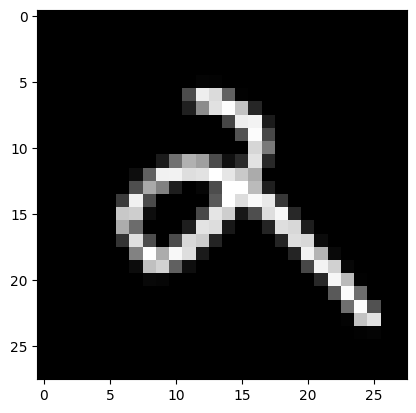

True
========================= 1 ===============================
test id: 448
individual experts pred: {3: 1, 8: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


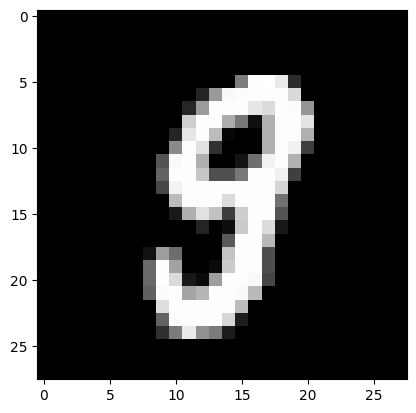

True
========================= 2 ===============================
test id: 583
individual experts pred: {2: 2, 7: 4, 8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


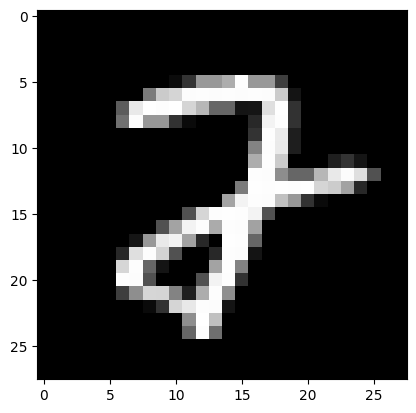

True
========================= 3 ===============================
test id: 610
individual experts pred: {2: 1, 4: 4, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


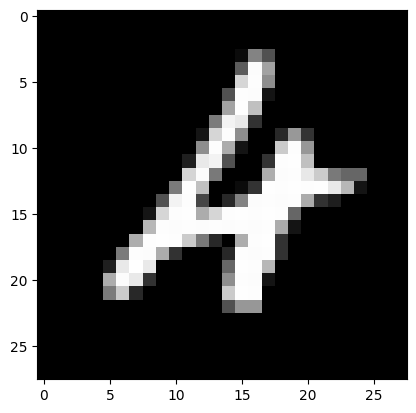

True
========================= 4 ===============================
test id: 1032
individual experts pred: {5: 1, 6: 1, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


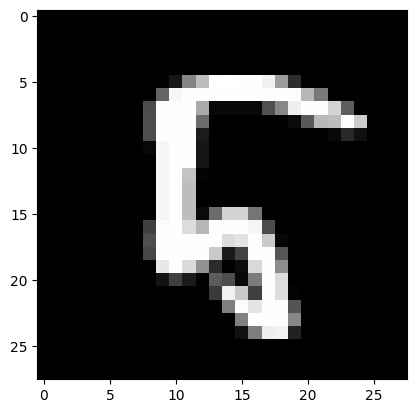

True
========================= 5 ===============================
test id: 1224
individual experts pred: {2: 4, 4: 1, 5: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


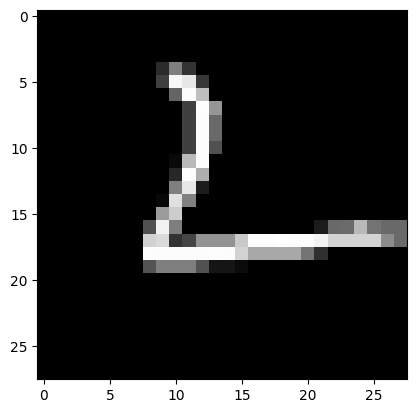

True
========================= 6 ===============================
test id: 1790
individual experts pred: {2: 1, 8: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


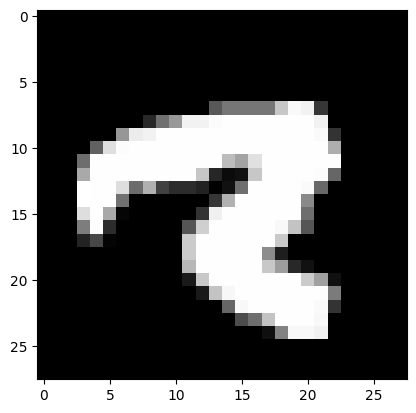

True
========================= 7 ===============================
test id: 2185
individual experts pred: {0: 2, 5: 1, 8: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


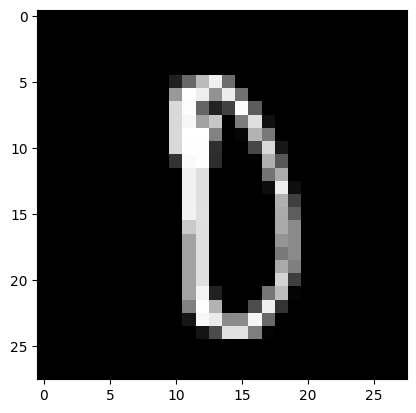

False
========================= 8 ===============================
test id: 2877
individual experts pred: {4: 1, 7: 2, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


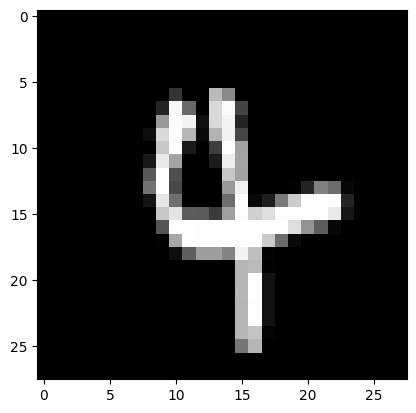

True
========================= 9 ===============================
test id: 3005
individual experts pred: {1: 1, 8: 1, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


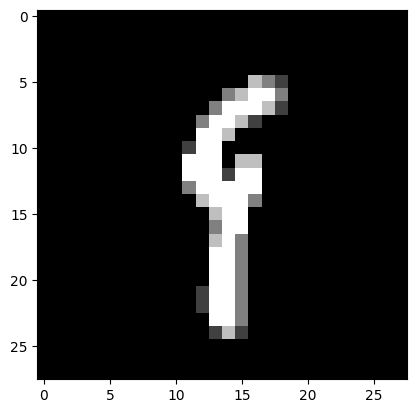

True
========================= 10 ===============================
test id: 4075
individual experts pred: {0: 3, 3: 1, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


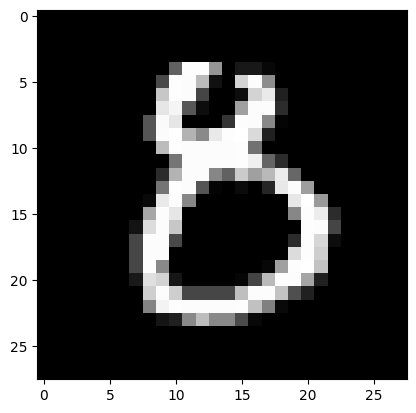

True
========================= 11 ===============================
test id: 4306
individual experts pred: {3: 2, 7: 3, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


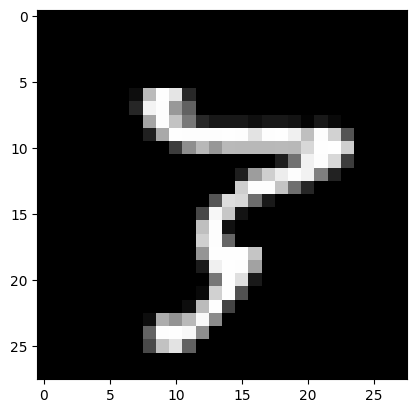

True
========================= 12 ===============================
test id: 4355
individual experts pred: {3: 1, 5: 2, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


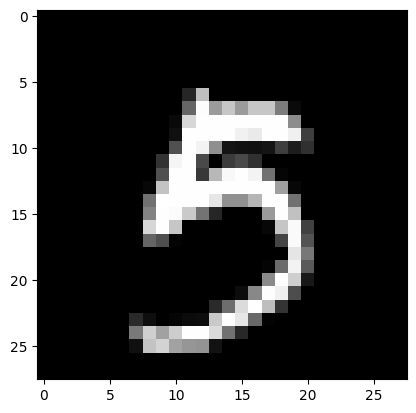

True
========================= 13 ===============================
test id: 4507
individual experts pred: {1: 4, 7: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


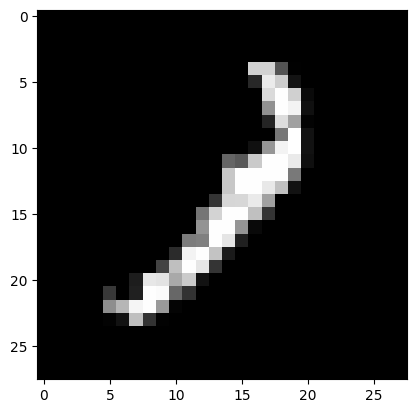

True
========================= 14 ===============================
test id: 4823
individual experts pred: {4: 2, 6: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


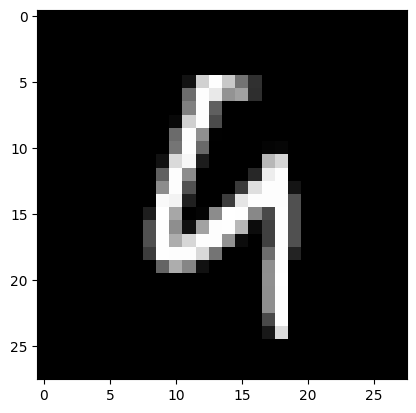

True
========================= 15 ===============================
test id: 5835
individual experts pred: {7: 2, 8: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


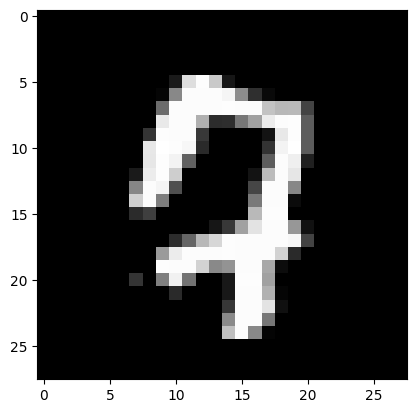

True
========================= 16 ===============================
test id: 6081
individual experts pred: {3: 1, 5: 1, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


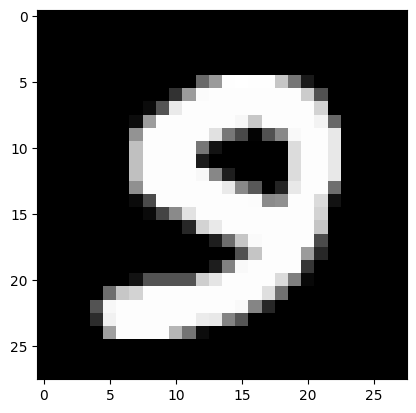

True
========================= 17 ===============================
test id: 8277
individual experts pred: {5: 2, 8: 3, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


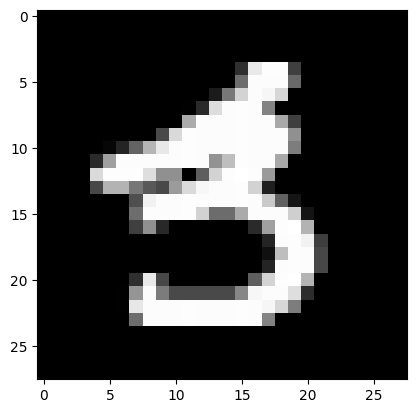

True
========================= 18 ===============================
test id: 9422
individual experts pred: {1: 1, 3: 1, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


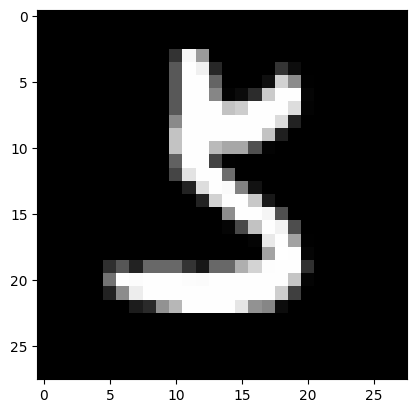

True
========================= 19 ===============================
test id: 9792
individual experts pred: {1: 1, 4: 1, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


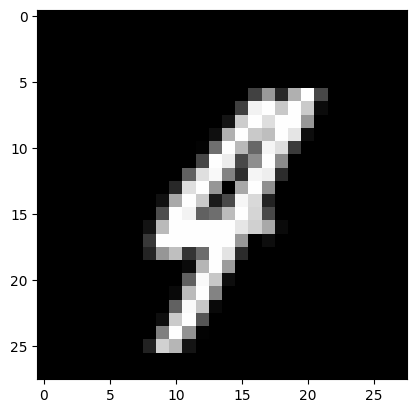

True


In [31]:
for i, id_ in enumerate(pred_set_size[3]):
# for id_ in np.arange(len(nlls_))[np.array(infs)]:
    print(f"========================= {i} ===============================")
    print(f"test id: {id_}")
    # print(nn.sigmoid(logits[id_]).round())
    individual_preds = get_experts_preds(nn.sigmoid(logits[id_]).round())
    print(f"individual experts pred: {individual_preds}" )
    print(f"PoE predictive: {ovr_prod_probs(logits[id_])}")
    print(f"true label: {y_test[id_]}")
    plt.imshow(X_test[id_].reshape(28, 28), cmap='gray')
    plt.show()
    print(ovr_err(logits[id_], y_test[id_]))
#     pred_set_size_i = len(individual_preds)
#     pred_set_size[pred_set_size_i].append(id_)

## 2) train OOD samples

========================= 0 ===============================
test id: 823
individual experts pred: {8: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


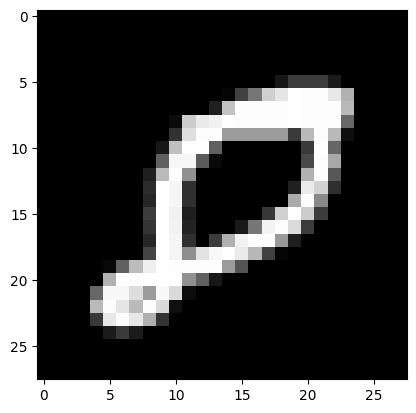

True
========================= 1 ===============================
test id: 1056
individual experts pred: {2: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


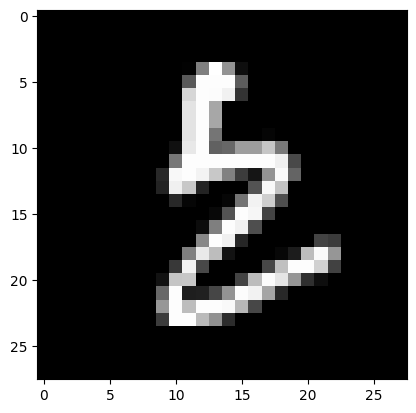

True
========================= 2 ===============================
test id: 2610
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


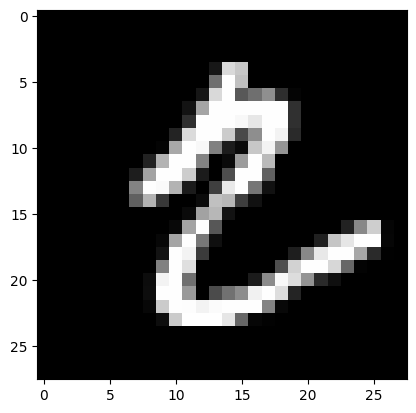

True
========================= 3 ===============================
test id: 3051
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


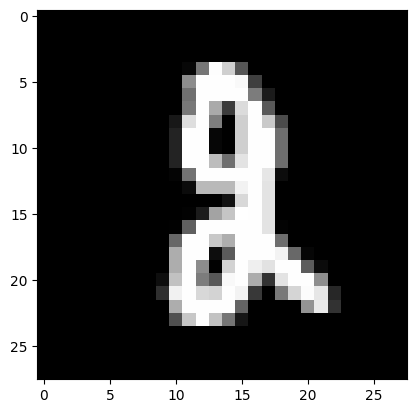

True
========================= 4 ===============================
test id: 3195
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


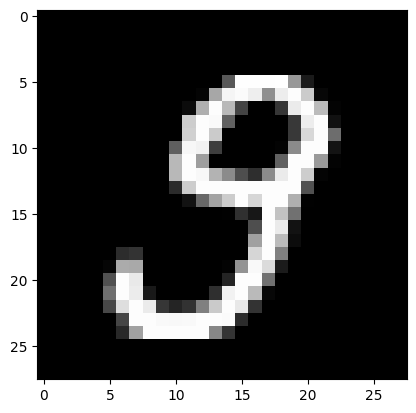

True
========================= 5 ===============================
test id: 3197
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


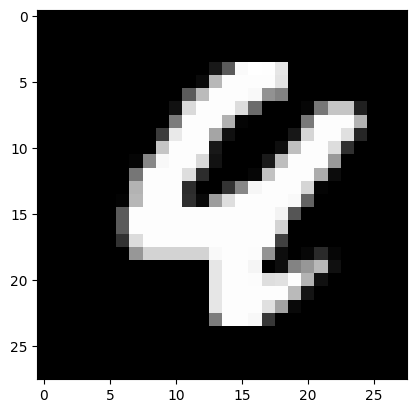

True
========================= 6 ===============================
test id: 3775
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


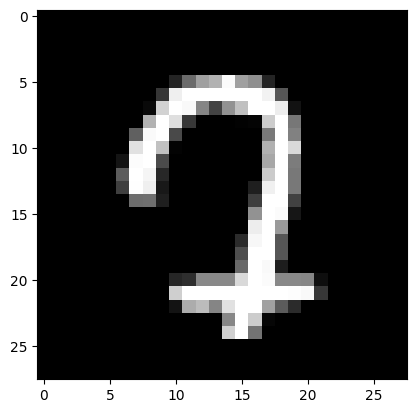

True
========================= 7 ===============================
test id: 5044
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


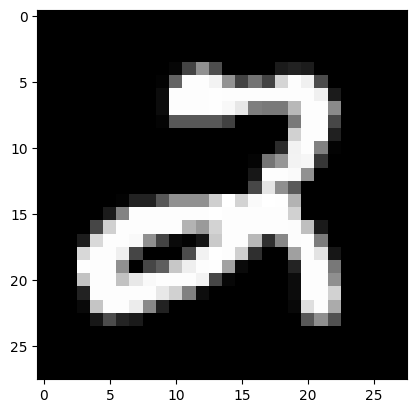

True
========================= 8 ===============================
test id: 5283
individual experts pred: {5: 1, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


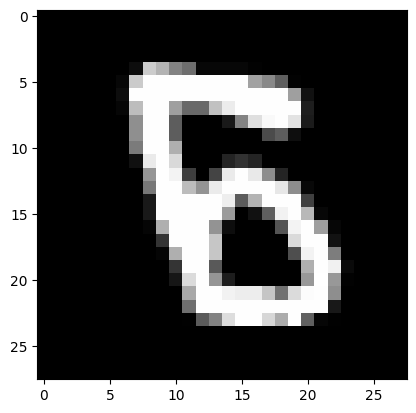

True
========================= 9 ===============================
test id: 5666
individual experts pred: {3: 4, 5: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


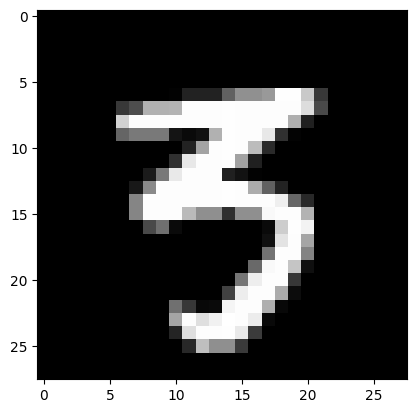

True
========================= 10 ===============================
test id: 5994
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


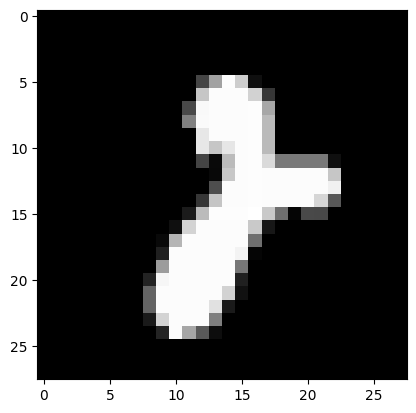

True
========================= 11 ===============================
test id: 6485
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


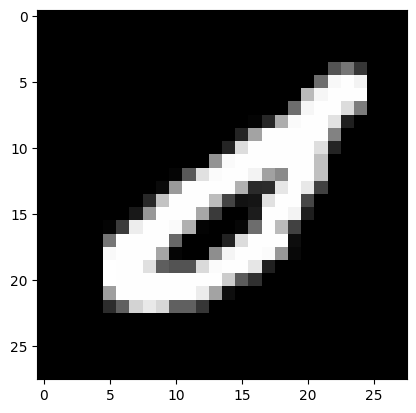

False
========================= 12 ===============================
test id: 6597
individual experts pred: {4: 4, 9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


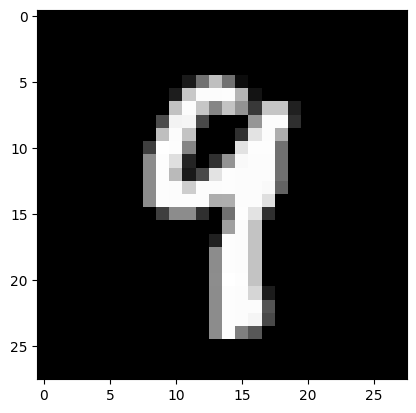

True
========================= 13 ===============================
test id: 7279
individual experts pred: {2: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


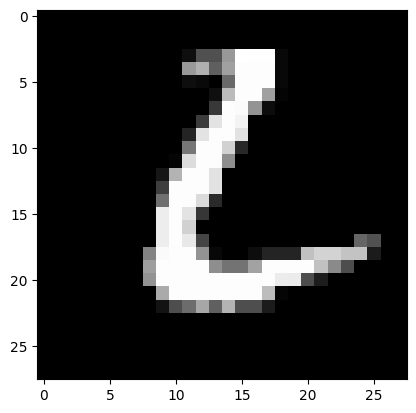

True
========================= 14 ===============================
test id: 7336
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


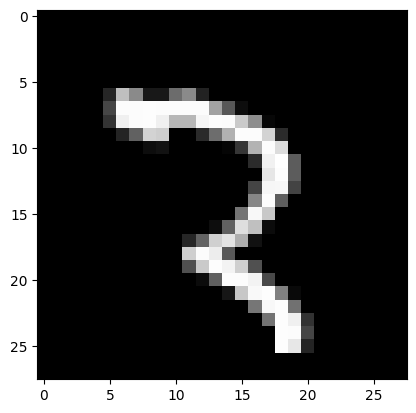

True
========================= 15 ===============================
test id: 8019
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


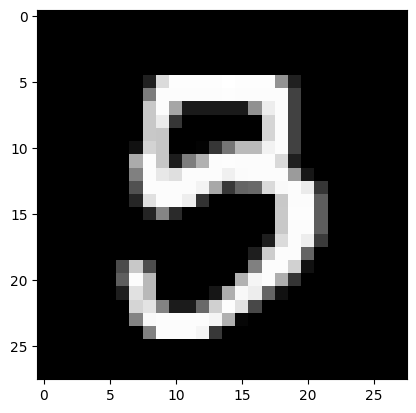

True
========================= 16 ===============================
test id: 8075
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


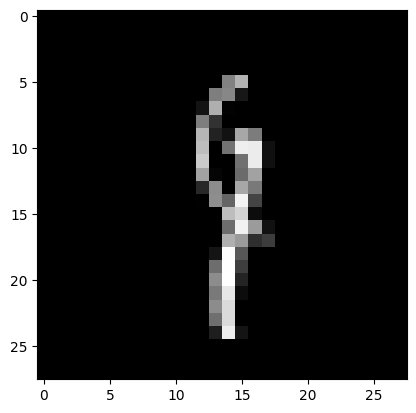

True
========================= 17 ===============================
test id: 9164
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


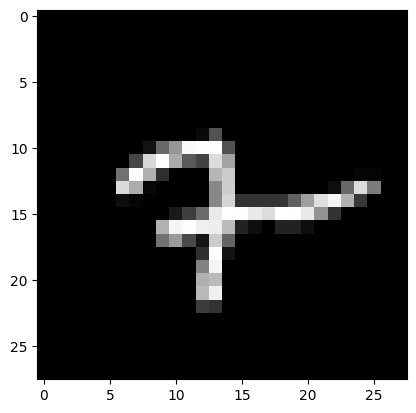

True
========================= 18 ===============================
test id: 10062
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


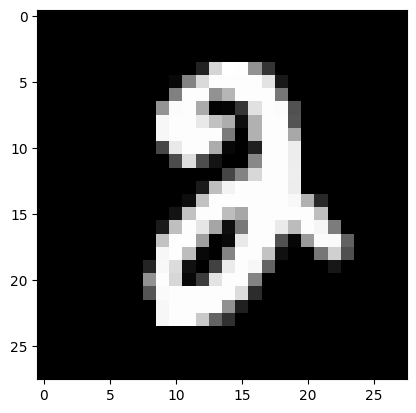

True
========================= 19 ===============================
test id: 10091
individual experts pred: {6: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


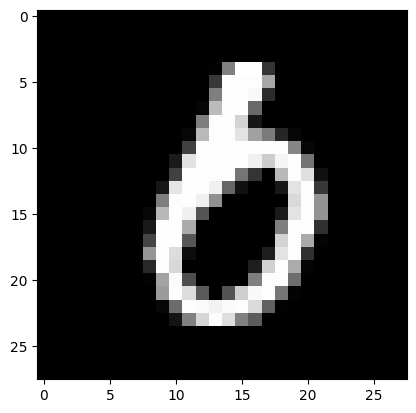

True
========================= 20 ===============================
test id: 10185
individual experts pred: {1: 1, 7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


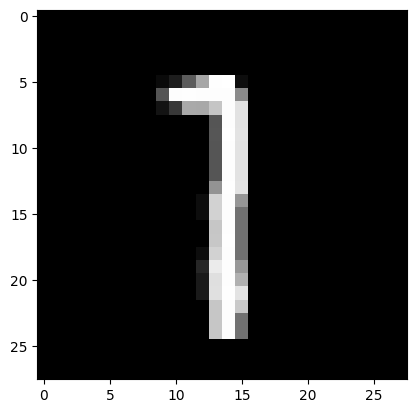

True
========================= 21 ===============================
test id: 11600
individual experts pred: {1: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


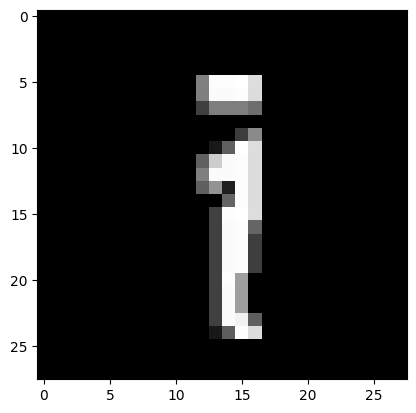

True
========================= 22 ===============================
test id: 11783
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


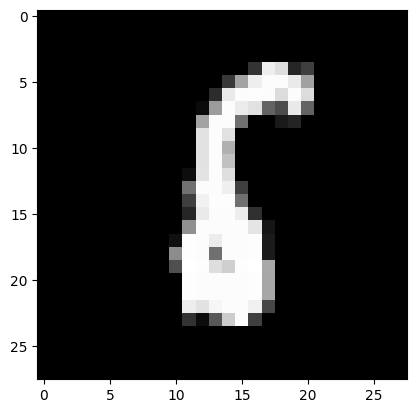

True
========================= 23 ===============================
test id: 12604
individual experts pred: {5: 4, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


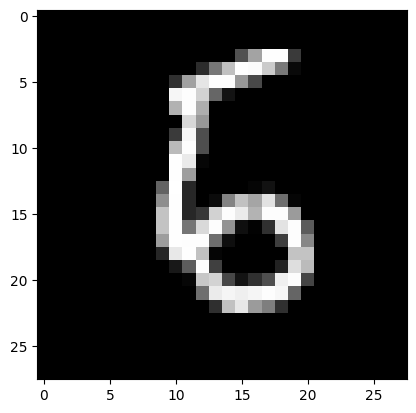

True
========================= 24 ===============================
test id: 12732
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


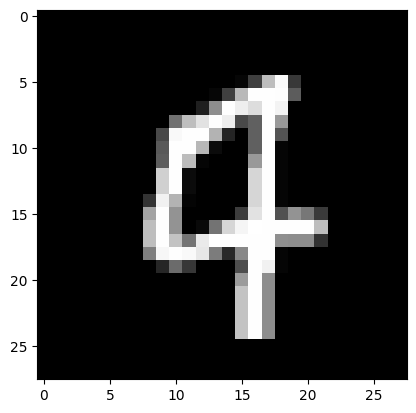

True
========================= 25 ===============================
test id: 13839
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


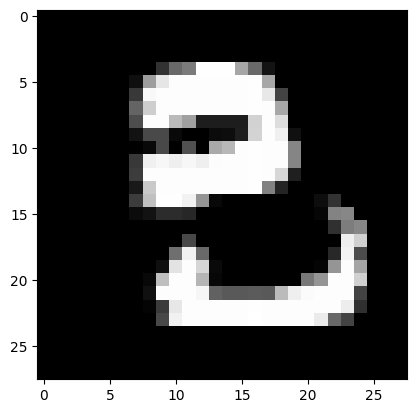

True
========================= 26 ===============================
test id: 14083
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


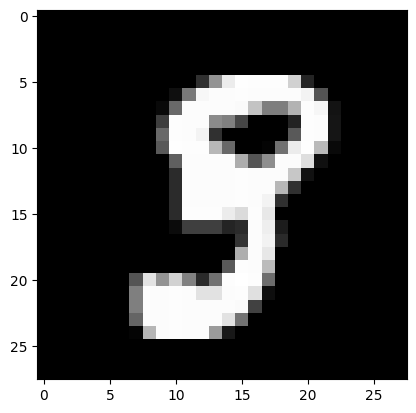

True
========================= 27 ===============================
test id: 14288
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


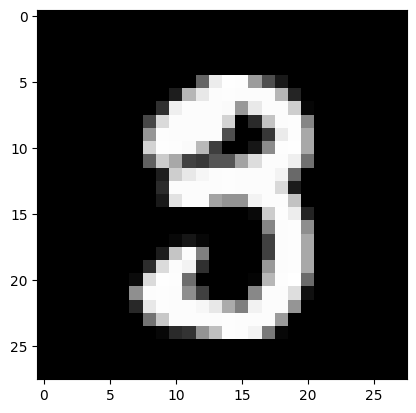

True
========================= 28 ===============================
test id: 15283
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


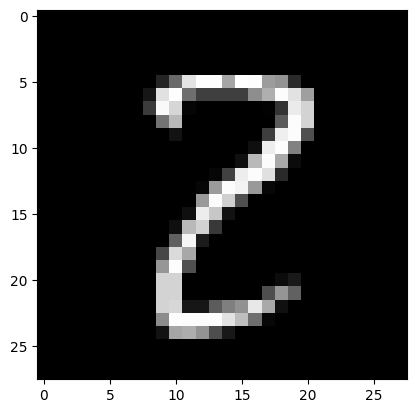

True
========================= 29 ===============================
test id: 15358
individual experts pred: {1: 1, 4: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


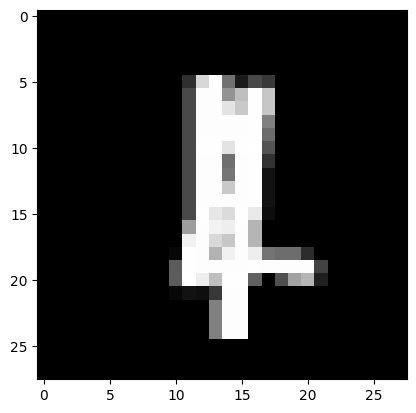

True
========================= 30 ===============================
test id: 15491
individual experts pred: {0: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


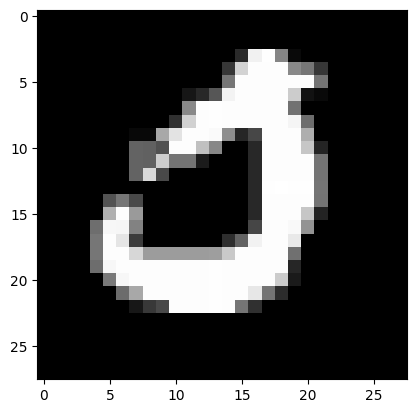

False
========================= 31 ===============================
test id: 16054
individual experts pred: {4: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


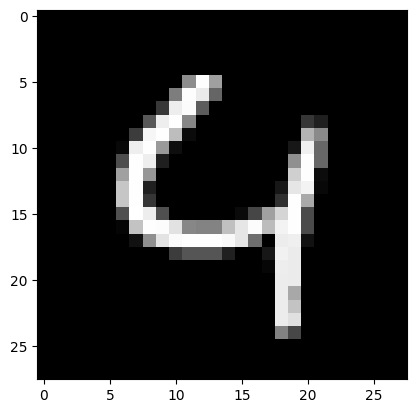

True
========================= 32 ===============================
test id: 16082
individual experts pred: {4: 4, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


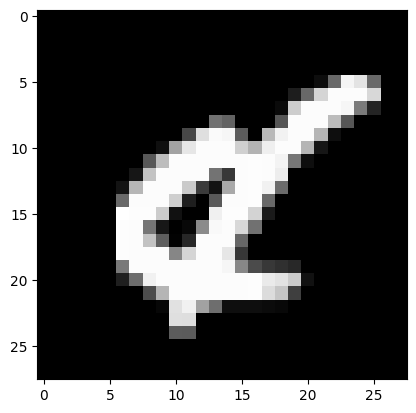

True
========================= 33 ===============================
test id: 16573
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


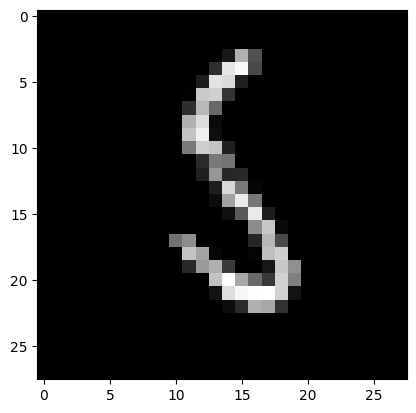

True
========================= 34 ===============================
test id: 16808
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


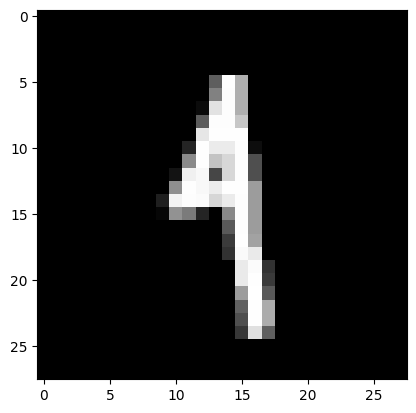

True
========================= 35 ===============================
test id: 17664
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


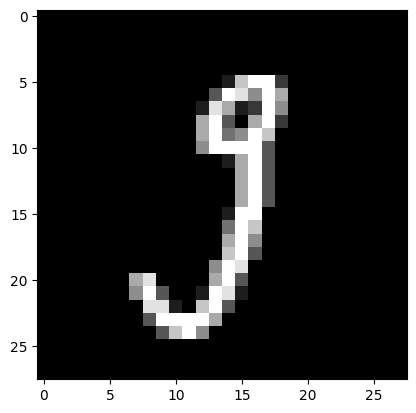

True
========================= 36 ===============================
test id: 17977
individual experts pred: {1: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


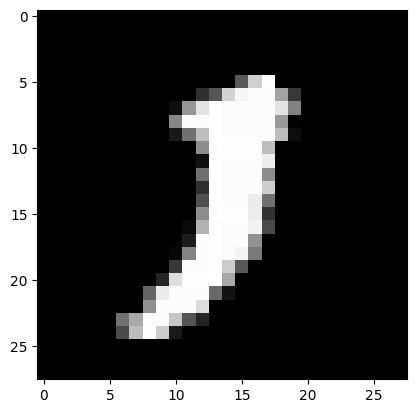

True
========================= 37 ===============================
test id: 18362
individual experts pred: {4: 4, 6: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


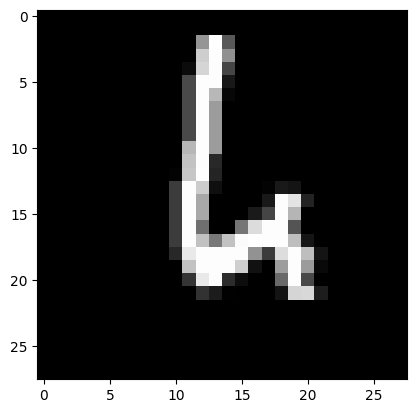

True
========================= 38 ===============================
test id: 20308
individual experts pred: {5: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


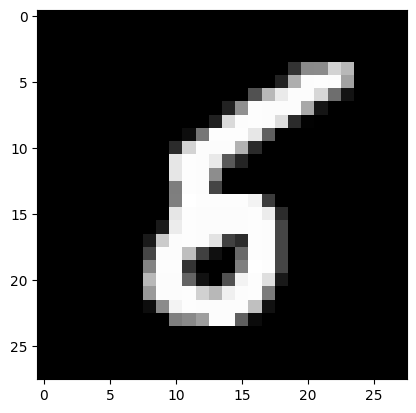

True
========================= 39 ===============================
test id: 20544
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


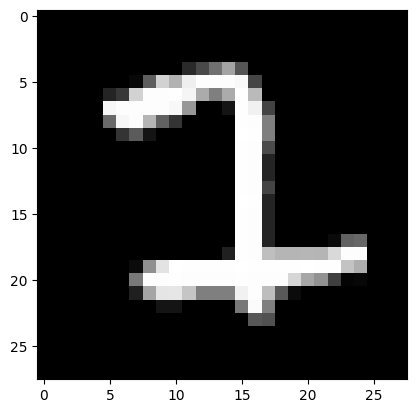

True
========================= 40 ===============================
test id: 21452
individual experts pred: {4: 1, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


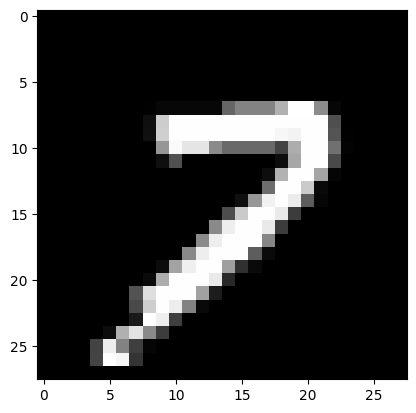

True
========================= 41 ===============================
test id: 21505
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


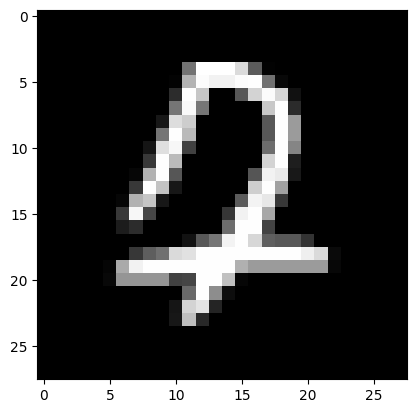

True
========================= 42 ===============================
test id: 21757
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


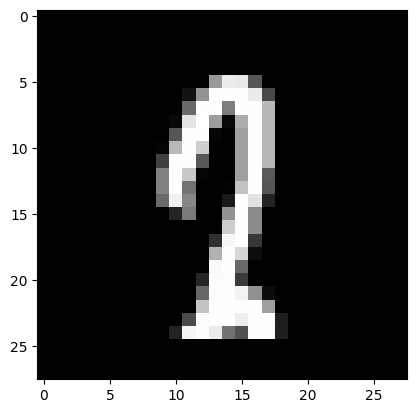

True
========================= 43 ===============================
test id: 24637
individual experts pred: {1: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


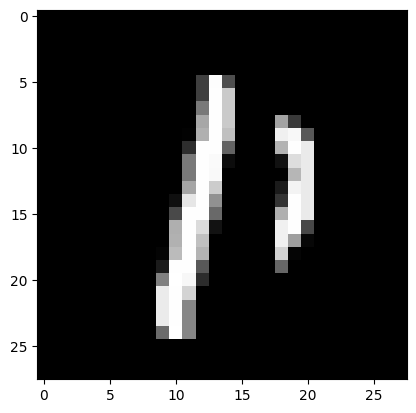

True
========================= 44 ===============================
test id: 25376
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


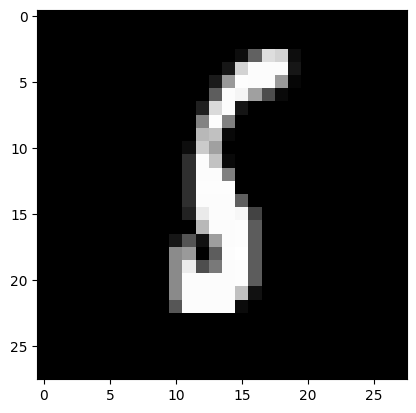

True
========================= 45 ===============================
test id: 25465
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


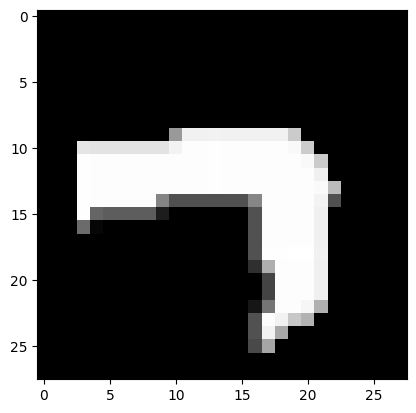

True
========================= 46 ===============================
test id: 26143
individual experts pred: {4: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


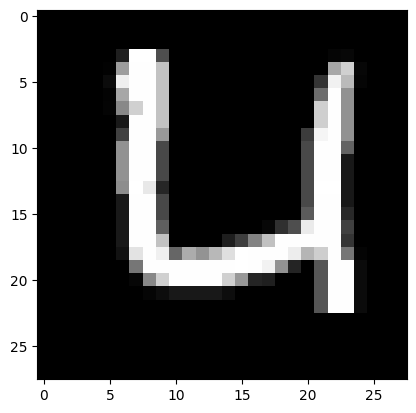

True
========================= 47 ===============================
test id: 26202
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


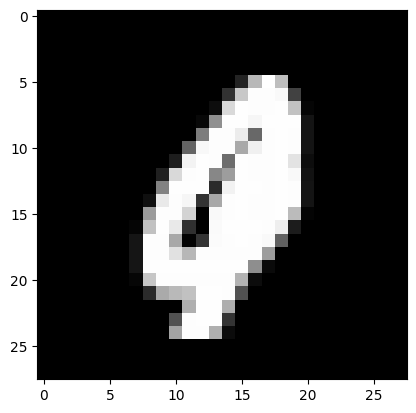

True
========================= 48 ===============================
test id: 26447
individual experts pred: {1: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


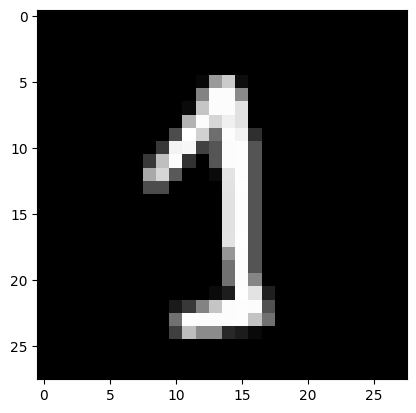

True
========================= 49 ===============================
test id: 26570
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


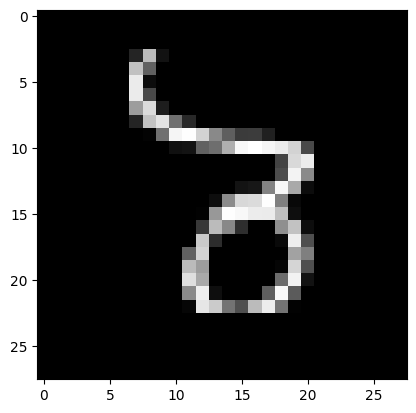

True
========================= 50 ===============================
test id: 27221
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


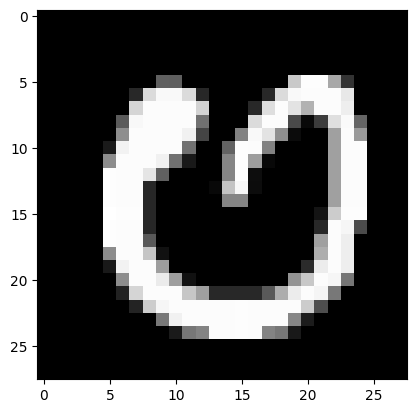

False
========================= 51 ===============================
test id: 28460
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


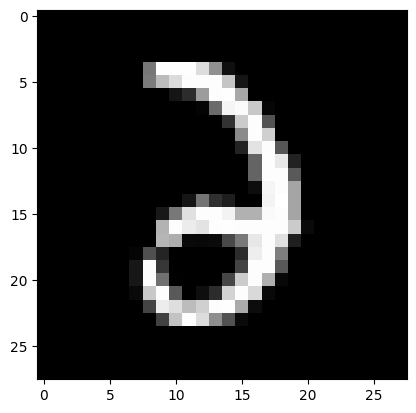

True
========================= 52 ===============================
test id: 28495
individual experts pred: {4: 4, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 4


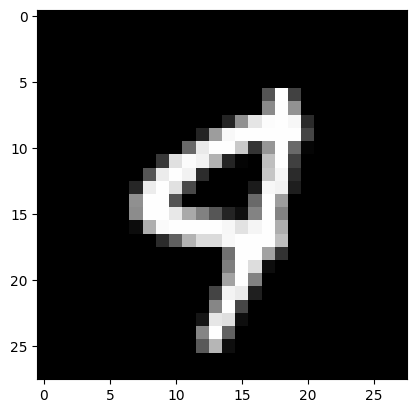

True
========================= 53 ===============================
test id: 29827
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


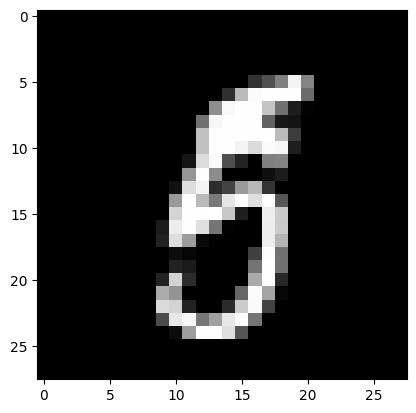

True
========================= 54 ===============================
test id: 31235
individual experts pred: {3: 3, 5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


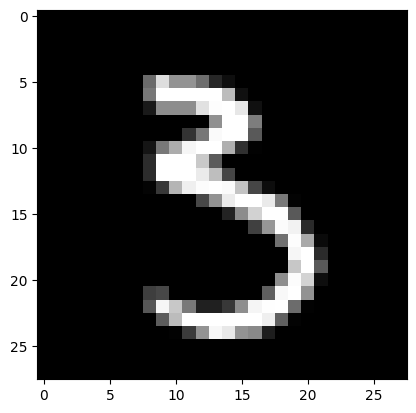

True
========================= 55 ===============================
test id: 32012
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


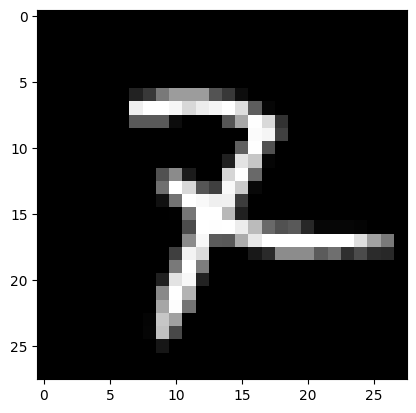

True
========================= 56 ===============================
test id: 32951
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


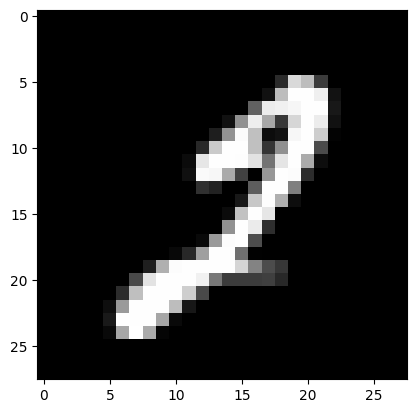

True
========================= 57 ===============================
test id: 34268
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


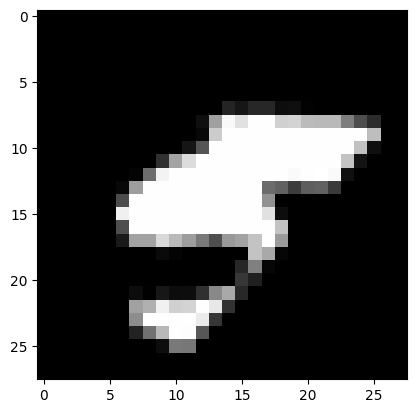

True
========================= 58 ===============================
test id: 34918
individual experts pred: {7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


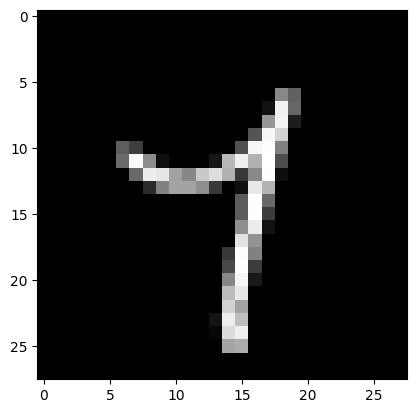

True
========================= 59 ===============================
test id: 36874
individual experts pred: {3: 4, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


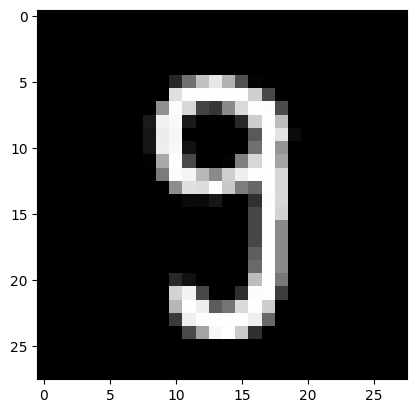

True
========================= 60 ===============================
test id: 38242
individual experts pred: {1: 4, 9: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


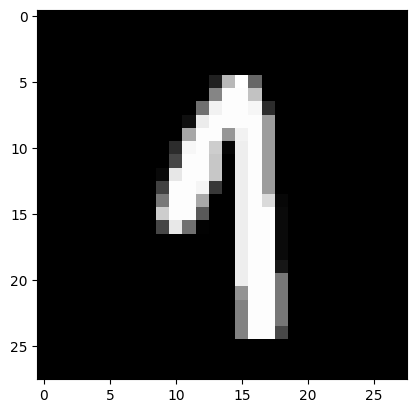

True
========================= 61 ===============================
test id: 38269
individual experts pred: {3: 4, 7: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


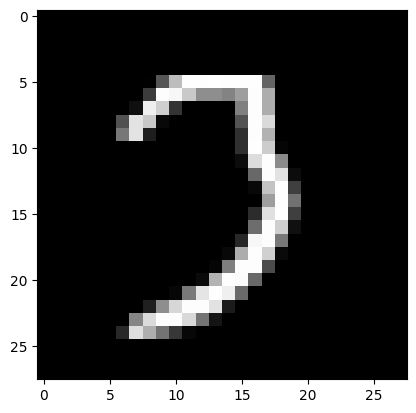

True
========================= 62 ===============================
test id: 38503
individual experts pred: {3: 3, 9: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


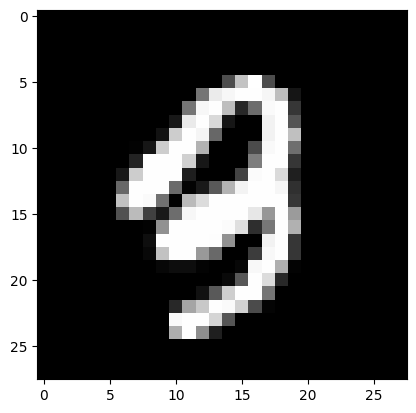

True
========================= 63 ===============================
test id: 38854
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


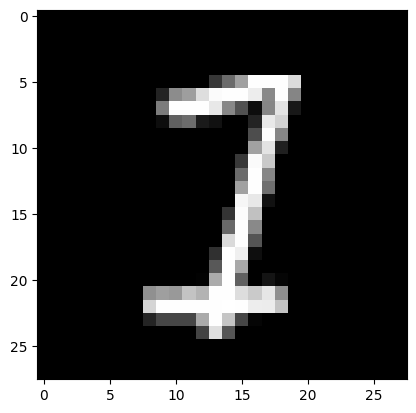

True
========================= 64 ===============================
test id: 39023
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


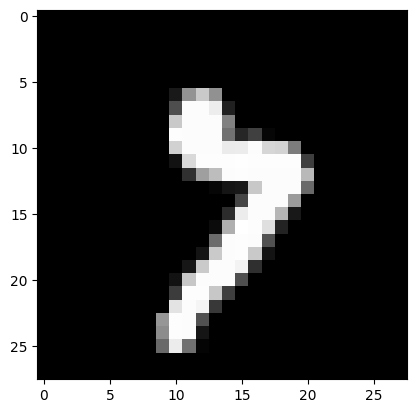

True
========================= 65 ===============================
test id: 39169
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


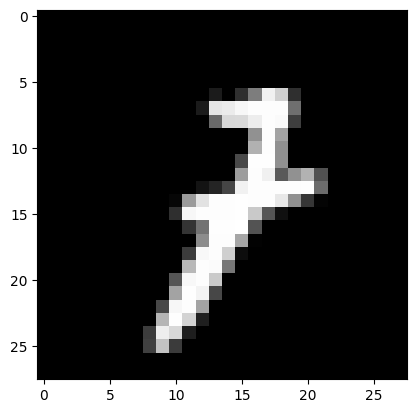

True
========================= 66 ===============================
test id: 39225
individual experts pred: {1: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


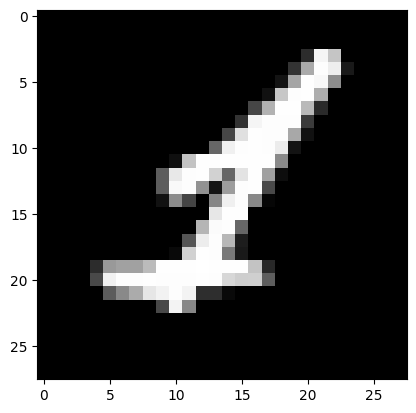

True
========================= 67 ===============================
test id: 39463
individual experts pred: {8: 2}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 8


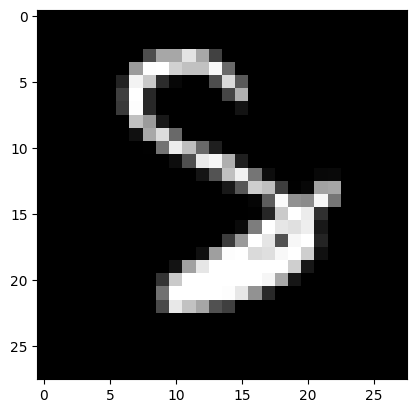

True
========================= 68 ===============================
test id: 41824
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


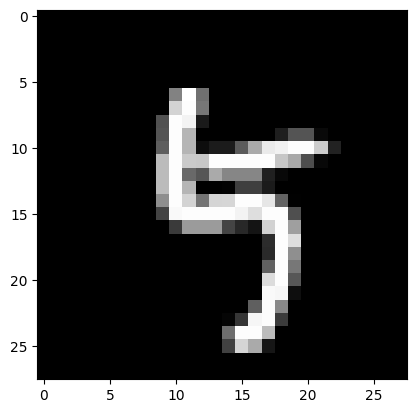

True
========================= 69 ===============================
test id: 41976
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


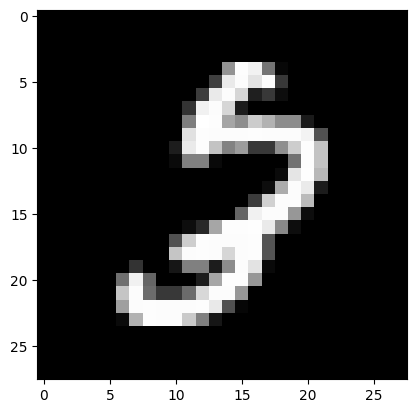

True
========================= 70 ===============================
test id: 42151
individual experts pred: {1: 1, 2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


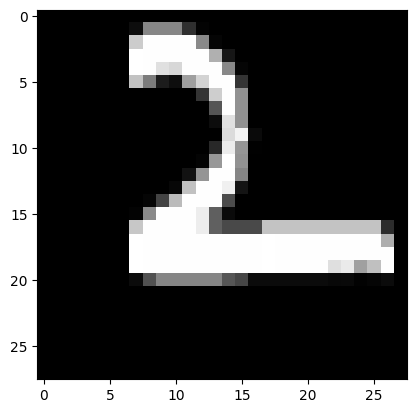

True
========================= 71 ===============================
test id: 43086
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


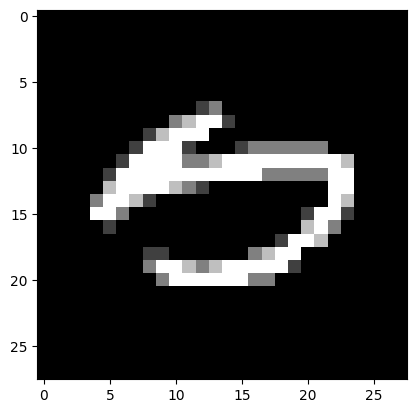

True
========================= 72 ===============================
test id: 43110
individual experts pred: {4: 1, 9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


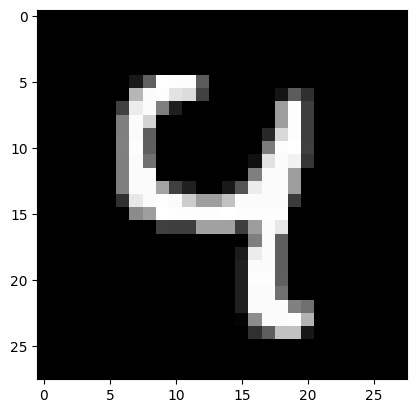

True
========================= 73 ===============================
test id: 44965
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


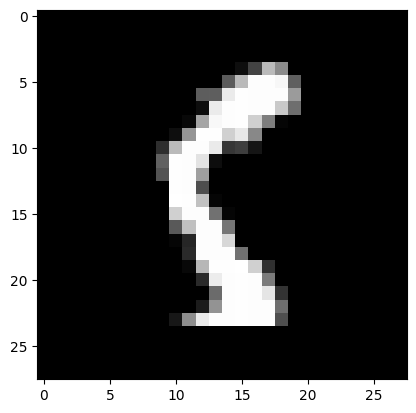

True
========================= 74 ===============================
test id: 45072
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


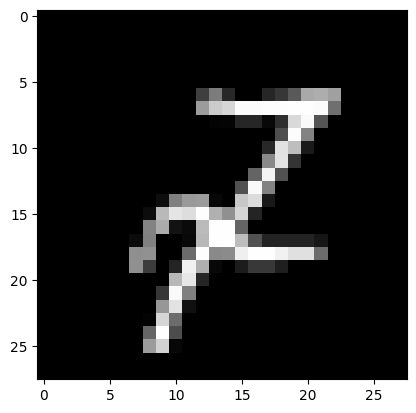

True
========================= 75 ===============================
test id: 47051
individual experts pred: {7: 3, 8: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


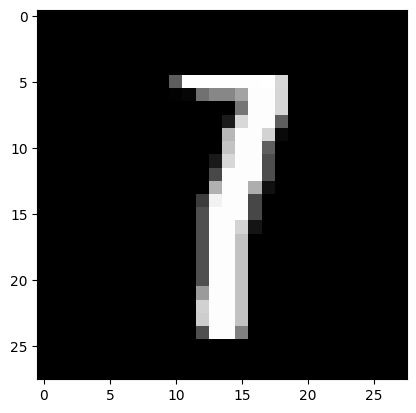

True
========================= 76 ===============================
test id: 47784
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


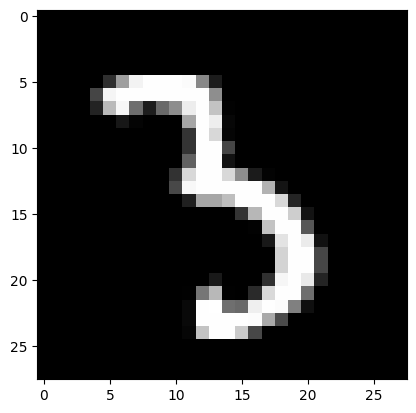

True
========================= 77 ===============================
test id: 48265
individual experts pred: {6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


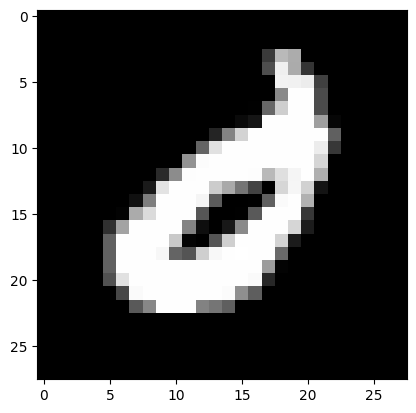

True
========================= 78 ===============================
test id: 48826
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


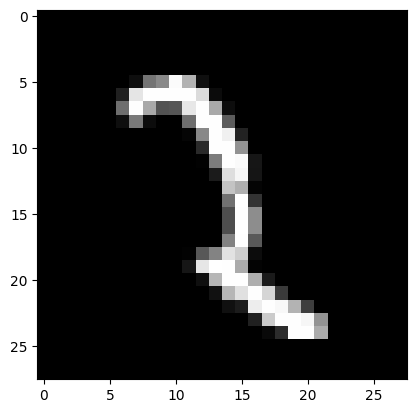

True
========================= 79 ===============================
test id: 49350
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


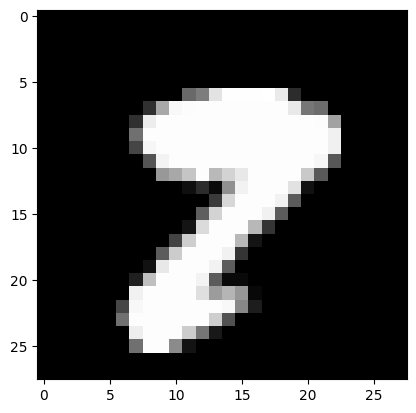

True
========================= 80 ===============================
test id: 49553
individual experts pred: {7: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


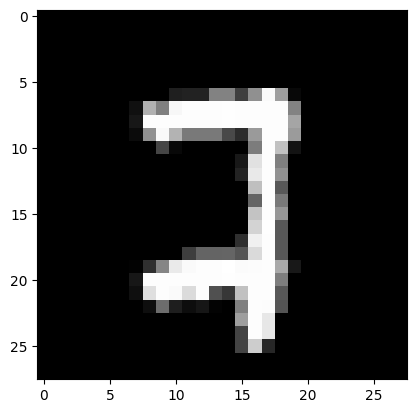

True
========================= 81 ===============================
test id: 50530
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


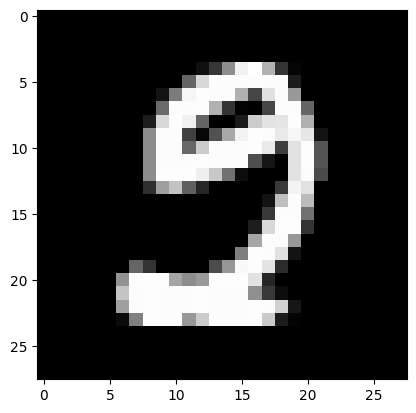

True
========================= 82 ===============================
test id: 50766
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


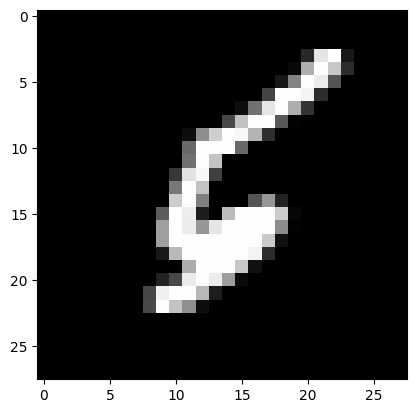

True
========================= 83 ===============================
test id: 50911
individual experts pred: {2: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 2


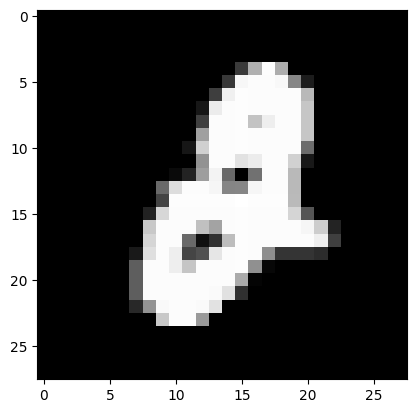

True
========================= 84 ===============================
test id: 50963
individual experts pred: {9: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


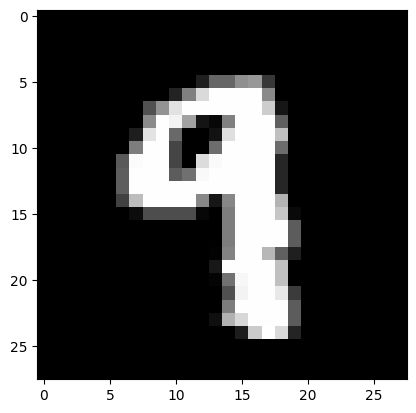

True
========================= 85 ===============================
test id: 51113
individual experts pred: {5: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 5


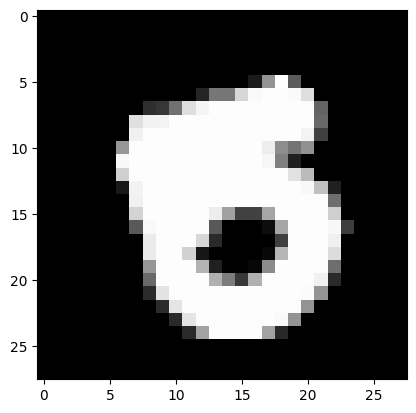

True
========================= 86 ===============================
test id: 51430
individual experts pred: {1: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 1


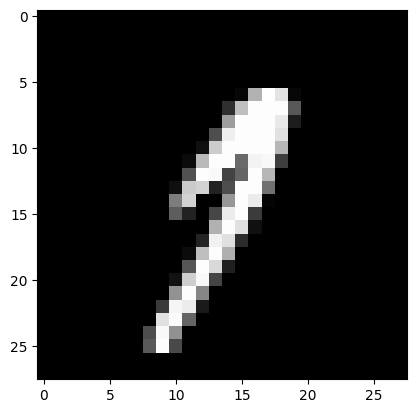

True
========================= 87 ===============================
test id: 51831
individual experts pred: {0: 4, 1: 1}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


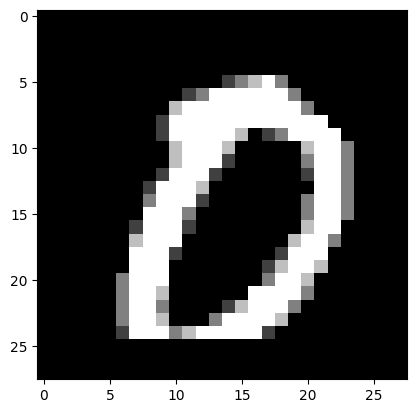

False
========================= 88 ===============================
test id: 51922
individual experts pred: {3: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 3


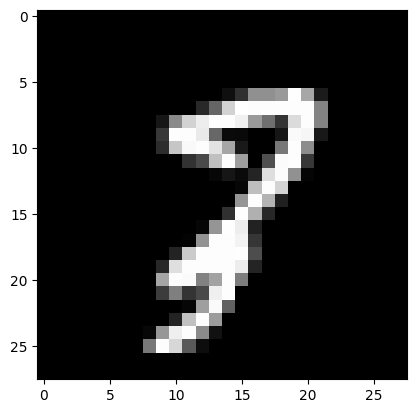

True
========================= 89 ===============================
test id: 52542
individual experts pred: {7: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 7


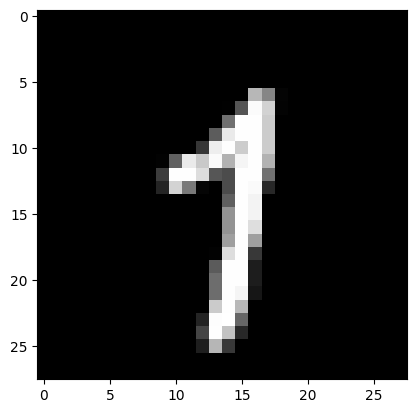

True
========================= 90 ===============================
test id: 53194
individual experts pred: {9: 3}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 9


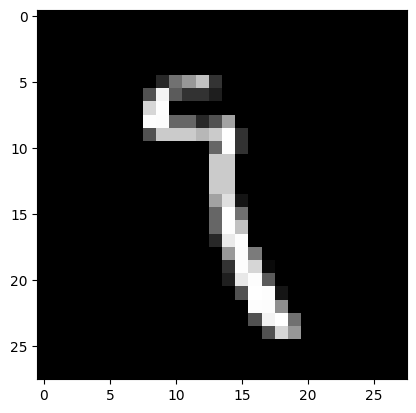

True
========================= 91 ===============================
test id: 53257
individual experts pred: {1: 1, 6: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 6


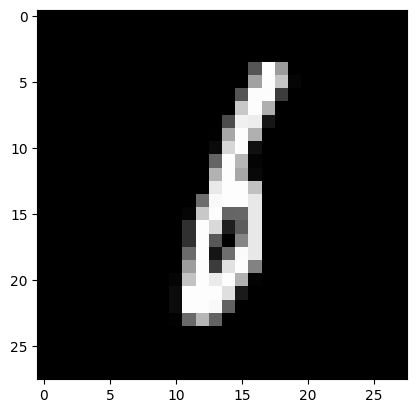

True
========================= 92 ===============================
test id: 53386
individual experts pred: {0: 4}
PoE predictive: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true label: 0


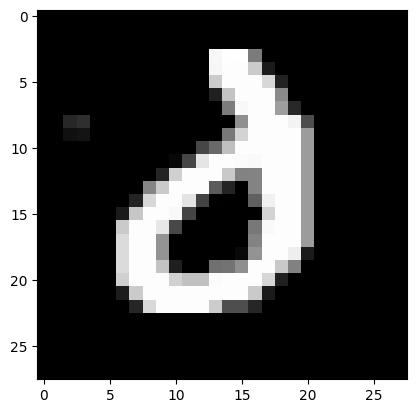

False


In [20]:
# pred_set_size = {i: [] for i in range(10)}
max_voting_correct_count = 0
for i, id_ in enumerate(np.arange(len(zero_preds_train))[np.array(zero_preds_train)]):
# for id_ in np.arange(len(nlls_))[np.array(infs)]:
    print(f"========================= {i} ===============================")
    print(f"test id: {id_}")
    # print(nn.sigmoid(logits[id_]).round())
    individual_preds = get_experts_preds(nn.sigmoid(logits_train[id_]).round())
    print(f"individual experts pred: {individual_preds}" )
    print(f"PoE predictive: {ovr_prod_probs(logits_train[id_])}")
    print(f"true label: {y_train[id_]}")
    plt.imshow(X_train[id_].reshape(28, 28), cmap='gray')
    plt.show()
    print(ovr_err(logits_train[id_], y_train[id_]))
#     pred_set_size_i = len(individual_preds)
#     pred_set_size[pred_set_size_i].append(id_)
    if individual_preds and max(individual_preds, key=individual_preds.get) == y_train[id_]:
        max_voting_correct_count += 1

In [22]:
max_voting_correct_count / zero_preds_train.sum()

DeviceArray(0.9892473, dtype=float32)